In [10]:
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)
print(tfa.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.keras import preprocessing


print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

2.2.0
0.11.2
GPU is available


In [11]:
import os
import random
import logging
import pyxdf
import numpy as np
import matplotlib.pyplot as plt
import mne
import math
import scipy.stats
from scipy.interpolate import interp1d

from os import walk

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_multitaper
from functools import reduce

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Activation, AveragePooling1D, AveragePooling2D, SeparableConv1D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.keras import Model
from sklearn import metrics
import tensorflow_probability as tfp

import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation
from scipy.io import arff

from modules import helper
from modules import transformer

Set random variables so that one run on the same computer always results in the same models

In [12]:
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
np.random.RandomState(seed_value)

np.random.seed(seed_value)

context.set_global_seed(seed_value)
ops.get_default_graph().seed = seed_value

#pip install tensorflow-determinism needed
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
np.random.seed(seed_value)

Loading and formarting the test and train data

In [13]:
# Select dataset!!!

#source: http://www.timeseriesclassification.com/description.php?Dataset=SyntheticControl
data_path_train = './Datasets/SyntheticControl/SyntheticControl_TRAIN.arff'
data_path_test = './Datasets/SyntheticControl/SyntheticControl_TEST.arff'
num_of_classes = 6
seqSize = 60

#source: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
#data_path_train = './Datasets/ecg5000/ECG5000_TRAIN.arff'
#data_path_test = './Datasets/ecg5000/ECG5000_TEST.arff'
#num_of_classes = 5
#seqSize = 140

#save preprocessing results and model weights
useSaves = False

#number of symbolics for SAX
n_bins = 5

#Load and formate data
data_train, meta_train = arff.loadarff(data_path_train)
data_test, meta_test = arff.loadarff(data_path_test)

data_train = np.array(data_train.tolist())
data_test = np.array(data_test.tolist())

y_trainy = data_train[:,-1].astype(int)
y_train = []
X_train = data_train[:,:-1]
y_testy_full = data_test[:,-1].astype(int)
y_testy = y_testy_full
y_test = []
X_test = data_test[:,:-1]

X_train, y_trainy = shuffle(X_train, y_trainy, random_state = seed_value)

for y in y_trainy:
    y_train_puffer = np.zeros(num_of_classes)
    y_train_puffer[y-1] = 1
    y_train.append(y_train_puffer)

for y in y_testy:
    y_puffer = np.zeros(num_of_classes)
    y_puffer[y-1] = 1
    y_test.append(y_puffer)

y_train = np.array(y_train)
y_train = y_train.astype(float)
y_test_full = np.array(y_test)
y_test_full = y_test_full.astype(float)
y_test = y_test_full  
y_test = y_test.astype(float)

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

X_test = X_test.astype(float)
X_train = X_train.astype(float)

# Initialize k-folds
kf = StratifiedKFold(5, shuffle=True, random_state=seed_value) # Use for StratifiedKFold classification
fold = 0

# Earlystopping callback
earlystop = EarlyStopping(monitor= 'val_loss', min_delta=0 , patience=50, verbose=0, mode='auto')

print('done')


(300, 60)
(300, 60)
(300, 6)
(300, 6)
done


Plots to exam the data

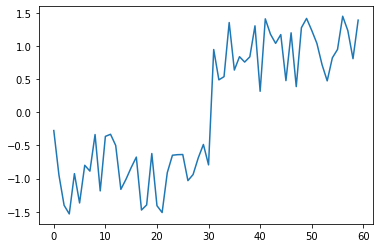

[0. 0. 0. 0. 1. 0.]


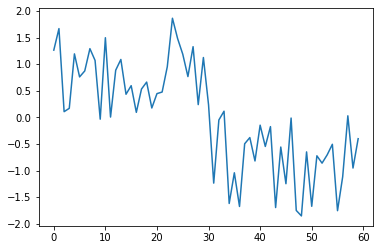

[0. 0. 0. 0. 0. 1.]


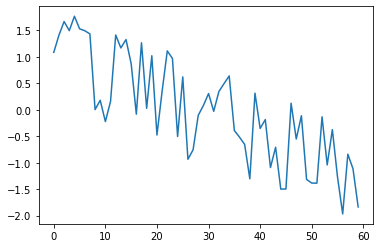

[0. 0. 0. 1. 0. 0.]


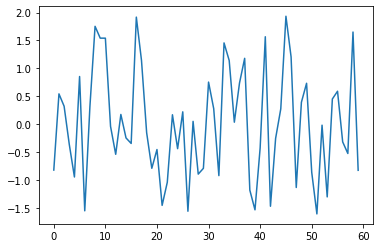

[1. 0. 0. 0. 0. 0.]


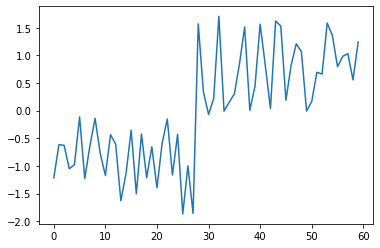

[0. 0. 0. 0. 1. 0.]


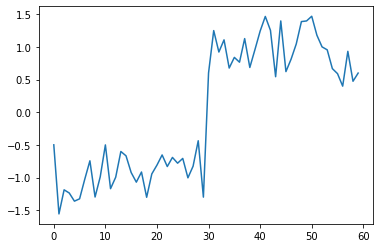

[0. 0. 0. 0. 1. 0.]


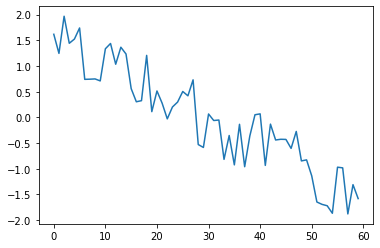

[0. 0. 0. 1. 0. 0.]


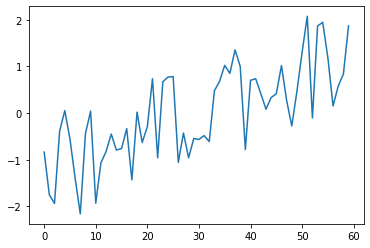

[0. 0. 1. 0. 0. 0.]


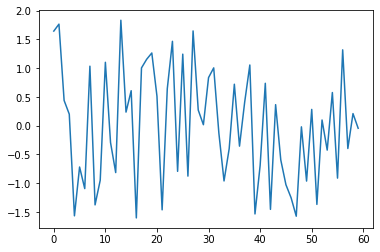

[1. 0. 0. 0. 0. 0.]


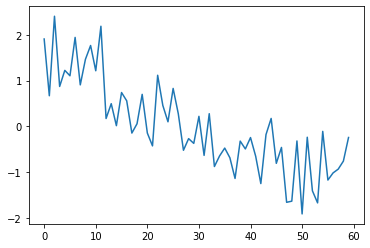

[0. 0. 0. 1. 0. 0.]


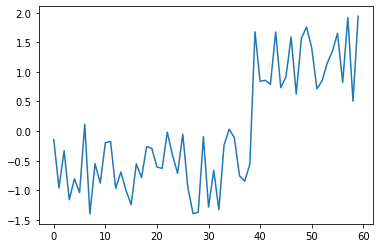

[0. 0. 0. 0. 1. 0.]


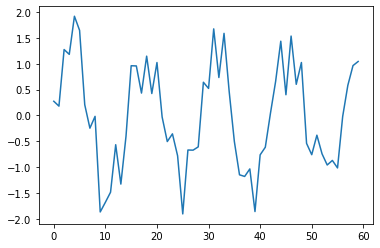

[0. 1. 0. 0. 0. 0.]


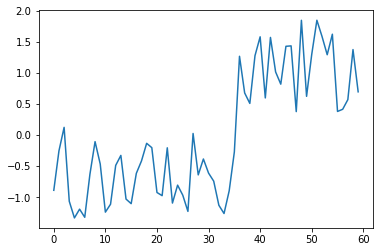

[0. 0. 0. 0. 1. 0.]


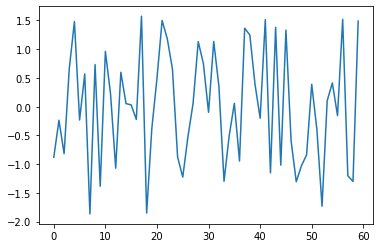

[1. 0. 0. 0. 0. 0.]


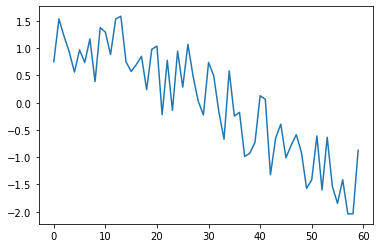

[0. 0. 0. 1. 0. 0.]


In [14]:
import datetime

z = 1

for z in range(15):

    x = range(seqSize)
    y = X_train[z]

    plt.plot(x,y)
    plt.show()
    print(y_train[z])

In [15]:
#create the transformer model with given information
def createModel(splits, x_train, x_val, x_test, batchSize, num_of_classes, doMask= False, rate = 0, numOfAttentionLayers=2):    
        print(np.array(x_train1).shape)
        x_trains = np.dsplit(x_train, splits)
        print(np.array(x_trains).shape)
        #x_trains = np.array(x_trains).squeeze(axis=3)
        x_trainsBatch = np.dsplit(x_train[:batchSize], splits)

        x_tests = np.dsplit(x_test, splits)
        x_vals = np.dsplit(x_val, splits)
        maxLen = len(x_trains[0][0])
        print(maxLen)

        print(np.array(x_trains).shape)
        flattenArray = []
        inputShapes = []
        encClasses = []
        for i in range(len(x_trains)):
            if doMask:

                masky = createMask(x_trains[i], 6)
                x_part = np.array(x_trains[i])
                print(np.array(x_part).shape)
            
                seq_len1 = x_part.shape[1]

                sens1 = x_part.shape[2]
                input_shape1 = (seq_len1, sens1)
                left_input1 = tf.keras.layers.Input(input_shape1, name='input_ids')
                    
                mask = tf.keras.layers.Input(shape=masky.shape[1:], name='attention_mask')
                print('masky shape')
                print(masky.shape)
                print(mask)
            else: 
                mask = Input(1)
                x_part = np.array(x_trains[i])
                print(np.array(x_part).shape)
            
                seq_len1 = x_part.shape[1]

                sens1 = x_part.shape[2]
                input_shape1 = (seq_len1, sens1)
                left_input1 = Input(input_shape1)

            inputShapes.append(left_input1)
            if doMask:
                inputShapes.append(mask)

            encoded = left_input1
            input_vocab_size = 0
            
            #create transformer encoder layer 
            encClass1 = transformer.Encoder(numOfAttentionLayers, 16, 6, 6, 5000, rate=rate, input_vocab_size = input_vocab_size + 2, maxLen = maxLen, doMask=doMask, seed_value=seed_value)
                
            encClasses.append(encClass1)
            if doMask:
                encInput = encoded, mask
                print('ssssssssssssssssssssss')
                print(encoded.shape)
                print(mask.shape)
                print(encoded)
                print(mask)
                print('endddddddd')
            else:
                maskLayer = tf.keras.layers.Masking(mask_value=-2)
                encInput = maskLayer(encoded)
            enc1, attention, fullAttention = encClass1(encInput)
            flatten1 = Flatten()(enc1)
            flattenArray.append(flatten1)
        

        # Merge nets
        if splits == 1:
            merged = flattenArray[0]
        else:
            merged = concatenate(flattenArray)

        output = Dense(num_of_classes, activation = "sigmoid")(merged)
        
        # Create combined model
        wdcnnt_multi = Model(inputs=inputShapes,outputs=(output))
        print(wdcnnt_multi.summary())
        
        print(wdcnnt_multi.count_params())
        
        tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed_value)

        learning_rate = transformer.CustomSchedule(16)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.99, 
                                     epsilon=1e-9)
        
        wdcnnt_multi.compile(optimizer=optimizer,
                    loss='mean_squared_error',
                    metrics=['accuracy'], run_eagerly=False)
        
        print('done')
        
        return wdcnnt_multi, inputShapes, x_trains, x_tests, x_vals

In [16]:
#abstracting dating with interpolation
def abstractData(data, earlyPredictorZ, takeAvg = True, heatLayer = 0, limit = 300):
    attentionFQ = []
    
    #split data so only #limit many variables are predicted at a time
    for bor in range(int(math.ceil(len(data)/limit))):
        if(takeAvg):
            attentionFQ.extend(earlyPredictorZ.predict([data[bor*limit:(bor+1)*limit]])[1])
        else: 
            attentionFQ.extend(earlyPredictorZ.predict([data[bor*limit:(bor+1)*limit]])[2])
    newX = []
    reduction = []
    for index in range(len(data)):        

            X_sax = np.array(data).squeeze()[index]
            X_ori = X_sax 

            if(takeAvg):
                heat = np.sum(np.max(attentionFQ[index], axis = 1), axis = 0)
            else:
                heat = np.sum(np.max(attentionFQ[heatLayer][index], axis = 1), axis = 0)
        
            #Do abstraction based on thresholds
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                maxHeat = np.average(heat)
                borderHeat = maxHeat
                borderHeat2 = maxHeat/1.2

            #filter based on heat
            fitleredSet = []
            indexSet = []
            avgSet = []
            for h in range(len(heat)):
                if heat[h] > borderHeat:
                    if len(avgSet) != 0:
                        fitleredSet.append(np.median(avgSet))
                        indexSet.append(h - math.ceil(len(avgSet)/2))
                        avgSet = []
                    fitleredSet.append(X_ori[h])
                    indexSet.append(h)
                elif heat[h] > borderHeat2:
                    avgSet.append(X_ori[h])
                elif len(avgSet) != 0:
                    fitleredSet.append(np.median(avgSet))
                    indexSet.append(h - math.ceil(len(avgSet)/2))
                    avgSet = []
            
            if len(avgSet) != 0:
                fitleredSet.append(np.median(avgSet))
                indexSet.append(h - math.ceil(len(avgSet)/2))
                
            reduction.append(1 - len(fitleredSet)/len(heat))
            
            if(len(fitleredSet) < 2):
                fitleredSet.append(0)
                indexSet.append(len(heat))
            newXTemp = interp1d(indexSet, fitleredSet, bounds_error = False, fill_value = -2)
            newX.append([[x] for x in newXTemp(range(len(heat)))])

    newX = np.array(newX, dtype=np.float32)
    print(np.array(newX).shape)
    print(data.shape)
    return newX, reduction

#abstracting dating with no interpolation and added mask values
def abstractData2(data, earlyPredictorZ, takeAvg = True, heatLayer = 0, limit = 300):
    attentionFQ = []
    for bor in range(int(math.ceil(len(data)/limit))):
        if(takeAvg):
            attentionFQ.extend(earlyPredictorZ.predict([data[bor*limit:(bor+1)*limit]])[1])
        else: 
            attentionFQ.extend(earlyPredictorZ.predict([data[bor*limit:(bor+1)*limit]])[2])
    newX = []
    reduction = []
    for index in range(len(data)):        
            X_sax = np.array(data).squeeze()[index]
            X_ori = X_sax 

            if(takeAvg):
                heat = np.sum(np.max(attentionFQ[index], axis = 1), axis = 0)
            else:
                heat = np.sum(np.max(attentionFQ[heatLayer][index], axis = 1), axis = 0)
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                maxHeat = np.average(heat)
                borderHeat = maxHeat
                borderHeat2 = maxHeat/1.2
            #print(heat)
            #print(maxHeat)

            
            #filter based on heat and add masked values
            fitleredSet = []
            indexSet = []
            avgSet = []
            for h in range(len(heat)):
                if heat[h] > borderHeat:
                    if len(avgSet) != 0:
                        fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet)
                        avgSet = []
                    fitleredSet.append(X_ori[h])
                elif heat[h] > borderHeat2:
                    fitleredSet.append(-2)
                    avgSet.append(X_ori[h])
                elif len(avgSet) != 0:
                    fitleredSet.append(-2)
                    fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet)

                    avgSet = []
                else:
                    fitleredSet.append(-2)
            if len(avgSet) != 0:
                fitleredSet[h - math.ceil(len(avgSet)/2)] = np.median(avgSet)

            reduction.append(1 - len([x for x in fitleredSet if x != -2])/len(heat))
            newX.append([[x] for x in fitleredSet])


    newX = np.array(newX, dtype=np.float32)
    print(np.array(newX).shape)
    print(data.shape)
    return newX, reduction

#preprocess data with StandardScaler and SAX
def preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy, y_testy, binNr):    
    
    x_test = X_test.copy()
    
    processedDataName = "./saves/"+str(data_path_train.split('/')[-1].split('.')[0])+ '-size' + str(seqSize) + '-bin' + str(binNr)
    fileExists = os.path.isfile(processedDataName +'.pkl')

    if(fileExists and useSaves):
        print('found file! Start loading file!')
        res = helper.load_obj(processedDataName)


        for index, v in np.ndenumerate(res):
            print(index)
            res = v
        res.keys()

        x_train1 = res['X_train']
        x_train1 = res['X_val']
        x_test = res['X_test']
        x_val = res['X_val']
        X_train_ori = res['X_train_ori']
        X_test_ori = res['X_test_ori']
        y_trainy = res['y_trainy']
        y_train1 = res['y_train']
        y_test = res['y_test']
        y_testy = res['y_testy']
        y_val = res['y_val']
        X_val_ori = res['X_val_ori']
        print(x_test.shape)
        print(x_train1.shape)
        print(y_test.shape)
        print(y_train.shape)
        
    else:
        print(x_test.shape)
        print(x_train1.shape)
        print(x_val.shape)
        print(y_test.shape)
        print(y_train.shape)
        trainShape = x_train1.shape
        valShape = x_val.shape
        testShape = x_test.shape
        
        scaler = StandardScaler()    
        scaler = scaler.fit(x_train1.reshape((-1,1)))
        X_train = scaler.transform(x_train1.reshape(-1, 1)).reshape(trainShape)
        x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(valShape)
        x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(testShape)

        X_test_ori = x_test.copy()
        X_val_ori = x_val.copy()
        X_train_ori = x_train1.copy()

        #Do SAX
        sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='uniform')
        sax.fit(x_train1)
        x_train1 = helper.symbolizeTrans(x_train1, sax)
        x_val = helper.symbolizeTrans(x_val, sax)
        x_test = helper.symbolizeTrans(x_test, sax)

            

        x_train1 = np.expand_dims(x_train1, axis=2)
        x_val = np.expand_dims(x_val, axis=2)
        x_test = np.expand_dims(x_test, axis=2)   
        X_test_ori = np.expand_dims(X_test_ori, axis=2)   
        X_train_ori = np.expand_dims(X_train_ori, axis=2) 
        X_val_ori = np.expand_dims(X_val_ori, axis=2) 

        print(x_test.shape)
        print(x_train1.shape)

        #save sax results to only calculate them once
        resultsSave = {
            'X_train':x_train1,
            'X_train_ori':X_train_ori,
            'X_test':x_test,
            'X_test_ori':X_test_ori,
            'X_val': x_val,
            'X_val_ori':X_val_ori,
            'y_trainy':y_trainy,
            'y_train':y_train1,
            'y_val': y_val,
            'y_test':y_test,
            'y_testy':y_testy
        }
        helper.save_obj(resultsSave, processedDataName)
    return x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy, y_testy

In [17]:
#get save weight names! Depends on other set variables
def getWeightName(learning = True):
    baseName = "./saves/weights-" + str(data_path_train.split('/')[-1].split('.')[0]) + '-size' + str(seqSize) + '-threshold' + maxString + '-input' + abstractionString + '-fold' + str(fold)
    if learning:
        return baseName + '-learning.tf'
    else:
        return baseName + '.tf'

#do training with abstraction level = abstraction
def doAbstractedTraining(trainD, valD, testD, abstraction = 0, earlyPredictorZ = None, takeAvg = True, rate=0, heatLayer = 0, numOfAttentionLayers = 1):
    
    #Interpolation abstraction
    if abstraction == 2 and earlyPredictorZ != None:
        newTrain, trainReduction = abstractData(trainD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newVal, valReduction = abstractData(valD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newTest, testReduction = abstractData(testD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
    #Mask abstraction
    elif abstraction == 3 and earlyPredictorZ != None:
        newTrain, trainReduction = abstractData2(trainD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newVal, valReduction = abstractData2(valD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
        newTest, testReduction = abstractData2(testD, earlyPredictorZ, takeAvg = takeAvg, heatLayer = heatLayer)
    else:
        newTrain = trainD
        newVal = valD
        newTest = testD
        trainReduction = 0
        valReduction = 0
        testReduction = 0
    

    #calclulate shifts of the data
    valShifts = []
    smallerValSet = []
    for val in newVal:
        shifts = -1
        smallerSet = 2
        lastVal = val[0][0]
        rise = -3
        timeSkip = 1
        for v in val[1:]:
            v = v[0]

            if v == -2:
                timeSkip += 1
            elif helper.truncate((v - lastVal) / timeSkip) != rise:
                shifts += 1
                smallerSet += 1
                rise = helper.truncate((v - lastVal) / timeSkip)
                lastVal = v
                timeSkip = 1
            else:
                lastVal = v
        valShifts.append(shifts)
        smallerValSet.append(smallerSet)

    valShifts = np.average(valShifts)
    smallerValSet = np.average(smallerValSet)


    testShifts = []
    smallerTestSet = []
    print(newTest.shape)
    for val in newTest:
        shifts = -1
        smallerSet = 2
        lastVal = val[0][0]
        rise = -3
        timeSkip = 1
        for v in val[1:]:
            v = v[0]
            if v == -2:
                timeSkip += 1
            elif round(v - lastVal / timeSkip, 1) != rise:
                shifts += 1
                smallerSet += 1
                rise = round(v - lastVal / timeSkip, 1)
                lastVal = v
                timeSkip = 1
            else:
                lastVal = v
        testShifts.append(shifts)
        smallerTestSet.append(smallerSet)

    testShifts = np.average(testShifts)
    smallerTestSet = np.average(smallerTestSet)

    #create model and train
    n_model2, inputs2, x_trains2, x_tests2, x_vals2 = createModel(1, newTrain, newVal, newTest , BATCH, num_of_classes, rate=rate, doMask=False, numOfAttentionLayers=numOfAttentionLayers)
    weightsName = getWeightName(learning=True)
    saveBest2 = transformer.SaveBest(weightsName)
    print(np.array(x_trains2).shape)
    print(np.array(x_vals2).shape)

    x_trains_mask = x_trains2
    
    if (os.path.isfile(getWeightName(learning=False) + '.index') and useSaves):
        print('found weights to load! Won\'t train model!')
        n_model2.load_weights(getWeightName(learning=False))
    else:
        print('No weights found! Start training model!')
        n_model2.fit(x_trains_mask, y_train1, validation_data = (x_vals2, y_val) , epochs = 500, batch_size = BATCH, verbose=1, callbacks =[earlystop, saveBest2], shuffle = True)
        n_model2.load_weights(getWeightName(learning=True))
        n_model2.save_weights(getWeightName(learning=False), overwrite=True)
        
    earlyPredictor2 = tf.keras.Model(n_model2.inputs, n_model2.layers[2].output)

    # Predictions on the validation set
    predictions2 = n_model2.predict(x_vals2)
    attentionQ2 = earlyPredictor2.predict(x_vals2)

    print('############################')
    predictions2 = np.argmax(predictions2,axis=1)

    # Measure this fold's accuracy on validation set compared to actual labels
    y_compare = np.argmax(y_val, axis=1)
    val_score2 = metrics.accuracy_score(y_compare, predictions2)

    print(f"validation fold score with input {abstractionString}-{maxString}(accuracy): {val_score2}")

    # Predictions on the test set
    limit = 300
    test_predictions_loop2 = []
    for bor in range(int(math.ceil(len(x_tests2[0])/limit))):
        test_predictions_loop2.extend(n_model2.predict([x_tests2[0][bor*limit:(bor+1)*limit]]))

    # Append actual labels of the test set to empty list
    y_testyy = [y-1 for y in y_testy]
    test_predictions_loop2 = np.argmax(test_predictions_loop2, axis=1)

    # Measure this fold's accuracy on test set compared to actual labels
    test_score2 = metrics.accuracy_score(y_testyy, test_predictions_loop2)

    print(f"test fold score with input {abstractionString}-{maxString}(accuracy): {test_score2}")
    return val_score2, test_score2, predictions2, test_predictions_loop2, n_model2, inputs2, x_trains2, x_tests2, x_vals2, attentionQ2, smallerValSet, smallerTestSet, valShifts, testShifts, earlyPredictor2, newTrain, newVal, newTest, valReduction, testReduction

In [18]:
# Initialize loop for every kth fold

doAbstraction = True
#Attention layers count
numOfAttentionLayers = 2
#take Attention average
takeAvg = True
#drouput rate
rate=0.3

usedAbstraction = ['Ori', 'SAX', 'interpol', 'mask']    
usedThresholds = ['None', 'None', 'average', 'max']   
BATCH = 50
fold = 0

maxString = 'None'
accResults = [[],[],[],[],[],[]]
resultNames = ['Ori', 'SAX', 'avgInter', 'maxInter', 'avgMask', 'maxMask' ]

for train, test in kf.split(X_train, y_trainy): # Must specify y StratifiedKFold for 
    fold+=1
    print(f"Fold #{fold}")
    
    #preprocess data
    x_train1 = X_train[train]
    x_val = X_train[test]
    y_train1 = y_train[train]
    y_val = y_train[test]
    
    x_train1, x_val, x_test, y_train1, y_val, y_test, X_train_ori, X_val_ori, X_test_ori, y_trainy, y_testy = preprocessData(x_train1, x_val, X_test, y_train1, y_val, y_test, y_trainy, y_testy, fold)

    abstractionIndex = 0
    resultIndex = 0
    
    #ori data    
    abstractionString = usedAbstraction[abstractionIndex]    
    outOri = doAbstractedTraining(X_train_ori, X_val_ori, X_test_ori, abstractionIndex, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   

    accResults[resultIndex].append(outOri)
    resultIndex+=1
    
    # sax data    
    abstractionIndex += 1
    abstractionString = usedAbstraction[abstractionIndex]  
    outSax = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
    accResults[resultIndex].append(outSax)
    resultIndex+=1
    
    if doAbstraction:
        earlyPredictor = outSax[-6]
        abstractionIndex += 1
        abstractionString = usedAbstraction[abstractionIndex]  
        doMax = False
        maxString = 'average'
        outAvgAverage = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
        accResults[resultIndex].append(outAvgAverage)
        resultIndex+=1        
        doMax = True
        maxString = 'max'
        outMaxAverage = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
        accResults[resultIndex].append(outMaxAverage)
        resultIndex+=1    
        
        abstractionIndex += 1
        abstractionString = usedAbstraction[abstractionIndex]  
        doMax = False
        maxString = 'average'
        outAvgMask = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
        accResults[resultIndex].append(outAvgMask)
        resultIndex+=1         
        doMax = True
        maxString = 'max'
        outMaxMask = doAbstractedTraining(x_train1, x_val, x_test, abstractionIndex, earlyPredictorZ=earlyPredictor, rate=rate, takeAvg = takeAvg, heatLayer = 0, numOfAttentionLayers = numOfAttentionLayers)   
        accResults[resultIndex].append(outMaxMask)
        resultIndex+=1     
    
rIndex = 0    
for results in accResults:
    resultName = resultNames[rIndex]
    rIndex += 1
    
    print('#########################################')
    print(resultName + ' Scores:')
    print('#########################################')
    print(f"Avg validation score (accuracy): {np.average([r[0] for r in results])}")   
    print(f"Avg test score (accuracy): {np.average([r[1] for r in results])}")
    print(f"Avg Val reduced by: {np.average([r[-2] for r in results])}")
    print(f"Avg Test reduced by: {np.average([r[-1] for r in results])}")
    print(f"Avg Interpol Val Size: {np.average([r[-10] for r in results])}")
    print(f"Avg Interpol Test Size: {np.average([r[-8] for r in results])}")
    print(f"Avg Val shifts: {np.average([r[-8] for r in results])}")
    print(f"Avg Test shifts: {np.average([r[-7] for r in results])}")

    if rIndex > 2:
        abstractValPred = np.concatenate([r[2] for r in results])
        oriValPred = np.concatenate([r[2] for r in accResults[1]])
        valSwitch = 0
        for i in range(len(abstractValPred)):
            if abstractValPred[i] != oriValPred[i]:
                valSwitch += 1
                              
        abstractTestPred = np.concatenate([r[3] for r in results])
        oriTestPred = np.concatenate([r[3] for r in accResults[1]])
        testSwitch = 0
        for i in range(len(abstractTestPred)):
            if abstractTestPred[i] != oriTestPred[i]:
                testSwitch += 1

        print(f"Val Switched: {valSwitch / len(abstractValPred)}")
        print(f"Test Switched: {testSwitch / len(abstractTestPred)}")

Fold #1
(300, 60)
(240, 60)
(60, 60)
(300, 6)
(300, 6)
(300, 60, 1)
(240, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_7 (Masking)          (None, 60, 1)             0         
_________________________________________________________________
encoder_7 (Encoder)          ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_23 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_71 (Dense)     

D:\programme\anaconda\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:328: UserWarning: Seed 42 from outer graph might be getting used by function Dataset_map_permutation, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  indices_dataset = indices_dataset.map(permutation).prefetch(1)



(None, 60, 16)
mask
(None, 60, 16)
mask
1/5 [=====>........................] - ETA: 0s - loss: 0.2407 - accuracy: 0.1200(None, 60, 16)
mask
#########++++##########
5/5 [==============================] - 0s 93ms/step - loss: 0.2387 - accuracy: 0.1583 - val_loss: 0.2354 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2349 - accuracy: 0.1583 - val_loss: 0.2345 - val_accuracy: 0.1667
Epoch 3/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2423 - accuracy: 0.1542 - val_loss: 0.2329 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2394 - accuracy: 0.1667 - val_loss: 0.2308 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2350 - accuracy: 0.1417 - val_loss: 0.2280 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2364 - accuracy: 0.1625 - val_loss: 0.2247 - val_accuracy: 0.1667
Epoch 7

5/5 [==============================] - 0s 36ms/step - loss: 0.1448 - accuracy: 0.1500 - val_loss: 0.1391 - val_accuracy: 0.1667
Epoch 35/500
5/5 [==============================] - 0s 38ms/step - loss: 0.1449 - accuracy: 0.1417 - val_loss: 0.1390 - val_accuracy: 0.1667
Epoch 36/500
5/5 [==============================] - 0s 40ms/step - loss: 0.1434 - accuracy: 0.1958 - val_loss: 0.1390 - val_accuracy: 0.1667
Epoch 37/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1408 - accuracy: 0.1875 - val_loss: 0.1390 - val_accuracy: 0.1667
Epoch 38/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1411 - accuracy: 0.2292 - val_loss: 0.1388 - val_accuracy: 0.1500
Epoch 39/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1427 - accuracy: 0.1708 - val_loss: 0.1387 - val_accuracy: 0.0667
Epoch 40/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1414 - accuracy: 0.1917 - val_loss: 0.1386 - val_accuracy: 0.0667
Epoch 41/500
5/5 [========

5/5 [==============================] - 0s 35ms/step - loss: 0.1095 - accuracy: 0.5083 - val_loss: 0.1109 - val_accuracy: 0.4333
Epoch 75/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1099 - accuracy: 0.4625 - val_loss: 0.1098 - val_accuracy: 0.4167
Epoch 76/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1077 - accuracy: 0.4958 - val_loss: 0.1088 - val_accuracy: 0.4500
Epoch 77/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1061 - accuracy: 0.4958 - val_loss: 0.1078 - val_accuracy: 0.4667
Epoch 78/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0991 - accuracy: 0.6083 - val_loss: 0.1068 - val_accuracy: 0.4833
Epoch 79/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1013 - accuracy: 0.5750 - val_loss: 0.1059 - val_accuracy: 0.4833
Epoch 80/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0998 - accuracy: 0.5750 - val_loss: 0.1049 - val_accuracy: 0.5000
Epoch 81/500
5/5 [========

Epoch 111/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0587 - accuracy: 0.8625 - val_loss: 0.0771 - val_accuracy: 0.7333
Epoch 112/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0590 - accuracy: 0.8458 - val_loss: 0.0764 - val_accuracy: 0.7500
Epoch 113/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0581 - accuracy: 0.8583 - val_loss: 0.0754 - val_accuracy: 0.7500
Epoch 114/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0557 - accuracy: 0.8792 - val_loss: 0.0746 - val_accuracy: 0.7333
Epoch 115/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0551 - accuracy: 0.8833 - val_loss: 0.0739 - val_accuracy: 0.7500
Epoch 116/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0561 - accuracy: 0.8792 - val_loss: 0.0732 - val_accuracy: 0.7500
Epoch 117/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0538 - accuracy: 0.8625 - val_loss: 0.0723 - val_accuracy: 0.7500
Epoch 

Epoch 150/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0245 - accuracy: 0.9792 - val_loss: 0.0493 - val_accuracy: 0.8333
Epoch 151/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0224 - accuracy: 0.9833 - val_loss: 0.0492 - val_accuracy: 0.8333
Epoch 152/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0212 - accuracy: 0.9750 - val_loss: 0.0483 - val_accuracy: 0.8500
Epoch 153/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0195 - accuracy: 0.9875 - val_loss: 0.0472 - val_accuracy: 0.8500
Epoch 154/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0202 - accuracy: 0.9750 - val_loss: 0.0463 - val_accuracy: 0.8333
Epoch 155/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0191 - accuracy: 0.9875 - val_loss: 0.0455 - val_accuracy: 0.8333
Epoch 156/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0183 - accuracy: 0.9875 - val_loss: 0.0454 - val_accuracy: 0.8500
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9167
Epoch 192/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 0.9167
Epoch 193/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9000
Epoch 194/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.8833
Epoch 195/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9167
Epoch 196/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9167
Epoch 197/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9000
Epoch 198/500
5/5 [=

Epoch 238/500
5/5 [==============================] - 0s 17ms/step - loss: 9.2451e-04 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9167
Epoch 239/500
5/5 [==============================] - 0s 33ms/step - loss: 8.6006e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9167
Epoch 240/500
5/5 [==============================] - 0s 37ms/step - loss: 9.1961e-04 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9167
Epoch 241/500
5/5 [==============================] - 0s 16ms/step - loss: 7.9305e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9167
Epoch 242/500
5/5 [==============================] - 0s 17ms/step - loss: 7.1371e-04 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9167
Epoch 243/500
5/5 [==============================] - 0s 17ms/step - loss: 8.1846e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9000
Epoch 244/500
5/5 [==============================] - 0s 16ms/step - loss: 7.1675e-04 - accuracy: 1.0000 - val_loss: 0.0233 -

5/5 [==============================] - 0s 17ms/step - loss: 1.5783e-04 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9167
Epoch 290/500
5/5 [==============================] - 0s 17ms/step - loss: 1.4739e-04 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9000
Epoch 291/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3077e-04 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9167
Epoch 292/500
5/5 [==============================] - 0s 16ms/step - loss: 1.8031e-04 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9167
Epoch 293/500
5/5 [==============================] - 0s 16ms/step - loss: 1.2632e-04 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9167
Epoch 294/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4711e-04 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9167
Epoch 295/500
5/5 [==============================] - 0s 15ms/step - loss: 1.2407e-04 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 2.3782e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.8833
Epoch 344/500
5/5 [==============================] - 0s 16ms/step - loss: 2.4507e-05 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9167
Epoch 345/500
5/5 [==============================] - 0s 16ms/step - loss: 3.3472e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9000
Epoch 346/500
5/5 [==============================] - 0s 15ms/step - loss: 2.7120e-05 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9000
Epoch 347/500
5/5 [==============================] - 0s 15ms/step - loss: 2.4833e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9000
Epoch 348/500
5/5 [==============================] - 0s 17ms/step - loss: 2.2898e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.8833
Epoch 349/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6150e-05 - accuracy: 1.0000 - val_loss: 0.0219 - val_accuracy:

5/5 [==============================] - 0s 35ms/step - loss: 0.3912 - accuracy: 0.1792 - val_loss: 0.3723 - val_accuracy: 0.1667
Epoch 10/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3755 - accuracy: 0.1875 - val_loss: 0.3629 - val_accuracy: 0.1667
Epoch 11/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3631 - accuracy: 0.1750 - val_loss: 0.3528 - val_accuracy: 0.1667
Epoch 12/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3735 - accuracy: 0.1625 - val_loss: 0.3421 - val_accuracy: 0.1667
Epoch 13/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3412 - accuracy: 0.1708 - val_loss: 0.3309 - val_accuracy: 0.1667
Epoch 14/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3417 - accuracy: 0.1833 - val_loss: 0.3193 - val_accuracy: 0.1667
Epoch 15/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3277 - accuracy: 0.2083 - val_loss: 0.3074 - val_accuracy: 0.1667
Epoch 16/500
5/5 [========

Epoch 46/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1361 - accuracy: 0.2833 - val_loss: 0.1334 - val_accuracy: 0.3833
Epoch 47/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1364 - accuracy: 0.2917 - val_loss: 0.1330 - val_accuracy: 0.3833
Epoch 48/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1358 - accuracy: 0.2875 - val_loss: 0.1326 - val_accuracy: 0.3833
Epoch 49/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1355 - accuracy: 0.3125 - val_loss: 0.1322 - val_accuracy: 0.4000
Epoch 50/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1356 - accuracy: 0.3042 - val_loss: 0.1319 - val_accuracy: 0.4000
Epoch 51/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1354 - accuracy: 0.3000 - val_loss: 0.1314 - val_accuracy: 0.4000
Epoch 52/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1338 - accuracy: 0.2875 - val_loss: 0.1309 - val_accuracy: 0.4167
Epoch 53/500


5/5 [==============================] - 0s 33ms/step - loss: 0.0936 - accuracy: 0.6458 - val_loss: 0.0912 - val_accuracy: 0.6667
Epoch 85/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0985 - accuracy: 0.6042 - val_loss: 0.0900 - val_accuracy: 0.6833
Epoch 86/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0993 - accuracy: 0.6167 - val_loss: 0.0890 - val_accuracy: 0.7000
Epoch 87/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0987 - accuracy: 0.5583 - val_loss: 0.0881 - val_accuracy: 0.7000
Epoch 88/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0945 - accuracy: 0.6417 - val_loss: 0.0868 - val_accuracy: 0.7333
Epoch 89/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0936 - accuracy: 0.6375 - val_loss: 0.0855 - val_accuracy: 0.7333
Epoch 90/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0899 - accuracy: 0.6792 - val_loss: 0.0837 - val_accuracy: 0.7500
Epoch 91/500
5/5 [========

Epoch 128/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0407 - accuracy: 0.9167 - val_loss: 0.0507 - val_accuracy: 0.8333
Epoch 129/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0437 - accuracy: 0.9000 - val_loss: 0.0498 - val_accuracy: 0.8167
Epoch 130/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0393 - accuracy: 0.9208 - val_loss: 0.0489 - val_accuracy: 0.8500
Epoch 131/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0396 - accuracy: 0.9083 - val_loss: 0.0482 - val_accuracy: 0.8500
Epoch 132/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0381 - accuracy: 0.9042 - val_loss: 0.0487 - val_accuracy: 0.8333
Epoch 133/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0368 - accuracy: 0.9167 - val_loss: 0.0476 - val_accuracy: 0.8667
Epoch 134/500
5/5 [==============================] - 0s 45ms/step - loss: 0.0348 - accuracy: 0.9250 - val_loss: 0.0465 - val_accuracy: 0.8833
Epoch 

Epoch 166/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0150 - accuracy: 0.9792 - val_loss: 0.0324 - val_accuracy: 0.9000
Epoch 167/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0156 - accuracy: 0.9875 - val_loss: 0.0314 - val_accuracy: 0.9167
Epoch 168/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0139 - accuracy: 0.9875 - val_loss: 0.0322 - val_accuracy: 0.9000
Epoch 169/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0139 - accuracy: 0.9792 - val_loss: 0.0321 - val_accuracy: 0.9000
Epoch 170/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0135 - accuracy: 0.9875 - val_loss: 0.0312 - val_accuracy: 0.9000
Epoch 171/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0129 - accuracy: 0.9917 - val_loss: 0.0297 - val_accuracy: 0.9167
Epoch 172/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0125 - accuracy: 0.9875 - val_loss: 0.0296 - val_accuracy: 0.9167
Epoch 

5/5 [==============================] - 0s 19ms/step - loss: 0.0038 - accuracy: 0.9958 - val_loss: 0.0237 - val_accuracy: 0.9167
Epoch 208/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9167
Epoch 209/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9167
Epoch 210/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9167
Epoch 211/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9167
Epoch 212/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9167
Epoch 213/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0037 - accuracy: 0.9958 - val_loss: 0.0218 - val_accuracy: 0.9167
Epoch 214/500
5/5 [=

5/5 [==============================] - 0s 17ms/step - loss: 5.2962e-04 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9167
Epoch 262/500
5/5 [==============================] - 0s 17ms/step - loss: 4.3179e-04 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9167
Epoch 263/500
5/5 [==============================] - 0s 18ms/step - loss: 7.4447e-04 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9167
Epoch 264/500
5/5 [==============================] - 0s 15ms/step - loss: 5.8399e-04 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9167
Epoch 265/500
5/5 [==============================] - 0s 16ms/step - loss: 5.4607e-04 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9167
Epoch 266/500
5/5 [==============================] - 0s 17ms/step - loss: 5.8544e-04 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9167
Epoch 267/500
5/5 [==============================] - 0s 31ms/step - loss: 5.3322e-04 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy:

Epoch 315/500
5/5 [==============================] - 0s 16ms/step - loss: 1.0838e-04 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9000
Epoch 316/500
5/5 [==============================] - 0s 17ms/step - loss: 1.0149e-04 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9167
Epoch 317/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3333e-04 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9333
Epoch 318/500
5/5 [==============================] - 0s 16ms/step - loss: 1.9356e-04 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9000
Epoch 319/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4210e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9000
Epoch 320/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7897e-04 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9333
Epoch 321/500
5/5 [==============================] - 0s 16ms/step - loss: 2.1486e-04 - accuracy: 1.0000 - val_loss: 0.0225 -

D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_9 (Masking)          (None, 60, 1)             0         
_________________________________________________________________
encoder_9 (Encoder)          ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_29 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_89 (Dense)          

Epoch 29/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1611 - accuracy: 0.1708 - val_loss: 0.1489 - val_accuracy: 0.1667
Epoch 30/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1550 - accuracy: 0.1500 - val_loss: 0.1455 - val_accuracy: 0.1667
Epoch 31/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1525 - accuracy: 0.1625 - val_loss: 0.1430 - val_accuracy: 0.1667
Epoch 32/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1489 - accuracy: 0.1625 - val_loss: 0.1411 - val_accuracy: 0.1667
Epoch 33/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1469 - accuracy: 0.1583 - val_loss: 0.1398 - val_accuracy: 0.1833
Epoch 34/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1469 - accuracy: 0.1583 - val_loss: 0.1389 - val_accuracy: 0.1833
Epoch 35/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1432 - accuracy: 0.1833 - val_loss: 0.1382 - val_accuracy: 0.2000
Epoch 36/500


5/5 [==============================] - 0s 17ms/step - loss: 0.1220 - accuracy: 0.3833 - val_loss: 0.1179 - val_accuracy: 0.3500
Epoch 67/500
5/5 [==============================] - 0s 43ms/step - loss: 0.1198 - accuracy: 0.4083 - val_loss: 0.1166 - val_accuracy: 0.4000
Epoch 68/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1212 - accuracy: 0.3667 - val_loss: 0.1153 - val_accuracy: 0.4500
Epoch 69/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1210 - accuracy: 0.3667 - val_loss: 0.1142 - val_accuracy: 0.5000
Epoch 70/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1180 - accuracy: 0.4000 - val_loss: 0.1131 - val_accuracy: 0.4833
Epoch 71/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1157 - accuracy: 0.4167 - val_loss: 0.1119 - val_accuracy: 0.5167
Epoch 72/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1129 - accuracy: 0.4833 - val_loss: 0.1108 - val_accuracy: 0.5333
Epoch 73/500
5/5 [========

5/5 [==============================] - 0s 33ms/step - loss: 0.0662 - accuracy: 0.8625 - val_loss: 0.0728 - val_accuracy: 0.7833
Epoch 108/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0640 - accuracy: 0.8667 - val_loss: 0.0719 - val_accuracy: 0.7667
Epoch 109/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0636 - accuracy: 0.8458 - val_loss: 0.0706 - val_accuracy: 0.8000
Epoch 110/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0628 - accuracy: 0.8708 - val_loss: 0.0692 - val_accuracy: 0.8000
Epoch 111/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0587 - accuracy: 0.8667 - val_loss: 0.0676 - val_accuracy: 0.8167
Epoch 112/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0588 - accuracy: 0.8792 - val_loss: 0.0660 - val_accuracy: 0.8667
Epoch 113/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0557 - accuracy: 0.8792 - val_loss: 0.0644 - val_accuracy: 0.8667
Epoch 114/500
5/5 [=

Epoch 150/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0159 - accuracy: 0.9833 - val_loss: 0.0300 - val_accuracy: 0.9167
Epoch 151/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0163 - accuracy: 0.9792 - val_loss: 0.0298 - val_accuracy: 0.9333
Epoch 152/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0149 - accuracy: 0.9750 - val_loss: 0.0298 - val_accuracy: 0.9333
Epoch 153/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0156 - accuracy: 0.9708 - val_loss: 0.0288 - val_accuracy: 0.9167
Epoch 154/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0141 - accuracy: 0.9750 - val_loss: 0.0283 - val_accuracy: 0.9167
Epoch 155/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0138 - accuracy: 0.9833 - val_loss: 0.0281 - val_accuracy: 0.9333
Epoch 156/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0131 - accuracy: 0.9833 - val_loss: 0.0279 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 0.9958 - val_loss: 0.0211 - val_accuracy: 0.9333
Epoch 191/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0052 - accuracy: 0.9958 - val_loss: 0.0206 - val_accuracy: 0.9333
Epoch 192/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 0.9958 - val_loss: 0.0206 - val_accuracy: 0.9333
Epoch 193/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0049 - accuracy: 0.9958 - val_loss: 0.0222 - val_accuracy: 0.9333
Epoch 194/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0057 - accuracy: 0.9917 - val_loss: 0.0214 - val_accuracy: 0.9333
Epoch 195/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0052 - accuracy: 0.9958 - val_loss: 0.0210 - val_accuracy: 0.9500
Epoch 196/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0056 - accuracy: 0.9958 - val_loss: 0.0217 - val_accuracy: 0.9333
Epoch 197/500
5/5 [=

Epoch 236/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9333
Epoch 237/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9500
Epoch 238/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9333
Epoch 239/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9333
Epoch 240/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9333
Epoch 241/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9333
Epoch 242/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 0s 32ms/step - loss: 2.7022e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9500
Epoch 289/500
5/5 [==============================] - 0s 15ms/step - loss: 2.9367e-04 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9333
Epoch 290/500
5/5 [==============================] - 0s 14ms/step - loss: 3.6734e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9333
Epoch 291/500
5/5 [==============================] - 0s 32ms/step - loss: 2.4442e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9500
Epoch 292/500
5/5 [==============================] - 0s 16ms/step - loss: 2.7691e-04 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9333
Epoch 293/500
5/5 [==============================] - 0s 17ms/step - loss: 2.8293e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9333
Epoch 294/500
5/5 [==============================] - 0s 17ms/step - loss: 3.3881e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy:

Epoch 342/500
5/5 [==============================] - 0s 15ms/step - loss: 9.4116e-05 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9333
Epoch 343/500
5/5 [==============================] - 0s 15ms/step - loss: 6.6073e-05 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9500
Epoch 344/500
5/5 [==============================] - 0s 15ms/step - loss: 7.7248e-05 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9500
Epoch 345/500
5/5 [==============================] - 0s 15ms/step - loss: 8.2792e-05 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9500
(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input interpol-average(accuracy): 0.95
test fold score with input interpol-average(accuracy): 0.96
(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None,

5/5 [==============================] - 0s 33ms/step - loss: 0.2310 - accuracy: 0.1833 - val_loss: 0.2129 - val_accuracy: 0.1667
Epoch 26/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2157 - accuracy: 0.1958 - val_loss: 0.1991 - val_accuracy: 0.1667
Epoch 27/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2061 - accuracy: 0.1958 - val_loss: 0.1867 - val_accuracy: 0.1667
Epoch 28/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1982 - accuracy: 0.1875 - val_loss: 0.1755 - val_accuracy: 0.1667
Epoch 29/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1858 - accuracy: 0.1667 - val_loss: 0.1662 - val_accuracy: 0.1667
Epoch 30/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1749 - accuracy: 0.1750 - val_loss: 0.1586 - val_accuracy: 0.1667
Epoch 31/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1714 - accuracy: 0.1875 - val_loss: 0.1528 - val_accuracy: 0.1667
Epoch 32/500
5/5 [========

Epoch 69/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1359 - accuracy: 0.2458 - val_loss: 0.1351 - val_accuracy: 0.2833
Epoch 70/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1379 - accuracy: 0.2292 - val_loss: 0.1340 - val_accuracy: 0.3167
Epoch 71/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1359 - accuracy: 0.3000 - val_loss: 0.1328 - val_accuracy: 0.3167
Epoch 72/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1354 - accuracy: 0.3000 - val_loss: 0.1317 - val_accuracy: 0.3500
Epoch 73/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1362 - accuracy: 0.2708 - val_loss: 0.1305 - val_accuracy: 0.3667
Epoch 74/500
5/5 [==============================] - 0s 21ms/step - loss: 0.1336 - accuracy: 0.3042 - val_loss: 0.1293 - val_accuracy: 0.3500
Epoch 75/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1309 - accuracy: 0.3500 - val_loss: 0.1278 - val_accuracy: 0.3500
Epoch 76/500


5/5 [==============================] - 0s 23ms/step - loss: 0.0848 - accuracy: 0.6875 - val_loss: 0.0820 - val_accuracy: 0.7667
Epoch 110/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0818 - accuracy: 0.7125 - val_loss: 0.0807 - val_accuracy: 0.7833
Epoch 111/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0779 - accuracy: 0.7250 - val_loss: 0.0796 - val_accuracy: 0.7500
Epoch 112/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0778 - accuracy: 0.7750 - val_loss: 0.0783 - val_accuracy: 0.7833
Epoch 113/500
5/5 [==============================] - 0s 49ms/step - loss: 0.0761 - accuracy: 0.7292 - val_loss: 0.0770 - val_accuracy: 0.7833
Epoch 114/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0729 - accuracy: 0.7750 - val_loss: 0.0754 - val_accuracy: 0.7833
Epoch 115/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0735 - accuracy: 0.7750 - val_loss: 0.0747 - val_accuracy: 0.7833
Epoch 116/500
5/5 [=

5/5 [==============================] - 0s 33ms/step - loss: 0.0322 - accuracy: 0.9292 - val_loss: 0.0473 - val_accuracy: 0.8500
Epoch 151/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0306 - accuracy: 0.9208 - val_loss: 0.0469 - val_accuracy: 0.8500
Epoch 152/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0288 - accuracy: 0.9417 - val_loss: 0.0466 - val_accuracy: 0.8667
Epoch 153/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0282 - accuracy: 0.9417 - val_loss: 0.0460 - val_accuracy: 0.8500
Epoch 154/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0288 - accuracy: 0.9375 - val_loss: 0.0455 - val_accuracy: 0.8500
Epoch 155/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0293 - accuracy: 0.9125 - val_loss: 0.0450 - val_accuracy: 0.8500
Epoch 156/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0283 - accuracy: 0.9333 - val_loss: 0.0448 - val_accuracy: 0.8500
Epoch 157/500
5/5 [=

Epoch 198/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0107 - accuracy: 0.9875 - val_loss: 0.0334 - val_accuracy: 0.8667
Epoch 199/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0108 - accuracy: 0.9750 - val_loss: 0.0332 - val_accuracy: 0.8667
Epoch 200/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0103 - accuracy: 0.9875 - val_loss: 0.0331 - val_accuracy: 0.8667
Epoch 201/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0098 - accuracy: 0.9833 - val_loss: 0.0334 - val_accuracy: 0.8667
Epoch 202/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0099 - accuracy: 0.9875 - val_loss: 0.0331 - val_accuracy: 0.8833
Epoch 203/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0097 - accuracy: 0.9833 - val_loss: 0.0323 - val_accuracy: 0.8833
Epoch 204/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0088 - accuracy: 0.9875 - val_loss: 0.0321 - val_accuracy: 0.8833
Epoch 

Epoch 247/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9167
Epoch 248/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9167
Epoch 249/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9000
Epoch 250/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9000
Epoch 251/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9167
Epoch 252/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9000
Epoch 253/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9000
Epoch 

Epoch 295/500
5/5 [==============================] - 0s 17ms/step - loss: 6.6901e-04 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 0.9500
Epoch 296/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9333
Epoch 297/500
5/5 [==============================] - 0s 17ms/step - loss: 8.5643e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9167
Epoch 298/500
5/5 [==============================] - 0s 16ms/step - loss: 7.0665e-04 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9333
Epoch 299/500
5/5 [==============================] - 0s 16ms/step - loss: 7.4677e-04 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 0.9167
Epoch 300/500
5/5 [==============================] - 0s 16ms/step - loss: 9.5259e-04 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9333
Epoch 301/500
5/5 [==============================] - 0s 17ms/step - loss: 8.2350e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val

Epoch 349/500
5/5 [==============================] - 0s 39ms/step - loss: 1.4842e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9500
Epoch 350/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7905e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9500
Epoch 351/500
5/5 [==============================] - 0s 15ms/step - loss: 1.7122e-04 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9500
Epoch 352/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4567e-04 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9500
Epoch 353/500
5/5 [==============================] - 0s 16ms/step - loss: 2.0737e-04 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9500
Epoch 354/500
5/5 [==============================] - 0s 33ms/step - loss: 2.1226e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9500
Epoch 355/500
5/5 [==============================] - 0s 34ms/step - loss: 1.4302e-04 - accuracy: 1.0000 - val_loss: 0.0222 -

Epoch 403/500
5/5 [==============================] - 0s 17ms/step - loss: 4.4847e-05 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9333
Epoch 404/500
5/5 [==============================] - 0s 16ms/step - loss: 4.0270e-05 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9500
Epoch 405/500
5/5 [==============================] - 0s 15ms/step - loss: 7.4396e-05 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9333
(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input interpol-max(accuracy): 0.95
test fold score with input interpol-max(accuracy): 0.93
(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_22"
_____________________________________________________________

5/5 [==============================] - 0s 35ms/step - loss: 0.1609 - accuracy: 0.2000 - val_loss: 0.1489 - val_accuracy: 0.1667
Epoch 28/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1626 - accuracy: 0.1625 - val_loss: 0.1460 - val_accuracy: 0.1667
Epoch 29/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1534 - accuracy: 0.2000 - val_loss: 0.1439 - val_accuracy: 0.1667
Epoch 30/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1502 - accuracy: 0.2167 - val_loss: 0.1423 - val_accuracy: 0.1667
Epoch 31/500
5/5 [==============================] - 1s 197ms/step - loss: 0.1526 - accuracy: 0.1875 - val_loss: 0.1413 - val_accuracy: 0.1667
Epoch 32/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1536 - accuracy: 0.1667 - val_loss: 0.1406 - val_accuracy: 0.1667
Epoch 33/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1464 - accuracy: 0.2333 - val_loss: 0.1401 - val_accuracy: 0.1667
Epoch 34/500
5/5 [=======

5/5 [==============================] - 0s 16ms/step - loss: 0.1345 - accuracy: 0.2917 - val_loss: 0.1328 - val_accuracy: 0.4833
Epoch 74/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1369 - accuracy: 0.2583 - val_loss: 0.1321 - val_accuracy: 0.4833
Epoch 75/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1333 - accuracy: 0.3000 - val_loss: 0.1312 - val_accuracy: 0.5000
Epoch 76/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1319 - accuracy: 0.3208 - val_loss: 0.1301 - val_accuracy: 0.4833
Epoch 77/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1312 - accuracy: 0.3458 - val_loss: 0.1289 - val_accuracy: 0.5167
Epoch 78/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1310 - accuracy: 0.2792 - val_loss: 0.1276 - val_accuracy: 0.5167
Epoch 79/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1323 - accuracy: 0.3208 - val_loss: 0.1261 - val_accuracy: 0.5833
Epoch 80/500
5/5 [========

Epoch 117/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0588 - accuracy: 0.8458 - val_loss: 0.0733 - val_accuracy: 0.7000
Epoch 118/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0568 - accuracy: 0.8750 - val_loss: 0.0724 - val_accuracy: 0.7000
Epoch 119/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0575 - accuracy: 0.8708 - val_loss: 0.0717 - val_accuracy: 0.7167
Epoch 120/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0545 - accuracy: 0.8833 - val_loss: 0.0709 - val_accuracy: 0.7000
Epoch 121/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0538 - accuracy: 0.8708 - val_loss: 0.0696 - val_accuracy: 0.7167
Epoch 122/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0511 - accuracy: 0.8833 - val_loss: 0.0687 - val_accuracy: 0.7500
Epoch 123/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0518 - accuracy: 0.8833 - val_loss: 0.0685 - val_accuracy: 0.7000
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.0215 - accuracy: 0.9750 - val_loss: 0.0501 - val_accuracy: 0.8500
Epoch 166/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0214 - accuracy: 0.9875 - val_loss: 0.0508 - val_accuracy: 0.8000
Epoch 167/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0216 - accuracy: 0.9708 - val_loss: 0.0495 - val_accuracy: 0.8500
Epoch 168/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0215 - accuracy: 0.9792 - val_loss: 0.0503 - val_accuracy: 0.8000
Epoch 169/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0199 - accuracy: 0.9833 - val_loss: 0.0501 - val_accuracy: 0.8167
Epoch 170/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0212 - accuracy: 0.9750 - val_loss: 0.0478 - val_accuracy: 0.8500
Epoch 171/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0207 - accuracy: 0.9792 - val_loss: 0.0481 - val_accuracy: 0.8500
Epoch 172/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0412 - val_accuracy: 0.8500
Epoch 213/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0422 - val_accuracy: 0.8333
Epoch 214/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0083 - accuracy: 0.9958 - val_loss: 0.0427 - val_accuracy: 0.8500
Epoch 215/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0086 - accuracy: 0.9958 - val_loss: 0.0408 - val_accuracy: 0.8667
Epoch 216/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.8333
Epoch 217/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0421 - val_accuracy: 0.8500
Epoch 218/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0083 - accuracy: 0.9958 - val_loss: 0.0396 - val_accuracy: 0.8500
Epoch 219/500
5/5 [=

Epoch 262/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.8833
Epoch 263/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.8833
Epoch 264/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0330 - val_accuracy: 0.8667
Epoch 265/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9000
Epoch 266/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9000
Epoch 267/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.8833
Epoch 268/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9000
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 4.0299e-04 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9000
Epoch 314/500
5/5 [==============================] - 0s 17ms/step - loss: 5.2868e-04 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9000
Epoch 315/500
5/5 [==============================] - 0s 15ms/step - loss: 4.4738e-04 - accuracy: 1.0000 - val_loss: 0.0279 - val_accuracy: 0.9000
Epoch 316/500
5/5 [==============================] - 0s 16ms/step - loss: 3.9161e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9000
Epoch 317/500
5/5 [==============================] - 0s 15ms/step - loss: 3.5518e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9000
Epoch 318/500
5/5 [==============================] - 0s 16ms/step - loss: 4.8075e-04 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9000
Epoch 319/500
5/5 [==============================] - 0s 16ms/step - loss: 2.9650e-04 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy:

Epoch 367/500
5/5 [==============================] - 0s 17ms/step - loss: 8.1044e-05 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9000
Epoch 368/500
5/5 [==============================] - 0s 22ms/step - loss: 1.0135e-04 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9167
Epoch 369/500
5/5 [==============================] - 0s 22ms/step - loss: 7.8501e-05 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 0.9000
Epoch 370/500
5/5 [==============================] - 0s 18ms/step - loss: 8.1862e-05 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9167
Epoch 371/500
5/5 [==============================] - 0s 17ms/step - loss: 8.5652e-05 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9000
Epoch 372/500
5/5 [==============================] - 0s 16ms/step - loss: 7.1540e-05 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9000
Epoch 373/500
5/5 [==============================] - 0s 16ms/step - loss: 7.7035e-05 - accuracy: 1.0000 - val_loss: 0.0252 -

Epoch 421/500
5/5 [==============================] - 0s 15ms/step - loss: 4.1628e-05 - accuracy: 1.0000 - val_loss: 0.0326 - val_accuracy: 0.9000
Epoch 422/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1221e-04 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9167
Epoch 423/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1241e-04 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9167
Epoch 424/500
5/5 [==============================] - 0s 15ms/step - loss: 3.7039e-05 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.8833
Epoch 425/500
5/5 [==============================] - 0s 16ms/step - loss: 1.0302e-04 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9000
Epoch 426/500
5/5 [==============================] - 0s 16ms/step - loss: 2.8019e-05 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 0.9167
Epoch 427/500
5/5 [==============================] - 0s 15ms/step - loss: 9.7637e-05 - accuracy: 1.0000 - val_loss: 0.0253 -

5/5 [==============================] - 0s 33ms/step - loss: 0.3601 - accuracy: 0.1500 - val_loss: 0.3653 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3571 - accuracy: 0.1417 - val_loss: 0.3615 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3534 - accuracy: 0.1708 - val_loss: 0.3570 - val_accuracy: 0.1667
Epoch 7/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3495 - accuracy: 0.1625 - val_loss: 0.3516 - val_accuracy: 0.1667
Epoch 8/500
5/5 [==============================] - 0s 42ms/step - loss: 0.3407 - accuracy: 0.1667 - val_loss: 0.3454 - val_accuracy: 0.1667
Epoch 9/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3357 - accuracy: 0.1875 - val_loss: 0.3384 - val_accuracy: 0.1667
Epoch 10/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3300 - accuracy: 0.1167 - val_loss: 0.3306 - val_accuracy: 0.1667
Epoch 11/500
5/5 [=============

5/5 [==============================] - 0s 22ms/step - loss: 0.1470 - accuracy: 0.2000 - val_loss: 0.1406 - val_accuracy: 0.1667
Epoch 39/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1447 - accuracy: 0.1708 - val_loss: 0.1407 - val_accuracy: 0.1667
Epoch 40/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1462 - accuracy: 0.1708 - val_loss: 0.1409 - val_accuracy: 0.1833
Epoch 41/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1444 - accuracy: 0.1958 - val_loss: 0.1410 - val_accuracy: 0.1833
Epoch 42/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1450 - accuracy: 0.1542 - val_loss: 0.1412 - val_accuracy: 0.1833
Epoch 43/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1447 - accuracy: 0.2125 - val_loss: 0.1414 - val_accuracy: 0.1833
Epoch 44/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1444 - accuracy: 0.1917 - val_loss: 0.1416 - val_accuracy: 0.1833
Epoch 45/500
5/5 [========

Epoch 89/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1204 - accuracy: 0.4375 - val_loss: 0.1207 - val_accuracy: 0.4167
Epoch 90/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1189 - accuracy: 0.4208 - val_loss: 0.1195 - val_accuracy: 0.5167
Epoch 91/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1194 - accuracy: 0.4333 - val_loss: 0.1184 - val_accuracy: 0.5000
Epoch 92/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1184 - accuracy: 0.4458 - val_loss: 0.1173 - val_accuracy: 0.4833
Epoch 93/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1162 - accuracy: 0.4167 - val_loss: 0.1158 - val_accuracy: 0.5000
Epoch 94/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1151 - accuracy: 0.4583 - val_loss: 0.1145 - val_accuracy: 0.5667
Epoch 95/500
5/5 [==============================] - 0s 30ms/step - loss: 0.1112 - accuracy: 0.5000 - val_loss: 0.1130 - val_accuracy: 0.5667
Epoch 96/500


Epoch 128/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0577 - accuracy: 0.8417 - val_loss: 0.0755 - val_accuracy: 0.7167
Epoch 129/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0560 - accuracy: 0.8583 - val_loss: 0.0748 - val_accuracy: 0.7500
Epoch 130/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0561 - accuracy: 0.8792 - val_loss: 0.0743 - val_accuracy: 0.7333
Epoch 131/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0549 - accuracy: 0.8792 - val_loss: 0.0736 - val_accuracy: 0.7333
Epoch 132/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0538 - accuracy: 0.8750 - val_loss: 0.0728 - val_accuracy: 0.7333
Epoch 133/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0506 - accuracy: 0.8625 - val_loss: 0.0718 - val_accuracy: 0.7667
Epoch 134/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0513 - accuracy: 0.8833 - val_loss: 0.0711 - val_accuracy: 0.7667
Epoch 

Epoch 170/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0261 - accuracy: 0.9458 - val_loss: 0.0581 - val_accuracy: 0.8167
Epoch 171/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0256 - accuracy: 0.9583 - val_loss: 0.0583 - val_accuracy: 0.8333
Epoch 172/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0251 - accuracy: 0.9542 - val_loss: 0.0587 - val_accuracy: 0.8333
Epoch 173/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0248 - accuracy: 0.9542 - val_loss: 0.0584 - val_accuracy: 0.8333
Epoch 174/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0247 - accuracy: 0.9542 - val_loss: 0.0581 - val_accuracy: 0.8333
Epoch 175/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0227 - accuracy: 0.9667 - val_loss: 0.0568 - val_accuracy: 0.8167
Epoch 176/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0240 - accuracy: 0.9583 - val_loss: 0.0571 - val_accuracy: 0.8333
Epoch 

5/5 [==============================] - 0s 33ms/step - loss: 0.0100 - accuracy: 0.9833 - val_loss: 0.0503 - val_accuracy: 0.8333
Epoch 220/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0092 - accuracy: 0.9875 - val_loss: 0.0508 - val_accuracy: 0.8333
Epoch 221/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0095 - accuracy: 0.9875 - val_loss: 0.0510 - val_accuracy: 0.8167
Epoch 222/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0090 - accuracy: 0.9875 - val_loss: 0.0512 - val_accuracy: 0.8333
Epoch 223/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0093 - accuracy: 0.9833 - val_loss: 0.0510 - val_accuracy: 0.8333
Epoch 224/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0088 - accuracy: 0.9875 - val_loss: 0.0507 - val_accuracy: 0.8333
Epoch 225/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0084 - accuracy: 0.9875 - val_loss: 0.0510 - val_accuracy: 0.8167
Epoch 226/500
5/5 [=

5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - accuracy: 0.9917 - val_loss: 0.0469 - val_accuracy: 0.8333
Epoch 271/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0033 - accuracy: 0.9917 - val_loss: 0.0453 - val_accuracy: 0.8500
Epoch 272/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0031 - accuracy: 0.9917 - val_loss: 0.0427 - val_accuracy: 0.8667
Epoch 273/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 0.9917 - val_loss: 0.0449 - val_accuracy: 0.8667
Epoch 274/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 0.9958 - val_loss: 0.0459 - val_accuracy: 0.8500
Epoch 275/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 0.9917 - val_loss: 0.0435 - val_accuracy: 0.8500
Epoch 276/500
5/5 [==============================] - 1s 208ms/step - loss: 0.0029 - accuracy: 0.9958 - val_loss: 0.0422 - val_accuracy: 0.8667
Epoch 277/500
5/5 [

Epoch 322/500
5/5 [==============================] - 0s 15ms/step - loss: 7.6003e-04 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.8667
Epoch 323/500
5/5 [==============================] - 0s 17ms/step - loss: 8.5390e-04 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.8667
Epoch 324/500
5/5 [==============================] - 0s 23ms/step - loss: 6.3016e-04 - accuracy: 1.0000 - val_loss: 0.0372 - val_accuracy: 0.8667
Epoch 325/500
5/5 [==============================] - 0s 18ms/step - loss: 4.8328e-04 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.8667
Epoch 326/500
5/5 [==============================] - 0s 16ms/step - loss: 4.0735e-04 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 0.8667
Epoch 327/500
5/5 [==============================] - 0s 16ms/step - loss: 5.0293e-04 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.8667
Epoch 328/500
5/5 [==============================] - 0s 16ms/step - loss: 5.0829e-04 - accuracy: 1.0000 - val_loss: 0.0374 -

5/5 [==============================] - 0s 16ms/step - loss: 1.0595e-04 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 0.8667
Epoch 376/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0744e-04 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.8667
Epoch 377/500
5/5 [==============================] - 0s 15ms/step - loss: 8.1550e-05 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.8667
Epoch 378/500
5/5 [==============================] - 0s 15ms/step - loss: 7.4750e-05 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.8667
Epoch 379/500
5/5 [==============================] - 0s 16ms/step - loss: 9.2629e-05 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.8667
Epoch 380/500
5/5 [==============================] - 0s 17ms/step - loss: 9.9632e-05 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.8667
Epoch 381/500
5/5 [==============================] - 0s 21ms/step - loss: 8.5576e-05 - accuracy: 1.0000 - val_loss: 0.0392 - val_accuracy:

Epoch 429/500
5/5 [==============================] - 0s 16ms/step - loss: 2.6243e-05 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.8833
Epoch 430/500
5/5 [==============================] - 0s 16ms/step - loss: 3.5528e-05 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.8833
Epoch 431/500
5/5 [==============================] - 0s 15ms/step - loss: 2.4141e-05 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.8667
Epoch 432/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8512e-05 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.8667
Epoch 433/500
5/5 [==============================] - 0s 15ms/step - loss: 2.5841e-05 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.8667
Epoch 434/500
5/5 [==============================] - 0s 16ms/step - loss: 2.3940e-05 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.8667
Epoch 435/500
5/5 [==============================] - 0s 33ms/step - loss: 2.2891e-05 - accuracy: 1.0000 - val_loss: 0.0362 -

5/5 [==============================] - 0s 16ms/step - loss: 2.9862e-05 - accuracy: 1.0000 - val_loss: 0.0395 - val_accuracy: 0.8500
Epoch 480/500
5/5 [==============================] - 0s 15ms/step - loss: 4.5551e-05 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.9000
Epoch 481/500
5/5 [==============================] - 0s 16ms/step - loss: 6.2060e-05 - accuracy: 1.0000 - val_loss: 0.0420 - val_accuracy: 0.8667
Epoch 482/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1047e-04 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 0.9000
Epoch 483/500
5/5 [==============================] - 0s 15ms/step - loss: 1.2924e-04 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.8500
Epoch 484/500
5/5 [==============================] - 0s 16ms/step - loss: 3.1656e-04 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9000
Epoch 485/500
5/5 [==============================] - 0s 17ms/step - loss: 1.6142e-04 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy:

D:\programme\anaconda\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:328: UserWarning: Seed 42 from outer graph might be getting used by function Dataset_map_permutation, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  indices_dataset = indices_dataset.map(permutation).prefetch(1)


(None, 60, 16)
mask
1/5 [=====>........................] - ETA: 0s - loss: 0.2982 - accuracy: 0.1400(None, 60, 16)
mask
#########++++##########
5/5 [==============================] - 0s 94ms/step - loss: 0.3004 - accuracy: 0.1750 - val_loss: 0.2925 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2997 - accuracy: 0.1625 - val_loss: 0.2915 - val_accuracy: 0.1667
Epoch 3/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2969 - accuracy: 0.1583 - val_loss: 0.2899 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2997 - accuracy: 0.1667 - val_loss: 0.2877 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2973 - accuracy: 0.1667 - val_loss: 0.2849 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2920 - accuracy: 0.1667 - val_loss: 0.2816 - val_accuracy: 0.1667
Epoch 7/500
5/5 [===========

5/5 [==============================] - 0s 32ms/step - loss: 0.1463 - accuracy: 0.2083 - val_loss: 0.1384 - val_accuracy: 0.1833
Epoch 35/500
5/5 [==============================] - 0s 42ms/step - loss: 0.1431 - accuracy: 0.1833 - val_loss: 0.1383 - val_accuracy: 0.1833
Epoch 36/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1434 - accuracy: 0.2125 - val_loss: 0.1382 - val_accuracy: 0.1833
Epoch 37/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1460 - accuracy: 0.1458 - val_loss: 0.1381 - val_accuracy: 0.2000
Epoch 38/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1420 - accuracy: 0.2000 - val_loss: 0.1380 - val_accuracy: 0.2167
Epoch 39/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1434 - accuracy: 0.2167 - val_loss: 0.1379 - val_accuracy: 0.2667
Epoch 40/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1433 - accuracy: 0.2167 - val_loss: 0.1378 - val_accuracy: 0.2667
Epoch 41/500
5/5 [========

5/5 [==============================] - 0s 20ms/step - loss: 0.1146 - accuracy: 0.4458 - val_loss: 0.0993 - val_accuracy: 0.6333
Epoch 73/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1129 - accuracy: 0.4667 - val_loss: 0.0979 - val_accuracy: 0.6167
Epoch 74/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1123 - accuracy: 0.4708 - val_loss: 0.0964 - val_accuracy: 0.6167
Epoch 75/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1103 - accuracy: 0.4875 - val_loss: 0.0950 - val_accuracy: 0.6500
Epoch 76/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1073 - accuracy: 0.4958 - val_loss: 0.0937 - val_accuracy: 0.7000
Epoch 77/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1045 - accuracy: 0.4958 - val_loss: 0.0922 - val_accuracy: 0.7500
Epoch 78/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1022 - accuracy: 0.5375 - val_loss: 0.0908 - val_accuracy: 0.7000
Epoch 79/500
5/5 [========

Epoch 114/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0660 - accuracy: 0.8208 - val_loss: 0.0560 - val_accuracy: 0.9167
Epoch 115/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0630 - accuracy: 0.8583 - val_loss: 0.0553 - val_accuracy: 0.9333
Epoch 116/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0636 - accuracy: 0.8500 - val_loss: 0.0552 - val_accuracy: 0.9333
Epoch 117/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0622 - accuracy: 0.8667 - val_loss: 0.0544 - val_accuracy: 0.9500
Epoch 118/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0604 - accuracy: 0.8667 - val_loss: 0.0533 - val_accuracy: 0.9500
Epoch 119/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0584 - accuracy: 0.8792 - val_loss: 0.0526 - val_accuracy: 0.9667
Epoch 120/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0588 - accuracy: 0.8792 - val_loss: 0.0518 - val_accuracy: 0.9667
Epoch 

Epoch 166/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0217 - accuracy: 0.9917 - val_loss: 0.0277 - val_accuracy: 0.9333
Epoch 167/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0202 - accuracy: 0.9917 - val_loss: 0.0275 - val_accuracy: 0.9333
Epoch 168/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0194 - accuracy: 0.9833 - val_loss: 0.0275 - val_accuracy: 0.9333
Epoch 169/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0199 - accuracy: 0.9875 - val_loss: 0.0269 - val_accuracy: 0.9333
Epoch 170/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0179 - accuracy: 0.9917 - val_loss: 0.0262 - val_accuracy: 0.9500
Epoch 171/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0183 - accuracy: 0.9917 - val_loss: 0.0259 - val_accuracy: 0.9500
Epoch 172/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0181 - accuracy: 0.9875 - val_loss: 0.0255 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 1s 165ms/step - loss: 0.0048 - accuracy: 0.9917 - val_loss: 0.0157 - val_accuracy: 0.9667
Epoch 210/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0052 - accuracy: 0.9958 - val_loss: 0.0155 - val_accuracy: 0.9667
Epoch 211/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0050 - accuracy: 0.9958 - val_loss: 0.0161 - val_accuracy: 0.9667
Epoch 212/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0043 - accuracy: 0.9958 - val_loss: 0.0154 - val_accuracy: 0.9667
Epoch 213/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0046 - accuracy: 0.9958 - val_loss: 0.0149 - val_accuracy: 0.9667
Epoch 214/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9667
Epoch 215/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0046 - accuracy: 0.9958 - val_loss: 0.0154 - val_accuracy: 0.9667
Epoch 216/500
5/5 [

Epoch 256/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9833
Epoch 257/500
5/5 [==============================] - 0s 16ms/step - loss: 8.6222e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 258/500
5/5 [==============================] - 0s 16ms/step - loss: 8.6953e-04 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy: 0.9667
Epoch 259/500
5/5 [==============================] - 0s 31ms/step - loss: 9.8341e-04 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9833
Epoch 260/500
5/5 [==============================] - 0s 16ms/step - loss: 8.0706e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9667
Epoch 261/500
5/5 [==============================] - 0s 20ms/step - loss: 8.5272e-04 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 0.9667
Epoch 262/500
5/5 [==============================] - 0s 22ms/step - loss: 7.8211e-04 - accuracy: 1.0000 - val_loss: 0.0102 - val

5/5 [==============================] - 0s 16ms/step - loss: 1.6122e-04 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9667
Epoch 310/500
5/5 [==============================] - 0s 17ms/step - loss: 1.3871e-04 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9667
Epoch 311/500
5/5 [==============================] - 0s 15ms/step - loss: 1.9738e-04 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9667
Epoch 312/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8772e-04 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9667
Epoch 313/500
5/5 [==============================] - 0s 17ms/step - loss: 1.4851e-04 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9667
Epoch 314/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7766e-04 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9667
Epoch 315/500
5/5 [==============================] - 0s 15ms/step - loss: 1.6632e-04 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy:

Epoch 363/500
5/5 [==============================] - 0s 15ms/step - loss: 3.5770e-05 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9667
Epoch 364/500
5/5 [==============================] - 0s 16ms/step - loss: 4.0281e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9667
Epoch 365/500
5/5 [==============================] - 0s 19ms/step - loss: 2.9186e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 366/500
5/5 [==============================] - 0s 19ms/step - loss: 3.3743e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 367/500
5/5 [==============================] - 0s 18ms/step - loss: 2.6118e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9667
Epoch 368/500
5/5 [==============================] - 0s 17ms/step - loss: 2.7593e-05 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9667
Epoch 369/500
5/5 [==============================] - 0s 18ms/step - loss: 2.6607e-05 - accuracy: 1.0000 - val_loss: 0.0059 -

Epoch 417/500
5/5 [==============================] - 0s 21ms/step - loss: 1.0670e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9833
Epoch 418/500
5/5 [==============================] - 0s 18ms/step - loss: 7.2442e-06 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9833
Epoch 419/500
5/5 [==============================] - 0s 16ms/step - loss: 6.9197e-06 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9833
Epoch 420/500
5/5 [==============================] - 0s 16ms/step - loss: 8.3320e-06 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9833
Epoch 421/500
5/5 [==============================] - 0s 16ms/step - loss: 5.9302e-06 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9833
Epoch 422/500
5/5 [==============================] - 0s 19ms/step - loss: 6.4915e-06 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9833
Epoch 423/500
5/5 [==============================] - 0s 16ms/step - loss: 5.2607e-06 - accuracy: 1.0000 - val_loss: 0.0054 -

5/5 [==============================] - 0s 35ms/step - loss: 0.3211 - accuracy: 0.1583 - val_loss: 0.3024 - val_accuracy: 0.1667
Epoch 8/500
5/5 [==============================] - 0s 43ms/step - loss: 0.3170 - accuracy: 0.1750 - val_loss: 0.2970 - val_accuracy: 0.1667
Epoch 9/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3115 - accuracy: 0.1625 - val_loss: 0.2911 - val_accuracy: 0.1667
Epoch 10/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3062 - accuracy: 0.1542 - val_loss: 0.2846 - val_accuracy: 0.1667
Epoch 11/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2945 - accuracy: 0.1833 - val_loss: 0.2776 - val_accuracy: 0.1667
Epoch 12/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2841 - accuracy: 0.1708 - val_loss: 0.2702 - val_accuracy: 0.1667
Epoch 13/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2764 - accuracy: 0.1708 - val_loss: 0.2625 - val_accuracy: 0.1667
Epoch 14/500
5/5 [==========

5/5 [==============================] - 0s 15ms/step - loss: 0.1440 - accuracy: 0.1708 - val_loss: 0.1391 - val_accuracy: 0.2000
Epoch 42/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1433 - accuracy: 0.1500 - val_loss: 0.1391 - val_accuracy: 0.2000
Epoch 43/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1450 - accuracy: 0.1167 - val_loss: 0.1392 - val_accuracy: 0.2000
Epoch 44/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1449 - accuracy: 0.1583 - val_loss: 0.1392 - val_accuracy: 0.1500
Epoch 45/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1440 - accuracy: 0.1667 - val_loss: 0.1393 - val_accuracy: 0.1500
Epoch 46/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1411 - accuracy: 0.2000 - val_loss: 0.1393 - val_accuracy: 0.1667
Epoch 47/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1405 - accuracy: 0.1792 - val_loss: 0.1392 - val_accuracy: 0.2333
Epoch 48/500
5/5 [========

5/5 [==============================] - 0s 34ms/step - loss: 0.1096 - accuracy: 0.5000 - val_loss: 0.1070 - val_accuracy: 0.4833
Epoch 88/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1056 - accuracy: 0.5292 - val_loss: 0.1056 - val_accuracy: 0.4833
Epoch 89/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1056 - accuracy: 0.5417 - val_loss: 0.1044 - val_accuracy: 0.4833
Epoch 90/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1020 - accuracy: 0.5708 - val_loss: 0.1031 - val_accuracy: 0.4833
Epoch 91/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1036 - accuracy: 0.5500 - val_loss: 0.1018 - val_accuracy: 0.5167
Epoch 92/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1011 - accuracy: 0.5708 - val_loss: 0.1004 - val_accuracy: 0.5333
Epoch 93/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0964 - accuracy: 0.6333 - val_loss: 0.0991 - val_accuracy: 0.5333
Epoch 94/500
5/5 [========

5/5 [==============================] - 0s 34ms/step - loss: 0.0533 - accuracy: 0.8542 - val_loss: 0.0575 - val_accuracy: 0.8500
Epoch 127/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0526 - accuracy: 0.8667 - val_loss: 0.0572 - val_accuracy: 0.8500
Epoch 128/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0483 - accuracy: 0.9000 - val_loss: 0.0553 - val_accuracy: 0.8833
Epoch 129/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0491 - accuracy: 0.8750 - val_loss: 0.0555 - val_accuracy: 0.8667
Epoch 130/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0502 - accuracy: 0.8708 - val_loss: 0.0551 - val_accuracy: 0.8500
Epoch 131/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0477 - accuracy: 0.8750 - val_loss: 0.0542 - val_accuracy: 0.8667
Epoch 132/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0480 - accuracy: 0.8833 - val_loss: 0.0515 - val_accuracy: 0.8833
Epoch 133/500
5/5 [=

5/5 [==============================] - 0s 18ms/step - loss: 0.0160 - accuracy: 0.9875 - val_loss: 0.0298 - val_accuracy: 0.9333
Epoch 171/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0167 - accuracy: 0.9792 - val_loss: 0.0294 - val_accuracy: 0.9333
Epoch 172/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0144 - accuracy: 0.9833 - val_loss: 0.0295 - val_accuracy: 0.9333
Epoch 173/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0148 - accuracy: 0.9792 - val_loss: 0.0302 - val_accuracy: 0.9333
Epoch 174/500
5/5 [==============================] - 0s 46ms/step - loss: 0.0146 - accuracy: 0.9875 - val_loss: 0.0279 - val_accuracy: 0.9333
Epoch 175/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0142 - accuracy: 0.9875 - val_loss: 0.0275 - val_accuracy: 0.9333
Epoch 176/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0132 - accuracy: 0.9917 - val_loss: 0.0274 - val_accuracy: 0.9333
Epoch 177/500
5/5 [=

5/5 [==============================] - 0s 18ms/step - loss: 0.0040 - accuracy: 0.9958 - val_loss: 0.0200 - val_accuracy: 0.9833
Epoch 217/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9833
Epoch 218/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9667
Epoch 219/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9667
Epoch 220/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9833
Epoch 221/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9667
Epoch 222/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9667
Epoch 223/500
5/5 [=

5/5 [==============================] - 0s 17ms/step - loss: 9.8081e-04 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 265/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9833
Epoch 266/500
5/5 [==============================] - 0s 18ms/step - loss: 9.5123e-04 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9833
Epoch 267/500
5/5 [==============================] - 0s 18ms/step - loss: 7.9815e-04 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9667
Epoch 268/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9667
Epoch 269/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9833
Epoch 270/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 27

5/5 [==============================] - 0s 16ms/step - loss: 2.1269e-04 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9833
Epoch 316/500
5/5 [==============================] - 0s 16ms/step - loss: 2.1640e-04 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9833
Epoch 317/500
5/5 [==============================] - 0s 19ms/step - loss: 2.7466e-04 - accuracy: 1.0000 - val_loss: 0.0137 - val_accuracy: 0.9833
Epoch 318/500
5/5 [==============================] - 0s 17ms/step - loss: 2.2059e-04 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9833
Epoch 319/500
5/5 [==============================] - 0s 16ms/step - loss: 2.3551e-04 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9833
Epoch 320/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7086e-04 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 0.9833
Epoch 321/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6750e-04 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy:

Epoch 369/500
5/5 [==============================] - 0s 16ms/step - loss: 5.8683e-05 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9833
Epoch 370/500
5/5 [==============================] - 0s 16ms/step - loss: 4.6197e-05 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9833
Epoch 371/500
5/5 [==============================] - 0s 15ms/step - loss: 5.8817e-05 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 0.9833
Epoch 372/500
5/5 [==============================] - 0s 15ms/step - loss: 3.3565e-05 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9833
Epoch 373/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7472e-04 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9667
Epoch 374/500
5/5 [==============================] - 0s 17ms/step - loss: 2.4417e-04 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9833
Epoch 375/500
5/5 [==============================] - 0s 16ms/step - loss: 2.8242e-04 - accuracy: 1.0000 - val_loss: 0.0131 -

5/5 [==============================] - 0s 18ms/step - loss: 1.3665e-05 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9833
Epoch 425/500
5/5 [==============================] - 0s 35ms/step - loss: 1.0511e-05 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9833
Epoch 426/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3554e-05 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9833
Epoch 427/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3987e-05 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9833
Epoch 428/500
5/5 [==============================] - 0s 16ms/step - loss: 1.2695e-05 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9833
Epoch 429/500
5/5 [==============================] - 0s 33ms/step - loss: 1.0147e-05 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9833
Epoch 430/500
5/5 [==============================] - 0s 16ms/step - loss: 8.3579e-06 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy:

5/5 [==============================] - 0s 35ms/step - loss: 1.4332e-05 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9833
Epoch 475/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1037e-05 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9833
Epoch 476/500
5/5 [==============================] - 0s 16ms/step - loss: 7.4227e-05 - accuracy: 1.0000 - val_loss: 0.0123 - val_accuracy: 0.9833
Epoch 477/500
5/5 [==============================] - 0s 22ms/step - loss: 3.1211e-05 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9667
Epoch 478/500
5/5 [==============================] - 0s 17ms/step - loss: 8.6840e-05 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9500
Epoch 479/500
5/5 [==============================] - 0s 17ms/step - loss: 1.7718e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9833
Epoch 480/500
5/5 [==============================] - 0s 16ms/step - loss: 2.8918e-04 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy:

D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_15 (Masking)         (None, 60, 1)             0         
_________________________________________________________________
encoder_15 (Encoder)         ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_47 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_143 (Dense)         

Epoch 33/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1486 - accuracy: 0.2208 - val_loss: 0.1387 - val_accuracy: 0.3333
Epoch 34/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1452 - accuracy: 0.2250 - val_loss: 0.1375 - val_accuracy: 0.3333
Epoch 35/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1447 - accuracy: 0.2000 - val_loss: 0.1366 - val_accuracy: 0.3000
Epoch 36/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1404 - accuracy: 0.2875 - val_loss: 0.1358 - val_accuracy: 0.3167
Epoch 37/500
5/5 [==============================] - 0s 49ms/step - loss: 0.1428 - accuracy: 0.1833 - val_loss: 0.1352 - val_accuracy: 0.3500
Epoch 38/500
5/5 [==============================] - 0s 25ms/step - loss: 0.1419 - accuracy: 0.2125 - val_loss: 0.1347 - val_accuracy: 0.2667
Epoch 39/500
5/5 [==============================] - 0s 21ms/step - loss: 0.1410 - accuracy: 0.2458 - val_loss: 0.1342 - val_accuracy: 0.2833
Epoch 40/500


Epoch 78/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0985 - accuracy: 0.6250 - val_loss: 0.0919 - val_accuracy: 0.7000
Epoch 79/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0972 - accuracy: 0.6125 - val_loss: 0.0904 - val_accuracy: 0.7000
Epoch 80/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0985 - accuracy: 0.6250 - val_loss: 0.0890 - val_accuracy: 0.7333
Epoch 81/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0970 - accuracy: 0.5958 - val_loss: 0.0876 - val_accuracy: 0.7333
Epoch 82/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0954 - accuracy: 0.6250 - val_loss: 0.0862 - val_accuracy: 0.7333
Epoch 83/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0918 - accuracy: 0.6625 - val_loss: 0.0849 - val_accuracy: 0.7500
Epoch 84/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0918 - accuracy: 0.6708 - val_loss: 0.0837 - val_accuracy: 0.7667
Epoch 85/500


5/5 [==============================] - 0s 33ms/step - loss: 0.0577 - accuracy: 0.8500 - val_loss: 0.0494 - val_accuracy: 0.9000
Epoch 113/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0571 - accuracy: 0.8458 - val_loss: 0.0487 - val_accuracy: 0.9000
Epoch 114/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0564 - accuracy: 0.8333 - val_loss: 0.0478 - val_accuracy: 0.9000
Epoch 115/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0554 - accuracy: 0.8583 - val_loss: 0.0468 - val_accuracy: 0.9000
Epoch 116/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0518 - accuracy: 0.8750 - val_loss: 0.0461 - val_accuracy: 0.9000
Epoch 117/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0510 - accuracy: 0.9042 - val_loss: 0.0452 - val_accuracy: 0.9000
Epoch 118/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0517 - accuracy: 0.8708 - val_loss: 0.0444 - val_accuracy: 0.9000
Epoch 119/500
5/5 [=

5/5 [==============================] - 0s 32ms/step - loss: 0.0233 - accuracy: 0.9417 - val_loss: 0.0238 - val_accuracy: 0.9167
Epoch 158/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0218 - accuracy: 0.9792 - val_loss: 0.0231 - val_accuracy: 0.9000
Epoch 159/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0201 - accuracy: 0.9583 - val_loss: 0.0242 - val_accuracy: 0.9167
Epoch 160/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0208 - accuracy: 0.9625 - val_loss: 0.0232 - val_accuracy: 0.9167
Epoch 161/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0193 - accuracy: 0.9708 - val_loss: 0.0228 - val_accuracy: 0.9333
Epoch 162/500
5/5 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.98 - 0s 17ms/step - loss: 0.0191 - accuracy: 0.9667 - val_loss: 0.0236 - val_accuracy: 0.9167
Epoch 163/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0192 - accuracy: 0.9625 - val_loss: 0.0228 -

5/5 [==============================] - 0s 17ms/step - loss: 0.0078 - accuracy: 0.9917 - val_loss: 0.0181 - val_accuracy: 0.9333
Epoch 208/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0081 - accuracy: 0.9875 - val_loss: 0.0165 - val_accuracy: 0.9333
Epoch 209/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0067 - accuracy: 0.9958 - val_loss: 0.0166 - val_accuracy: 0.9333
Epoch 210/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9333
Epoch 211/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9333
Epoch 212/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0066 - accuracy: 0.9958 - val_loss: 0.0159 - val_accuracy: 0.9333
Epoch 213/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0072 - accuracy: 0.9958 - val_loss: 0.0180 - val_accuracy: 0.9333
Epoch 214/500
5/5 [=

Epoch 264/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9333
Epoch 265/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 0.9333
Epoch 266/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9167
Epoch 267/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9167
Epoch 268/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9167
Epoch 269/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9167
Epoch 270/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 15ms/step - loss: 7.7645e-04 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9167
Epoch 321/500
5/5 [==============================] - 0s 15ms/step - loss: 9.5458e-04 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9167
Epoch 322/500
5/5 [==============================] - 0s 15ms/step - loss: 6.2766e-04 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 0.9333
Epoch 323/500
5/5 [==============================] - 0s 16ms/step - loss: 8.7495e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9167
Epoch 324/500
5/5 [==============================] - 0s 15ms/step - loss: 6.9507e-04 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9167
Epoch 325/500
5/5 [==============================] - 0s 15ms/step - loss: 4.4034e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9167
Epoch 326/500
5/5 [==============================] - 0s 16ms/step - loss: 3.8194e-04 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy:

5/5 [==============================] - 0s 32ms/step - loss: 0.1787 - accuracy: 0.1875 - val_loss: 0.1661 - val_accuracy: 0.1667
Epoch 22/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1781 - accuracy: 0.1917 - val_loss: 0.1611 - val_accuracy: 0.1667
Epoch 23/500
5/5 [==============================] - 0s 39ms/step - loss: 0.1732 - accuracy: 0.1625 - val_loss: 0.1566 - val_accuracy: 0.1667
Epoch 24/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1652 - accuracy: 0.1792 - val_loss: 0.1527 - val_accuracy: 0.1667
Epoch 25/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1663 - accuracy: 0.1792 - val_loss: 0.1494 - val_accuracy: 0.1667
Epoch 26/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1572 - accuracy: 0.1917 - val_loss: 0.1466 - val_accuracy: 0.1667
Epoch 27/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1571 - accuracy: 0.1792 - val_loss: 0.1444 - val_accuracy: 0.1667
Epoch 28/500
5/5 [========

Epoch 59/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1392 - accuracy: 0.2625 - val_loss: 0.1352 - val_accuracy: 0.4333
Epoch 60/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1376 - accuracy: 0.2625 - val_loss: 0.1345 - val_accuracy: 0.4500
Epoch 61/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1418 - accuracy: 0.2208 - val_loss: 0.1340 - val_accuracy: 0.4000
Epoch 62/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1370 - accuracy: 0.2833 - val_loss: 0.1333 - val_accuracy: 0.4000
Epoch 63/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1331 - accuracy: 0.3083 - val_loss: 0.1323 - val_accuracy: 0.4167
Epoch 64/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1382 - accuracy: 0.2250 - val_loss: 0.1312 - val_accuracy: 0.4000
Epoch 65/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1346 - accuracy: 0.3083 - val_loss: 0.1300 - val_accuracy: 0.4000
Epoch 66/500


5/5 [==============================] - 0s 15ms/step - loss: 0.0934 - accuracy: 0.6417 - val_loss: 0.0868 - val_accuracy: 0.7500
Epoch 103/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0898 - accuracy: 0.7292 - val_loss: 0.0853 - val_accuracy: 0.7333
Epoch 104/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0901 - accuracy: 0.7042 - val_loss: 0.0838 - val_accuracy: 0.7667
Epoch 105/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0896 - accuracy: 0.6750 - val_loss: 0.0824 - val_accuracy: 0.7667
Epoch 106/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0878 - accuracy: 0.6833 - val_loss: 0.0810 - val_accuracy: 0.7333
Epoch 107/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0884 - accuracy: 0.7000 - val_loss: 0.0797 - val_accuracy: 0.7833
Epoch 108/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0849 - accuracy: 0.6875 - val_loss: 0.0788 - val_accuracy: 0.7833
Epoch 109/500
5/5 [=

Epoch 143/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0429 - accuracy: 0.8750 - val_loss: 0.0423 - val_accuracy: 0.9167
Epoch 144/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0413 - accuracy: 0.8833 - val_loss: 0.0430 - val_accuracy: 0.8667
Epoch 145/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0410 - accuracy: 0.8875 - val_loss: 0.0409 - val_accuracy: 0.9000
Epoch 146/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0377 - accuracy: 0.9042 - val_loss: 0.0399 - val_accuracy: 0.9167
Epoch 147/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0377 - accuracy: 0.9125 - val_loss: 0.0405 - val_accuracy: 0.9167
Epoch 148/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0382 - accuracy: 0.8958 - val_loss: 0.0398 - val_accuracy: 0.9167
Epoch 149/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0372 - accuracy: 0.9125 - val_loss: 0.0384 - val_accuracy: 0.9167
Epoch 

Epoch 193/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0151 - accuracy: 0.9708 - val_loss: 0.0270 - val_accuracy: 0.9333
Epoch 194/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0140 - accuracy: 0.9750 - val_loss: 0.0264 - val_accuracy: 0.9333
Epoch 195/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0141 - accuracy: 0.9750 - val_loss: 0.0266 - val_accuracy: 0.9333
Epoch 196/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0140 - accuracy: 0.9833 - val_loss: 0.0272 - val_accuracy: 0.9167
Epoch 197/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0142 - accuracy: 0.9792 - val_loss: 0.0266 - val_accuracy: 0.9333
Epoch 198/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0134 - accuracy: 0.9750 - val_loss: 0.0259 - val_accuracy: 0.9333
Epoch 199/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0129 - accuracy: 0.9750 - val_loss: 0.0263 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 42ms/step - loss: 0.0063 - accuracy: 0.9875 - val_loss: 0.0220 - val_accuracy: 0.9333
Epoch 240/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0070 - accuracy: 0.9833 - val_loss: 0.0223 - val_accuracy: 0.9333
Epoch 241/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0061 - accuracy: 0.9917 - val_loss: 0.0223 - val_accuracy: 0.9333
Epoch 242/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0063 - accuracy: 0.9875 - val_loss: 0.0224 - val_accuracy: 0.9333
Epoch 243/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.9917 - val_loss: 0.0226 - val_accuracy: 0.9333
Epoch 244/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.9917 - val_loss: 0.0223 - val_accuracy: 0.9333
Epoch 245/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 0.9917 - val_loss: 0.0225 - val_accuracy: 0.9333
Epoch 246/500
5/5 [=

Epoch 288/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - accuracy: 0.9958 - val_loss: 0.0202 - val_accuracy: 0.9333
Epoch 289/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0032 - accuracy: 0.9917 - val_loss: 0.0205 - val_accuracy: 0.9333
Epoch 290/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - accuracy: 0.9958 - val_loss: 0.0210 - val_accuracy: 0.9333
Epoch 291/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 0.9958 - val_loss: 0.0202 - val_accuracy: 0.9333
Epoch 292/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0024 - accuracy: 0.9958 - val_loss: 0.0206 - val_accuracy: 0.9333
Epoch 293/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0026 - accuracy: 0.9958 - val_loss: 0.0187 - val_accuracy: 0.9500
Epoch 294/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0023 - accuracy: 0.9958 - val_loss: 0.0183 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9333
Epoch 344/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 0.9958 - val_loss: 0.0184 - val_accuracy: 0.9333
Epoch 345/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0193 - val_accuracy: 0.9333
Epoch 346/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0013 - accuracy: 0.9958 - val_loss: 0.0190 - val_accuracy: 0.9333
Epoch 347/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0187 - val_accuracy: 0.9333
Epoch 348/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 0.9958 - val_loss: 0.0177 - val_accuracy: 0.9333
Epoch 349/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0167 - val_accuracy: 0.9333
Epoch 350/500
5/5 [=

Epoch 399/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6651e-04 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9333
Epoch 400/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8680e-04 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 0.9333
(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input interpol-max(accuracy): 0.95
test fold score with input interpol-max(accuracy): 0.8966666666666666
(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 60, 1)]           0     

5/5 [==============================] - 0s 19ms/step - loss: 0.1455 - accuracy: 0.1375 - val_loss: 0.1421 - val_accuracy: 0.1667
Epoch 43/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1478 - accuracy: 0.1417 - val_loss: 0.1424 - val_accuracy: 0.1667
Epoch 44/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1451 - accuracy: 0.1750 - val_loss: 0.1425 - val_accuracy: 0.1667
Epoch 45/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1479 - accuracy: 0.1375 - val_loss: 0.1426 - val_accuracy: 0.1667
Epoch 46/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1453 - accuracy: 0.1917 - val_loss: 0.1427 - val_accuracy: 0.2000
Epoch 47/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1460 - accuracy: 0.1375 - val_loss: 0.1428 - val_accuracy: 0.2500
Epoch 48/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1468 - accuracy: 0.1375 - val_loss: 0.1428 - val_accuracy: 0.3167
Epoch 49/500
5/5 [========

5/5 [==============================] - 0s 40ms/step - loss: 0.1293 - accuracy: 0.3375 - val_loss: 0.1198 - val_accuracy: 0.4667
Epoch 92/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1264 - accuracy: 0.3542 - val_loss: 0.1177 - val_accuracy: 0.5167
Epoch 93/500
5/5 [==============================] - 0s 38ms/step - loss: 0.1242 - accuracy: 0.4125 - val_loss: 0.1152 - val_accuracy: 0.5333
Epoch 94/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1231 - accuracy: 0.4333 - val_loss: 0.1128 - val_accuracy: 0.5333
Epoch 95/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1203 - accuracy: 0.4333 - val_loss: 0.1102 - val_accuracy: 0.5333
Epoch 96/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1172 - accuracy: 0.4708 - val_loss: 0.1078 - val_accuracy: 0.5667
Epoch 97/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1141 - accuracy: 0.5083 - val_loss: 0.1053 - val_accuracy: 0.5833
Epoch 98/500
5/5 [========

Epoch 126/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0591 - accuracy: 0.8750 - val_loss: 0.0495 - val_accuracy: 0.9000
Epoch 127/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0580 - accuracy: 0.8500 - val_loss: 0.0485 - val_accuracy: 0.8833
Epoch 128/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0576 - accuracy: 0.8500 - val_loss: 0.0473 - val_accuracy: 0.8833
Epoch 129/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0562 - accuracy: 0.8500 - val_loss: 0.0463 - val_accuracy: 0.8833
Epoch 130/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0541 - accuracy: 0.8333 - val_loss: 0.0454 - val_accuracy: 0.8833
Epoch 131/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0519 - accuracy: 0.8708 - val_loss: 0.0449 - val_accuracy: 0.8833
Epoch 132/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0525 - accuracy: 0.8667 - val_loss: 0.0438 - val_accuracy: 0.8833
Epoch 

Epoch 170/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0257 - accuracy: 0.9542 - val_loss: 0.0307 - val_accuracy: 0.9500
Epoch 171/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0263 - accuracy: 0.9625 - val_loss: 0.0305 - val_accuracy: 0.9500
Epoch 172/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0248 - accuracy: 0.9708 - val_loss: 0.0305 - val_accuracy: 0.9500
Epoch 173/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0259 - accuracy: 0.9500 - val_loss: 0.0306 - val_accuracy: 0.9500
Epoch 174/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0239 - accuracy: 0.9625 - val_loss: 0.0300 - val_accuracy: 0.9500
Epoch 175/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0234 - accuracy: 0.9625 - val_loss: 0.0296 - val_accuracy: 0.9500
Epoch 176/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0238 - accuracy: 0.9583 - val_loss: 0.0292 - val_accuracy: 0.9500
Epoch 

Epoch 209/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0134 - accuracy: 0.9792 - val_loss: 0.0238 - val_accuracy: 0.9500
Epoch 210/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0139 - accuracy: 0.9792 - val_loss: 0.0231 - val_accuracy: 0.9500
Epoch 211/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0134 - accuracy: 0.9792 - val_loss: 0.0230 - val_accuracy: 0.9500
Epoch 212/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0139 - accuracy: 0.9750 - val_loss: 0.0226 - val_accuracy: 0.9500
Epoch 213/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0128 - accuracy: 0.9917 - val_loss: 0.0221 - val_accuracy: 0.9500
Epoch 214/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0124 - accuracy: 0.9875 - val_loss: 0.0221 - val_accuracy: 0.9500
Epoch 215/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0122 - accuracy: 0.9875 - val_loss: 0.0227 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 0s 32ms/step - loss: 0.0048 - accuracy: 0.9958 - val_loss: 0.0129 - val_accuracy: 0.9833
Epoch 252/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0052 - accuracy: 0.9917 - val_loss: 0.0127 - val_accuracy: 0.9833
Epoch 253/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 0.9958 - val_loss: 0.0135 - val_accuracy: 0.9833
Epoch 254/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0046 - accuracy: 0.9958 - val_loss: 0.0131 - val_accuracy: 0.9833
Epoch 255/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9833
Epoch 256/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0052 - accuracy: 0.9958 - val_loss: 0.0127 - val_accuracy: 0.9833
Epoch 257/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0046 - accuracy: 0.9958 - val_loss: 0.0131 - val_accuracy: 0.9833
Epoch 258/500
5/5 [=

Epoch 293/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9833
Epoch 294/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9833
Epoch 295/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9833
Epoch 296/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9833
Epoch 297/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 0.9833
Epoch 298/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9833
Epoch 299/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9833
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 3.0761e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9833
Epoch 341/500
5/5 [==============================] - 0s 15ms/step - loss: 3.1219e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9833
Epoch 342/500
5/5 [==============================] - 0s 16ms/step - loss: 3.8071e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 343/500
5/5 [==============================] - 0s 16ms/step - loss: 3.0215e-04 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9833
Epoch 344/500
5/5 [==============================] - 0s 17ms/step - loss: 4.5715e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9833
Epoch 345/500
5/5 [==============================] - 0s 18ms/step - loss: 2.8639e-04 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 0.9833
Epoch 346/500
5/5 [==============================] - 0s 16ms/step - loss: 4.5571e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy:

Epoch 394/500
5/5 [==============================] - 0s 15ms/step - loss: 1.1077e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9833
Epoch 395/500
5/5 [==============================] - 0s 15ms/step - loss: 7.5599e-05 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9833
Epoch 396/500
5/5 [==============================] - 0s 15ms/step - loss: 1.2287e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9833
Epoch 397/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0822e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9833
Epoch 398/500
5/5 [==============================] - 0s 15ms/step - loss: 8.9517e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 399/500
5/5 [==============================] - 0s 16ms/step - loss: 1.0262e-04 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9833
Epoch 400/500
5/5 [==============================] - 0s 15ms/step - loss: 9.6096e-05 - accuracy: 1.0000 - val_loss: 0.0057 -

5/5 [==============================] - 0s 16ms/step - loss: 2.6960e-05 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 448/500
5/5 [==============================] - 0s 16ms/step - loss: 2.0374e-05 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 449/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8843e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9833
Epoch 450/500
5/5 [==============================] - 0s 15ms/step - loss: 2.6570e-05 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 451/500
5/5 [==============================] - 0s 16ms/step - loss: 3.6283e-05 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9833
Epoch 452/500
5/5 [==============================] - 0s 17ms/step - loss: 2.6570e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9833
Epoch 453/500
5/5 [==============================] - 0s 17ms/step - loss: 2.2274e-05 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy:

Epoch 14/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3058 - accuracy: 0.1625 - val_loss: 0.2842 - val_accuracy: 0.1667
Epoch 15/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2998 - accuracy: 0.1875 - val_loss: 0.2704 - val_accuracy: 0.1667
Epoch 16/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2786 - accuracy: 0.1542 - val_loss: 0.2563 - val_accuracy: 0.1667
Epoch 17/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2636 - accuracy: 0.1792 - val_loss: 0.2420 - val_accuracy: 0.1667
Epoch 18/500
5/5 [==============================] - 0s 40ms/step - loss: 0.2575 - accuracy: 0.1958 - val_loss: 0.2277 - val_accuracy: 0.1667
Epoch 19/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2465 - accuracy: 0.1583 - val_loss: 0.2139 - val_accuracy: 0.1667
Epoch 20/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2357 - accuracy: 0.1625 - val_loss: 0.2011 - val_accuracy: 0.1667
Epoch 21/500


5/5 [==============================] - 0s 17ms/step - loss: 0.1437 - accuracy: 0.1625 - val_loss: 0.1432 - val_accuracy: 0.1667
Epoch 58/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1444 - accuracy: 0.1875 - val_loss: 0.1430 - val_accuracy: 0.1167
Epoch 59/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1435 - accuracy: 0.1792 - val_loss: 0.1428 - val_accuracy: 0.1333
Epoch 60/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1448 - accuracy: 0.1583 - val_loss: 0.1427 - val_accuracy: 0.1333
Epoch 61/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1444 - accuracy: 0.1667 - val_loss: 0.1427 - val_accuracy: 0.1333
Epoch 62/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1448 - accuracy: 0.1542 - val_loss: 0.1427 - val_accuracy: 0.1667
Epoch 63/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1459 - accuracy: 0.1500 - val_loss: 0.1427 - val_accuracy: 0.2667
Epoch 64/500
5/5 [========

5/5 [==============================] - 0s 40ms/step - loss: 0.1223 - accuracy: 0.3667 - val_loss: 0.1101 - val_accuracy: 0.5167
Epoch 106/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1164 - accuracy: 0.4375 - val_loss: 0.1084 - val_accuracy: 0.4833
Epoch 107/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1167 - accuracy: 0.4292 - val_loss: 0.1071 - val_accuracy: 0.5167
Epoch 108/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1170 - accuracy: 0.4208 - val_loss: 0.1057 - val_accuracy: 0.5333
Epoch 109/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1132 - accuracy: 0.4542 - val_loss: 0.1041 - val_accuracy: 0.5500
Epoch 110/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1116 - accuracy: 0.5083 - val_loss: 0.1025 - val_accuracy: 0.5833
Epoch 111/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1102 - accuracy: 0.4708 - val_loss: 0.1013 - val_accuracy: 0.6333
Epoch 112/500
5/5 [=

5/5 [==============================] - 0s 32ms/step - loss: 0.0655 - accuracy: 0.8000 - val_loss: 0.0628 - val_accuracy: 0.8333
Epoch 143/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0635 - accuracy: 0.8458 - val_loss: 0.0622 - val_accuracy: 0.8333
Epoch 144/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0614 - accuracy: 0.8333 - val_loss: 0.0611 - val_accuracy: 0.8500
Epoch 145/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0596 - accuracy: 0.8375 - val_loss: 0.0599 - val_accuracy: 0.8333
Epoch 146/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0595 - accuracy: 0.8375 - val_loss: 0.0593 - val_accuracy: 0.8333
Epoch 147/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0583 - accuracy: 0.8542 - val_loss: 0.0586 - val_accuracy: 0.8500
Epoch 148/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0541 - accuracy: 0.8875 - val_loss: 0.0576 - val_accuracy: 0.8500
Epoch 149/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0313 - accuracy: 0.9458 - val_loss: 0.0392 - val_accuracy: 0.9000
Epoch 179/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0310 - accuracy: 0.9417 - val_loss: 0.0389 - val_accuracy: 0.8833
Epoch 180/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0299 - accuracy: 0.9500 - val_loss: 0.0386 - val_accuracy: 0.8833
Epoch 181/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0298 - accuracy: 0.9292 - val_loss: 0.0385 - val_accuracy: 0.9000
Epoch 182/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0303 - accuracy: 0.9458 - val_loss: 0.0373 - val_accuracy: 0.9000
Epoch 183/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0282 - accuracy: 0.9500 - val_loss: 0.0367 - val_accuracy: 0.9000
Epoch 184/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0270 - accuracy: 0.9458 - val_loss: 0.0366 - val_accuracy: 0.9333
Epoch 185/500
5/5 [=

Epoch 222/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0129 - accuracy: 0.9875 - val_loss: 0.0224 - val_accuracy: 0.9833
Epoch 223/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0129 - accuracy: 0.9875 - val_loss: 0.0220 - val_accuracy: 0.9833
Epoch 224/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0125 - accuracy: 0.9875 - val_loss: 0.0218 - val_accuracy: 0.9833
Epoch 225/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0130 - accuracy: 0.9875 - val_loss: 0.0226 - val_accuracy: 0.9833
Epoch 226/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0128 - accuracy: 0.9792 - val_loss: 0.0212 - val_accuracy: 0.9833
Epoch 227/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0119 - accuracy: 0.9833 - val_loss: 0.0214 - val_accuracy: 0.9833
Epoch 228/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0122 - accuracy: 0.9875 - val_loss: 0.0221 - val_accuracy: 0.9833
Epoch 

5/5 [==============================] - 0s 20ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 266/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 267/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.9917 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 268/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0056 - accuracy: 0.9958 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 269/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0054 - accuracy: 0.9958 - val_loss: 0.0158 - val_accuracy: 0.9833
Epoch 270/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0054 - accuracy: 0.9958 - val_loss: 0.0177 - val_accuracy: 0.9833
Epoch 271/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 272/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9833
Epoch 322/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 323/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9833
Epoch 324/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9833
Epoch 325/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9833
Epoch 326/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9833
Epoch 327/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9833
Epoch 328/500
5/5 [=

D:\programme\anaconda\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:328: UserWarning: Seed 42 from outer graph might be getting used by function Dataset_map_permutation, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  indices_dataset = indices_dataset.map(permutation).prefetch(1)


(None, 60, 16)
mask
1/5 [=====>........................] - ETA: 0s - loss: 0.2326 - accuracy: 0.2000(None, 60, 16)
mask
#########++++##########
5/5 [==============================] - 0s 94ms/step - loss: 0.2315 - accuracy: 0.1750 - val_loss: 0.2231 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2260 - accuracy: 0.1833 - val_loss: 0.2223 - val_accuracy: 0.1667
Epoch 3/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2265 - accuracy: 0.1833 - val_loss: 0.2208 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2279 - accuracy: 0.1708 - val_loss: 0.2188 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 36ms/step - loss: 0.2327 - accuracy: 0.1708 - val_loss: 0.2162 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2271 - accuracy: 0.1583 - val_loss: 0.2132 - val_accuracy: 0.1667
Epoch 7/500
5/5 [===========

5/5 [==============================] - 0s 34ms/step - loss: 0.1399 - accuracy: 0.2458 - val_loss: 0.1359 - val_accuracy: 0.3000
Epoch 35/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1405 - accuracy: 0.2000 - val_loss: 0.1356 - val_accuracy: 0.3500
Epoch 36/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1358 - accuracy: 0.2917 - val_loss: 0.1352 - val_accuracy: 0.3333
Epoch 37/500
5/5 [==============================] - 0s 40ms/step - loss: 0.1397 - accuracy: 0.2208 - val_loss: 0.1347 - val_accuracy: 0.3500
Epoch 38/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1387 - accuracy: 0.2500 - val_loss: 0.1343 - val_accuracy: 0.3500
Epoch 39/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1382 - accuracy: 0.2583 - val_loss: 0.1338 - val_accuracy: 0.3667
Epoch 40/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1424 - accuracy: 0.1875 - val_loss: 0.1334 - val_accuracy: 0.3667
Epoch 41/500
5/5 [========

Epoch 74/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1018 - accuracy: 0.5292 - val_loss: 0.0961 - val_accuracy: 0.6000
Epoch 75/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1033 - accuracy: 0.5458 - val_loss: 0.0952 - val_accuracy: 0.6000
Epoch 76/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1027 - accuracy: 0.5542 - val_loss: 0.0943 - val_accuracy: 0.6000
Epoch 77/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1028 - accuracy: 0.5583 - val_loss: 0.0934 - val_accuracy: 0.6000
Epoch 78/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0981 - accuracy: 0.5417 - val_loss: 0.0926 - val_accuracy: 0.6167
Epoch 79/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0965 - accuracy: 0.6250 - val_loss: 0.0918 - val_accuracy: 0.6167
Epoch 80/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0977 - accuracy: 0.5583 - val_loss: 0.0909 - val_accuracy: 0.6167
Epoch 81/500


Epoch 113/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0613 - accuracy: 0.8333 - val_loss: 0.0672 - val_accuracy: 0.7833
Epoch 114/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0603 - accuracy: 0.8500 - val_loss: 0.0666 - val_accuracy: 0.7667
Epoch 115/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0597 - accuracy: 0.8625 - val_loss: 0.0659 - val_accuracy: 0.7667
Epoch 116/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0585 - accuracy: 0.8792 - val_loss: 0.0650 - val_accuracy: 0.7833
Epoch 117/500
5/5 [==============================] - 0s 51ms/step - loss: 0.0577 - accuracy: 0.8667 - val_loss: 0.0646 - val_accuracy: 0.7833
Epoch 118/500
5/5 [==============================] - 0s 43ms/step - loss: 0.0557 - accuracy: 0.8667 - val_loss: 0.0644 - val_accuracy: 0.8000
Epoch 119/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0529 - accuracy: 0.8708 - val_loss: 0.0638 - val_accuracy: 0.8000
Epoch 

5/5 [==============================] - 0s 17ms/step - loss: 0.0270 - accuracy: 0.9583 - val_loss: 0.0483 - val_accuracy: 0.8167
Epoch 153/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0264 - accuracy: 0.9667 - val_loss: 0.0478 - val_accuracy: 0.8167
Epoch 154/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0243 - accuracy: 0.9750 - val_loss: 0.0474 - val_accuracy: 0.8167
Epoch 155/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0257 - accuracy: 0.9667 - val_loss: 0.0478 - val_accuracy: 0.8167
Epoch 156/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0249 - accuracy: 0.9750 - val_loss: 0.0467 - val_accuracy: 0.8167
Epoch 157/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0247 - accuracy: 0.9625 - val_loss: 0.0460 - val_accuracy: 0.8167
Epoch 158/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0223 - accuracy: 0.9708 - val_loss: 0.0460 - val_accuracy: 0.8167
Epoch 159/500
5/5 [=

Epoch 199/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0082 - accuracy: 0.9917 - val_loss: 0.0348 - val_accuracy: 0.8667
Epoch 200/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0083 - accuracy: 0.9875 - val_loss: 0.0343 - val_accuracy: 0.8667
Epoch 201/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0072 - accuracy: 0.9875 - val_loss: 0.0339 - val_accuracy: 0.8667
Epoch 202/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0069 - accuracy: 0.9917 - val_loss: 0.0337 - val_accuracy: 0.8667
Epoch 203/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0074 - accuracy: 0.9917 - val_loss: 0.0338 - val_accuracy: 0.8667
Epoch 204/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0071 - accuracy: 0.9917 - val_loss: 0.0339 - val_accuracy: 0.8667
Epoch 205/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0070 - accuracy: 0.9917 - val_loss: 0.0334 - val_accuracy: 0.8833
Epoch 

Epoch 241/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0028 - accuracy: 0.9917 - val_loss: 0.0281 - val_accuracy: 0.9000
Epoch 242/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 0.9917 - val_loss: 0.0293 - val_accuracy: 0.8833
Epoch 243/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0034 - accuracy: 0.9917 - val_loss: 0.0278 - val_accuracy: 0.9000
Epoch 244/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0029 - accuracy: 0.9917 - val_loss: 0.0277 - val_accuracy: 0.9000
Epoch 245/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 0.9917 - val_loss: 0.0290 - val_accuracy: 0.8833
Epoch 246/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0026 - accuracy: 0.9917 - val_loss: 0.0277 - val_accuracy: 0.9000
Epoch 247/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0026 - accuracy: 0.9917 - val_loss: 0.0274 - val_accuracy: 0.9000
Epoch 

Epoch 288/500
5/5 [==============================] - 0s 16ms/step - loss: 5.6772e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9167
Epoch 289/500
5/5 [==============================] - 0s 18ms/step - loss: 4.6119e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9000
Epoch 290/500
5/5 [==============================] - 0s 17ms/step - loss: 4.0071e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.8833
Epoch 291/500
5/5 [==============================] - 0s 16ms/step - loss: 5.5690e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9000
Epoch 292/500
5/5 [==============================] - 0s 16ms/step - loss: 3.9991e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9000
Epoch 293/500
5/5 [==============================] - 0s 16ms/step - loss: 3.5901e-04 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 0.9167
Epoch 294/500
5/5 [==============================] - 0s 16ms/step - loss: 4.5883e-04 - accuracy: 1.0000 - val_loss: 0.0225 -

Epoch 342/500
5/5 [==============================] - 0s 16ms/step - loss: 7.2328e-05 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9000
Epoch 343/500
5/5 [==============================] - 0s 15ms/step - loss: 8.8497e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9167
Epoch 344/500
5/5 [==============================] - 0s 15ms/step - loss: 9.0749e-05 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9167
Epoch 345/500
5/5 [==============================] - 0s 15ms/step - loss: 1.4106e-04 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9167
Epoch 346/500
5/5 [==============================] - 0s 17ms/step - loss: 1.1457e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9000
Epoch 347/500
5/5 [==============================] - 0s 16ms/step - loss: 3.7964e-04 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9167
Epoch 348/500
5/5 [==============================] - 0s 18ms/step - loss: 1.4993e-04 - accuracy: 1.0000 - val_loss: 0.0218 -

5/5 [==============================] - 0s 19ms/step - loss: 1.9064e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9167
Epoch 398/500
5/5 [==============================] - 0s 16ms/step - loss: 2.1868e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9167
Epoch 399/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3971e-05 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9167
Epoch 400/500
5/5 [==============================] - 0s 19ms/step - loss: 2.2669e-05 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9167
Epoch 401/500
5/5 [==============================] - 0s 18ms/step - loss: 2.5749e-05 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9167
Epoch 402/500
5/5 [==============================] - 0s 16ms/step - loss: 2.1916e-05 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9167
Epoch 403/500
5/5 [==============================] - 0s 15ms/step - loss: 1.6849e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 7.7277e-06 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9000
Epoch 454/500
5/5 [==============================] - 0s 16ms/step - loss: 5.7469e-06 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9000
Epoch 455/500
5/5 [==============================] - 0s 15ms/step - loss: 1.7436e-05 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9000
Epoch 456/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0035e-05 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9000
Epoch 457/500
5/5 [==============================] - 0s 16ms/step - loss: 7.7553e-06 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9000
Epoch 458/500
5/5 [==============================] - 0s 16ms/step - loss: 3.7073e-05 - accuracy: 1.0000 - val_loss: 0.0278 - val_accuracy: 0.9167
Epoch 459/500
5/5 [==============================] - 0s 15ms/step - loss: 4.4294e-05 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy:

Epoch 23/500
5/5 [==============================] - 0s 16ms/step - loss: 0.3204 - accuracy: 0.1875 - val_loss: 0.3153 - val_accuracy: 0.2333
Epoch 24/500
5/5 [==============================] - 0s 23ms/step - loss: 0.3015 - accuracy: 0.1875 - val_loss: 0.2961 - val_accuracy: 0.2333
Epoch 25/500
5/5 [==============================] - 0s 17ms/step - loss: 0.2856 - accuracy: 0.1792 - val_loss: 0.2755 - val_accuracy: 0.2333
Epoch 26/500
5/5 [==============================] - 0s 17ms/step - loss: 0.2691 - accuracy: 0.1750 - val_loss: 0.2540 - val_accuracy: 0.2333
Epoch 27/500
5/5 [==============================] - 0s 17ms/step - loss: 0.2574 - accuracy: 0.1792 - val_loss: 0.2323 - val_accuracy: 0.2167
Epoch 28/500
5/5 [==============================] - 0s 17ms/step - loss: 0.2339 - accuracy: 0.1333 - val_loss: 0.2116 - val_accuracy: 0.2167
Epoch 29/500
5/5 [==============================] - 0s 15ms/step - loss: 0.2188 - accuracy: 0.1875 - val_loss: 0.1927 - val_accuracy: 0.2000
Epoch 30/500


5/5 [==============================] - 0s 38ms/step - loss: 0.1367 - accuracy: 0.2250 - val_loss: 0.1334 - val_accuracy: 0.3667
Epoch 74/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1337 - accuracy: 0.3000 - val_loss: 0.1324 - val_accuracy: 0.3667
Epoch 75/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1320 - accuracy: 0.3333 - val_loss: 0.1311 - val_accuracy: 0.3833
Epoch 76/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1327 - accuracy: 0.3208 - val_loss: 0.1298 - val_accuracy: 0.4000
Epoch 77/500
5/5 [==============================] - 0s 40ms/step - loss: 0.1329 - accuracy: 0.3333 - val_loss: 0.1286 - val_accuracy: 0.4000
Epoch 78/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1324 - accuracy: 0.3208 - val_loss: 0.1273 - val_accuracy: 0.4000
Epoch 79/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1283 - accuracy: 0.3667 - val_loss: 0.1259 - val_accuracy: 0.4000
Epoch 80/500
5/5 [========

Epoch 107/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0819 - accuracy: 0.7500 - val_loss: 0.0789 - val_accuracy: 0.7667
Epoch 108/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0782 - accuracy: 0.7667 - val_loss: 0.0774 - val_accuracy: 0.7667
Epoch 109/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0809 - accuracy: 0.7292 - val_loss: 0.0760 - val_accuracy: 0.7500
Epoch 110/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0771 - accuracy: 0.7625 - val_loss: 0.0750 - val_accuracy: 0.7333
Epoch 111/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0773 - accuracy: 0.7458 - val_loss: 0.0740 - val_accuracy: 0.7667
Epoch 112/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0744 - accuracy: 0.8083 - val_loss: 0.0729 - val_accuracy: 0.7667
Epoch 113/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0732 - accuracy: 0.7917 - val_loss: 0.0713 - val_accuracy: 0.7667
Epoch 

Epoch 147/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0334 - accuracy: 0.9542 - val_loss: 0.0462 - val_accuracy: 0.8500
Epoch 148/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0337 - accuracy: 0.9375 - val_loss: 0.0459 - val_accuracy: 0.8500
Epoch 149/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0329 - accuracy: 0.9458 - val_loss: 0.0454 - val_accuracy: 0.8500
Epoch 150/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0320 - accuracy: 0.9375 - val_loss: 0.0448 - val_accuracy: 0.8500
Epoch 151/500
5/5 [==============================] - 0s 47ms/step - loss: 0.0311 - accuracy: 0.9375 - val_loss: 0.0446 - val_accuracy: 0.8500
Epoch 152/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0305 - accuracy: 0.9500 - val_loss: 0.0442 - val_accuracy: 0.8500
Epoch 153/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0296 - accuracy: 0.9500 - val_loss: 0.0441 - val_accuracy: 0.8500
Epoch 

5/5 [==============================] - 0s 43ms/step - loss: 0.0130 - accuracy: 0.9792 - val_loss: 0.0306 - val_accuracy: 0.9167
Epoch 186/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0136 - accuracy: 0.9833 - val_loss: 0.0307 - val_accuracy: 0.9000
Epoch 187/500
5/5 [==============================] - 0s 46ms/step - loss: 0.0125 - accuracy: 0.9875 - val_loss: 0.0292 - val_accuracy: 0.9167
Epoch 188/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0131 - accuracy: 0.9875 - val_loss: 0.0290 - val_accuracy: 0.9167
Epoch 189/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0119 - accuracy: 0.9875 - val_loss: 0.0288 - val_accuracy: 0.9167
Epoch 190/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0115 - accuracy: 0.9875 - val_loss: 0.0285 - val_accuracy: 0.9167
Epoch 191/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0097 - accuracy: 0.9958 - val_loss: 0.0278 - val_accuracy: 0.9167
Epoch 192/500
5/5 [=

Epoch 222/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9167
Epoch 223/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9167
Epoch 224/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9167
Epoch 225/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9167
Epoch 226/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9167
Epoch 227/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9167
Epoch 228/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9167
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 7.3805e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9167
Epoch 272/500
5/5 [==============================] - 0s 16ms/step - loss: 7.8248e-04 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9167
Epoch 273/500
5/5 [==============================] - 0s 15ms/step - loss: 9.1587e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9167
Epoch 274/500
5/5 [==============================] - 0s 16ms/step - loss: 7.8140e-04 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9167
Epoch 275/500
5/5 [==============================] - 0s 16ms/step - loss: 6.5124e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9167
Epoch 276/500
5/5 [==============================] - 0s 19ms/step - loss: 6.3573e-04 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9167
Epoch 277/500
5/5 [==============================] - 0s 22ms/step - loss: 6.8315e-04 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 1.3620e-04 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9167
Epoch 324/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6976e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9167
Epoch 325/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4105e-04 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9167
Epoch 326/500
5/5 [==============================] - 0s 15ms/step - loss: 1.3957e-04 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9167
Epoch 327/500
5/5 [==============================] - 0s 17ms/step - loss: 1.0840e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9167
Epoch 328/500
5/5 [==============================] - 0s 17ms/step - loss: 1.1083e-04 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9167
Epoch 329/500
5/5 [==============================] - 0s 16ms/step - loss: 1.0849e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy:

Epoch 378/500
5/5 [==============================] - 0s 16ms/step - loss: 2.7417e-05 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9000
Epoch 379/500
5/5 [==============================] - 0s 15ms/step - loss: 2.9773e-05 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9000
Epoch 380/500
5/5 [==============================] - 0s 17ms/step - loss: 2.2059e-05 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9000
Epoch 381/500
5/5 [==============================] - 0s 17ms/step - loss: 2.6645e-05 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9000
Epoch 382/500
5/5 [==============================] - 0s 16ms/step - loss: 2.6785e-05 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9000
Epoch 383/500
5/5 [==============================] - 0s 16ms/step - loss: 3.1728e-05 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9000
Epoch 384/500
5/5 [==============================] - 0s 17ms/step - loss: 3.0716e-05 - accuracy: 1.0000 - val_loss: 0.0178 -

D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_21 (Masking)         (None, 60, 1)             0         
_________________________________________________________________
encoder_21 (Encoder)         ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_65 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_197 (Dense)         

Epoch 29/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1514 - accuracy: 0.1417 - val_loss: 0.1389 - val_accuracy: 0.1667
Epoch 30/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1457 - accuracy: 0.1542 - val_loss: 0.1387 - val_accuracy: 0.1667
Epoch 31/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1496 - accuracy: 0.1458 - val_loss: 0.1386 - val_accuracy: 0.1667
Epoch 32/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1457 - accuracy: 0.1875 - val_loss: 0.1386 - val_accuracy: 0.1667
Epoch 33/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1439 - accuracy: 0.1917 - val_loss: 0.1386 - val_accuracy: 0.1667
Epoch 34/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1459 - accuracy: 0.1708 - val_loss: 0.1386 - val_accuracy: 0.1667
Epoch 35/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1441 - accuracy: 0.2042 - val_loss: 0.1387 - val_accuracy: 0.1667
Epoch 36/500


5/5 [==============================] - 0s 18ms/step - loss: 0.1234 - accuracy: 0.3708 - val_loss: 0.1148 - val_accuracy: 0.3333
Epoch 72/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1242 - accuracy: 0.3833 - val_loss: 0.1134 - val_accuracy: 0.3667
Epoch 73/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1205 - accuracy: 0.3750 - val_loss: 0.1121 - val_accuracy: 0.3667
Epoch 74/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1196 - accuracy: 0.4042 - val_loss: 0.1107 - val_accuracy: 0.4000
Epoch 75/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1195 - accuracy: 0.3625 - val_loss: 0.1094 - val_accuracy: 0.4500
Epoch 76/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1149 - accuracy: 0.4375 - val_loss: 0.1083 - val_accuracy: 0.4667
Epoch 77/500
5/5 [==============================] - 0s 42ms/step - loss: 0.1161 - accuracy: 0.3917 - val_loss: 0.1072 - val_accuracy: 0.4833
Epoch 78/500
5/5 [========

5/5 [==============================] - 0s 39ms/step - loss: 0.0738 - accuracy: 0.8208 - val_loss: 0.0674 - val_accuracy: 0.8833
Epoch 109/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0729 - accuracy: 0.8125 - val_loss: 0.0658 - val_accuracy: 0.8833
Epoch 110/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0716 - accuracy: 0.8250 - val_loss: 0.0645 - val_accuracy: 0.8833
Epoch 111/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0687 - accuracy: 0.8125 - val_loss: 0.0630 - val_accuracy: 0.8833
Epoch 112/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0713 - accuracy: 0.7875 - val_loss: 0.0615 - val_accuracy: 0.8833
Epoch 113/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0655 - accuracy: 0.8042 - val_loss: 0.0603 - val_accuracy: 0.8833
Epoch 114/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0666 - accuracy: 0.8292 - val_loss: 0.0590 - val_accuracy: 0.8833
Epoch 115/500
5/5 [=

Epoch 143/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0306 - accuracy: 0.9542 - val_loss: 0.0295 - val_accuracy: 0.9500
Epoch 144/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0292 - accuracy: 0.9458 - val_loss: 0.0288 - val_accuracy: 0.9500
Epoch 145/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0271 - accuracy: 0.9542 - val_loss: 0.0280 - val_accuracy: 0.9500
Epoch 146/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0274 - accuracy: 0.9500 - val_loss: 0.0273 - val_accuracy: 0.9500
Epoch 147/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0253 - accuracy: 0.9625 - val_loss: 0.0268 - val_accuracy: 0.9667
Epoch 148/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0246 - accuracy: 0.9625 - val_loss: 0.0263 - val_accuracy: 0.9667
Epoch 149/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0243 - accuracy: 0.9625 - val_loss: 0.0257 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 0s 17ms/step - loss: 0.0088 - accuracy: 0.9875 - val_loss: 0.0154 - val_accuracy: 0.9667
Epoch 184/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0080 - accuracy: 0.9875 - val_loss: 0.0150 - val_accuracy: 0.9667
Epoch 185/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0077 - accuracy: 0.9875 - val_loss: 0.0150 - val_accuracy: 0.9667
Epoch 186/500
5/5 [==============================] - 0s 43ms/step - loss: 0.0086 - accuracy: 0.9875 - val_loss: 0.0149 - val_accuracy: 0.9667
Epoch 187/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0078 - accuracy: 0.9875 - val_loss: 0.0144 - val_accuracy: 0.9667
Epoch 188/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0086 - accuracy: 0.9917 - val_loss: 0.0145 - val_accuracy: 0.9667
Epoch 189/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0076 - accuracy: 0.9958 - val_loss: 0.0138 - val_accuracy: 0.9667
Epoch 190/500
5/5 [=

5/5 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9833
Epoch 227/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 228/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 0.9833
Epoch 229/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9833
Epoch 230/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 0.9833
Epoch 231/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9667
Epoch 232/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 0.9833
Epoch 233/500
5/5 [=

5/5 [==============================] - 0s 18ms/step - loss: 6.4339e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9667
Epoch 277/500
5/5 [==============================] - 0s 19ms/step - loss: 5.2534e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9667
Epoch 278/500
5/5 [==============================] - 0s 19ms/step - loss: 6.1234e-04 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9667
Epoch 279/500
5/5 [==============================] - 0s 22ms/step - loss: 5.1353e-04 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9667
Epoch 280/500
5/5 [==============================] - 0s 20ms/step - loss: 4.6008e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9667
Epoch 281/500
5/5 [==============================] - 0s 20ms/step - loss: 4.5848e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9667
Epoch 282/500
5/5 [==============================] - 0s 17ms/step - loss: 4.4998e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy:

5/5 [==============================] - 0s 15ms/step - loss: 1.5159e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9833
Epoch 332/500
5/5 [==============================] - 0s 17ms/step - loss: 1.3992e-04 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9667
Epoch 333/500
5/5 [==============================] - 0s 18ms/step - loss: 1.2474e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9667
Epoch 334/500
5/5 [==============================] - 0s 18ms/step - loss: 1.0507e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9667
Epoch 335/500
5/5 [==============================] - 0s 21ms/step - loss: 1.6832e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9667
Epoch 336/500
5/5 [==============================] - 0s 22ms/step - loss: 1.1251e-04 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9667
Epoch 337/500
5/5 [==============================] - 0s 35ms/step - loss: 1.4452e-04 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy:

Epoch 384/500
5/5 [==============================] - 0s 16ms/step - loss: 2.5530e-05 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9667
Epoch 385/500
5/5 [==============================] - 0s 15ms/step - loss: 2.3573e-05 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9667
Epoch 386/500
5/5 [==============================] - 0s 16ms/step - loss: 3.0624e-05 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9667
Epoch 387/500
5/5 [==============================] - 0s 15ms/step - loss: 2.7289e-05 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9667
Epoch 388/500
5/5 [==============================] - 0s 21ms/step - loss: 1.9827e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9833
Epoch 389/500
5/5 [==============================] - 0s 17ms/step - loss: 2.5199e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9833
Epoch 390/500
5/5 [==============================] - 0s 16ms/step - loss: 8.5219e-05 - accuracy: 1.0000 - val_loss: 0.0062 -

5/5 [==============================] - 0s 18ms/step - loss: 0.2115 - accuracy: 0.1625 - val_loss: 0.1790 - val_accuracy: 0.1500
Epoch 25/500
5/5 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 0.1833 - val_loss: 0.1693 - val_accuracy: 0.1500
Epoch 26/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1910 - accuracy: 0.1833 - val_loss: 0.1610 - val_accuracy: 0.1500
Epoch 27/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1803 - accuracy: 0.1917 - val_loss: 0.1543 - val_accuracy: 0.1500
Epoch 28/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1774 - accuracy: 0.1708 - val_loss: 0.1489 - val_accuracy: 0.1500
Epoch 29/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1688 - accuracy: 0.2167 - val_loss: 0.1449 - val_accuracy: 0.1500
Epoch 30/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1657 - accuracy: 0.1792 - val_loss: 0.1420 - val_accuracy: 0.1500
Epoch 31/500
5/5 [========

5/5 [==============================] - 0s 33ms/step - loss: 0.1163 - accuracy: 0.4292 - val_loss: 0.1105 - val_accuracy: 0.4833
Epoch 75/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1174 - accuracy: 0.4167 - val_loss: 0.1095 - val_accuracy: 0.4833
Epoch 76/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1156 - accuracy: 0.4208 - val_loss: 0.1085 - val_accuracy: 0.5500
Epoch 77/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1167 - accuracy: 0.3750 - val_loss: 0.1076 - val_accuracy: 0.6000
Epoch 78/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1115 - accuracy: 0.4708 - val_loss: 0.1067 - val_accuracy: 0.6667
Epoch 79/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1149 - accuracy: 0.4458 - val_loss: 0.1059 - val_accuracy: 0.6500
Epoch 80/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1121 - accuracy: 0.4667 - val_loss: 0.1050 - val_accuracy: 0.6500
Epoch 81/500
5/5 [========

5/5 [==============================] - 0s 15ms/step - loss: 0.0820 - accuracy: 0.7208 - val_loss: 0.0737 - val_accuracy: 0.7667
Epoch 110/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0807 - accuracy: 0.7083 - val_loss: 0.0730 - val_accuracy: 0.7500
Epoch 111/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0796 - accuracy: 0.7375 - val_loss: 0.0720 - val_accuracy: 0.7500
Epoch 112/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0767 - accuracy: 0.7667 - val_loss: 0.0711 - val_accuracy: 0.7500
Epoch 113/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0766 - accuracy: 0.7750 - val_loss: 0.0700 - val_accuracy: 0.7667
Epoch 114/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0738 - accuracy: 0.7667 - val_loss: 0.0691 - val_accuracy: 0.7667
Epoch 115/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0699 - accuracy: 0.8083 - val_loss: 0.0680 - val_accuracy: 0.7667
Epoch 116/500
5/5 [=

Epoch 154/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0330 - accuracy: 0.9167 - val_loss: 0.0399 - val_accuracy: 0.8667
Epoch 155/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0300 - accuracy: 0.9375 - val_loss: 0.0393 - val_accuracy: 0.9000
Epoch 156/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0298 - accuracy: 0.9375 - val_loss: 0.0389 - val_accuracy: 0.8833
Epoch 157/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0293 - accuracy: 0.9292 - val_loss: 0.0385 - val_accuracy: 0.8833
Epoch 158/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0290 - accuracy: 0.9208 - val_loss: 0.0385 - val_accuracy: 0.8833
Epoch 159/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0285 - accuracy: 0.9250 - val_loss: 0.0384 - val_accuracy: 0.8833
Epoch 160/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0294 - accuracy: 0.9250 - val_loss: 0.0380 - val_accuracy: 0.9000
Epoch 

Epoch 209/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0121 - accuracy: 0.9792 - val_loss: 0.0332 - val_accuracy: 0.8667
Epoch 210/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0117 - accuracy: 0.9792 - val_loss: 0.0341 - val_accuracy: 0.8500
Epoch 211/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0109 - accuracy: 0.9792 - val_loss: 0.0336 - val_accuracy: 0.8500
Epoch 212/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0120 - accuracy: 0.9708 - val_loss: 0.0333 - val_accuracy: 0.8667
Epoch 213/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0107 - accuracy: 0.9875 - val_loss: 0.0332 - val_accuracy: 0.8500
Epoch 214/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0122 - accuracy: 0.9750 - val_loss: 0.0337 - val_accuracy: 0.8500
Epoch 215/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0106 - accuracy: 0.9792 - val_loss: 0.0327 - val_accuracy: 0.8667
Epoch 

(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input interpol-max(accuracy): 0.9
test fold score with input interpol-max(accuracy): 0.8766666666666667
(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_23 (Masking)         (None, 60, 1)             0         
_________________________________________________________________
encoder_23 (Encoder)         ((None, 60, 16), (None, 6 34476     
________________________

Epoch 37/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1451 - accuracy: 0.1625 - val_loss: 0.1398 - val_accuracy: 0.1500
Epoch 38/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1450 - accuracy: 0.1542 - val_loss: 0.1398 - val_accuracy: 0.1333
Epoch 39/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1448 - accuracy: 0.1833 - val_loss: 0.1398 - val_accuracy: 0.1333
Epoch 40/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1436 - accuracy: 0.1542 - val_loss: 0.1398 - val_accuracy: 0.1333
Epoch 41/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1447 - accuracy: 0.1458 - val_loss: 0.1399 - val_accuracy: 0.1333
Epoch 42/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1429 - accuracy: 0.1875 - val_loss: 0.1400 - val_accuracy: 0.1667
Epoch 43/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1446 - accuracy: 0.1708 - val_loss: 0.1400 - val_accuracy: 0.1333
Epoch 44/500


Epoch 87/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1395 - accuracy: 0.1792 - val_loss: 0.1361 - val_accuracy: 0.3333
Epoch 88/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1394 - accuracy: 0.2125 - val_loss: 0.1357 - val_accuracy: 0.3167
Epoch 89/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1374 - accuracy: 0.2292 - val_loss: 0.1352 - val_accuracy: 0.3333
Epoch 90/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1369 - accuracy: 0.2708 - val_loss: 0.1346 - val_accuracy: 0.3500
Epoch 91/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1373 - accuracy: 0.2333 - val_loss: 0.1340 - val_accuracy: 0.3833
Epoch 92/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1364 - accuracy: 0.2833 - val_loss: 0.1333 - val_accuracy: 0.4167
Epoch 93/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1338 - accuracy: 0.3125 - val_loss: 0.1325 - val_accuracy: 0.4000
Epoch 94/500


Epoch 128/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0677 - accuracy: 0.8750 - val_loss: 0.0689 - val_accuracy: 0.8167
Epoch 129/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0694 - accuracy: 0.8333 - val_loss: 0.0671 - val_accuracy: 0.8167
Epoch 130/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0664 - accuracy: 0.8208 - val_loss: 0.0656 - val_accuracy: 0.8167
Epoch 131/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0637 - accuracy: 0.8458 - val_loss: 0.0643 - val_accuracy: 0.8167
Epoch 132/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0639 - accuracy: 0.8333 - val_loss: 0.0630 - val_accuracy: 0.8167
Epoch 133/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0630 - accuracy: 0.8583 - val_loss: 0.0618 - val_accuracy: 0.8167
Epoch 134/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0608 - accuracy: 0.8500 - val_loss: 0.0607 - val_accuracy: 0.8333
Epoch 

Epoch 165/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0285 - accuracy: 0.9458 - val_loss: 0.0401 - val_accuracy: 0.8667
Epoch 166/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0294 - accuracy: 0.9542 - val_loss: 0.0398 - val_accuracy: 0.8667
Epoch 167/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0264 - accuracy: 0.9708 - val_loss: 0.0394 - val_accuracy: 0.8667
Epoch 168/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0268 - accuracy: 0.9667 - val_loss: 0.0394 - val_accuracy: 0.8667
Epoch 169/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0264 - accuracy: 0.9542 - val_loss: 0.0389 - val_accuracy: 0.8667
Epoch 170/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0250 - accuracy: 0.9708 - val_loss: 0.0388 - val_accuracy: 0.8667
Epoch 171/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0245 - accuracy: 0.9667 - val_loss: 0.0386 - val_accuracy: 0.8667
Epoch 

Epoch 223/500
5/5 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.00 - 0s 15ms/step - loss: 0.0072 - accuracy: 0.9875 - val_loss: 0.0298 - val_accuracy: 0.8667
Epoch 224/500
5/5 [==============================] - 0s 14ms/step - loss: 0.0071 - accuracy: 0.9875 - val_loss: 0.0298 - val_accuracy: 0.8667
Epoch 225/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0071 - accuracy: 0.9875 - val_loss: 0.0294 - val_accuracy: 0.8667
Epoch 226/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0069 - accuracy: 0.9917 - val_loss: 0.0291 - val_accuracy: 0.8667
Epoch 227/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0068 - accuracy: 0.9875 - val_loss: 0.0289 - val_accuracy: 0.8667
Epoch 228/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0064 - accuracy: 0.9875 - val_loss: 0.0293 - val_accuracy: 0.8667
Epoch 229/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0062 - accuracy: 0.9875 - val_

Epoch 273/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9000
Epoch 274/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9167
Epoch 275/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9167
Epoch 276/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9167
Epoch 277/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9333
Epoch 278/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9167
Epoch 279/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 17ms/step - loss: 2.7086e-04 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9500
Epoch 325/500
5/5 [==============================] - 0s 16ms/step - loss: 2.2518e-04 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9500
Epoch 326/500
5/5 [==============================] - 0s 15ms/step - loss: 2.7083e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9500
Epoch 327/500
5/5 [==============================] - 0s 34ms/step - loss: 2.1912e-04 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9500
Epoch 328/500
5/5 [==============================] - 0s 16ms/step - loss: 2.9525e-04 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9500
Epoch 329/500
5/5 [==============================] - 0s 17ms/step - loss: 2.1889e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9333
Epoch 330/500
5/5 [==============================] - 0s 16ms/step - loss: 2.2401e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy:

Epoch 378/500
5/5 [==============================] - 0s 16ms/step - loss: 5.2821e-05 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9500
Epoch 379/500
5/5 [==============================] - 0s 16ms/step - loss: 4.6457e-05 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9500
Epoch 380/500
5/5 [==============================] - 0s 15ms/step - loss: 6.6616e-05 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9500
Epoch 381/500
5/5 [==============================] - 0s 16ms/step - loss: 7.7961e-05 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9500
Epoch 382/500
5/5 [==============================] - 0s 16ms/step - loss: 6.6288e-05 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9500
Epoch 383/500
5/5 [==============================] - 0s 15ms/step - loss: 5.6184e-05 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9500
Epoch 384/500
5/5 [==============================] - 0s 16ms/step - loss: 3.9849e-05 - accuracy: 1.0000 - val_loss: 0.0180 -

Epoch 19/500
5/5 [==============================] - 0s 46ms/step - loss: 0.2807 - accuracy: 0.1667 - val_loss: 0.2740 - val_accuracy: 0.1667
Epoch 20/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2774 - accuracy: 0.1667 - val_loss: 0.2642 - val_accuracy: 0.1667
Epoch 21/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2600 - accuracy: 0.1625 - val_loss: 0.2537 - val_accuracy: 0.1667
Epoch 22/500
5/5 [==============================] - 0s 42ms/step - loss: 0.2455 - accuracy: 0.1667 - val_loss: 0.2425 - val_accuracy: 0.1667
Epoch 23/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2466 - accuracy: 0.1875 - val_loss: 0.2307 - val_accuracy: 0.1667
Epoch 24/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2403 - accuracy: 0.1292 - val_loss: 0.2186 - val_accuracy: 0.1667
Epoch 25/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2237 - accuracy: 0.1375 - val_loss: 0.2065 - val_accuracy: 0.1667
Epoch 26/500


Epoch 61/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1422 - accuracy: 0.2042 - val_loss: 0.1398 - val_accuracy: 0.2667
Epoch 62/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1424 - accuracy: 0.2083 - val_loss: 0.1396 - val_accuracy: 0.3000
Epoch 63/500
5/5 [==============================] - 0s 21ms/step - loss: 0.1410 - accuracy: 0.1583 - val_loss: 0.1395 - val_accuracy: 0.2833
Epoch 64/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1426 - accuracy: 0.1875 - val_loss: 0.1392 - val_accuracy: 0.2833
Epoch 65/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1420 - accuracy: 0.1917 - val_loss: 0.1391 - val_accuracy: 0.2833
Epoch 66/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1388 - accuracy: 0.2375 - val_loss: 0.1387 - val_accuracy: 0.2833
Epoch 67/500
5/5 [==============================] - 0s 42ms/step - loss: 0.1407 - accuracy: 0.1917 - val_loss: 0.1382 - val_accuracy: 0.3000
Epoch 68/500


Epoch 103/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1015 - accuracy: 0.5958 - val_loss: 0.0996 - val_accuracy: 0.6167
Epoch 104/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1017 - accuracy: 0.5792 - val_loss: 0.0981 - val_accuracy: 0.6000
Epoch 105/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0997 - accuracy: 0.5958 - val_loss: 0.0968 - val_accuracy: 0.6167
Epoch 106/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0984 - accuracy: 0.6042 - val_loss: 0.0954 - val_accuracy: 0.6667
Epoch 107/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0962 - accuracy: 0.6292 - val_loss: 0.0942 - val_accuracy: 0.6667
Epoch 108/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0951 - accuracy: 0.6167 - val_loss: 0.0928 - val_accuracy: 0.6833
Epoch 109/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0964 - accuracy: 0.6208 - val_loss: 0.0916 - val_accuracy: 0.6667
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.0520 - accuracy: 0.8500 - val_loss: 0.0588 - val_accuracy: 0.7500
Epoch 149/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0482 - accuracy: 0.8792 - val_loss: 0.0585 - val_accuracy: 0.7333
Epoch 150/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0498 - accuracy: 0.8417 - val_loss: 0.0582 - val_accuracy: 0.7333
Epoch 151/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0486 - accuracy: 0.8792 - val_loss: 0.0576 - val_accuracy: 0.7500
Epoch 152/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0484 - accuracy: 0.8667 - val_loss: 0.0570 - val_accuracy: 0.7667
Epoch 153/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0465 - accuracy: 0.9042 - val_loss: 0.0567 - val_accuracy: 0.7333
Epoch 154/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0460 - accuracy: 0.9042 - val_loss: 0.0564 - val_accuracy: 0.7500
Epoch 155/500
5/5 [=

5/5 [==============================] - 0s 18ms/step - loss: 0.0227 - accuracy: 0.9583 - val_loss: 0.0490 - val_accuracy: 0.8333
Epoch 197/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0235 - accuracy: 0.9500 - val_loss: 0.0489 - val_accuracy: 0.8167
Epoch 198/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0232 - accuracy: 0.9708 - val_loss: 0.0484 - val_accuracy: 0.8167
Epoch 199/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0220 - accuracy: 0.9667 - val_loss: 0.0483 - val_accuracy: 0.8167
Epoch 200/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0208 - accuracy: 0.9708 - val_loss: 0.0483 - val_accuracy: 0.8333
Epoch 201/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0213 - accuracy: 0.9708 - val_loss: 0.0481 - val_accuracy: 0.8333
Epoch 202/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0223 - accuracy: 0.9708 - val_loss: 0.0480 - val_accuracy: 0.8333
Epoch 203/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0083 - accuracy: 0.9958 - val_loss: 0.0465 - val_accuracy: 0.8000
Epoch 254/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0079 - accuracy: 0.9958 - val_loss: 0.0463 - val_accuracy: 0.8333
Epoch 255/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0086 - accuracy: 0.9958 - val_loss: 0.0453 - val_accuracy: 0.8000
Epoch 256/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0073 - accuracy: 0.9958 - val_loss: 0.0457 - val_accuracy: 0.8000
Epoch 257/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0071 - accuracy: 0.9958 - val_loss: 0.0462 - val_accuracy: 0.8333
Epoch 258/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0074 - accuracy: 0.9958 - val_loss: 0.0459 - val_accuracy: 0.8167
Epoch 259/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0073 - accuracy: 0.9958 - val_loss: 0.0456 - val_accuracy: 0.8333
Epoch 260/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 0.9958 - val_loss: 0.0434 - val_accuracy: 0.8500
Epoch 308/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0027 - accuracy: 0.9958 - val_loss: 0.0432 - val_accuracy: 0.8500
Epoch 309/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - accuracy: 0.9958 - val_loss: 0.0435 - val_accuracy: 0.8667
Epoch 310/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0026 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8500
Epoch 311/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.0424 - val_accuracy: 0.8500
Epoch 312/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0027 - accuracy: 0.9958 - val_loss: 0.0425 - val_accuracy: 0.8667
Epoch 313/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8667
Epoch 314/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8667
Epoch 362/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8667
Epoch 363/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0430 - val_accuracy: 0.8667
Epoch 364/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8500
Epoch 365/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0427 - val_accuracy: 0.8500
Epoch 366/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0427 - val_accuracy: 0.8500
Epoch 367/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 0.9958 - val_loss: 0.0426 - val_accuracy: 0.8500
Epoch 368/500
5/5 [=

D:\programme\anaconda\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:328: UserWarning: Seed 42 from outer graph might be getting used by function Dataset_map_permutation, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  indices_dataset = indices_dataset.map(permutation).prefetch(1)


(None, 60, 16)
mask
1/5 [=====>........................] - ETA: 0s - loss: 0.2956 - accuracy: 0.1800(None, 60, 16)
mask
#########++++##########
5/5 [==============================] - 0s 94ms/step - loss: 0.2898 - accuracy: 0.1833 - val_loss: 0.2816 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2919 - accuracy: 0.1708 - val_loss: 0.2805 - val_accuracy: 0.1667
Epoch 3/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2878 - accuracy: 0.1583 - val_loss: 0.2787 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2846 - accuracy: 0.1500 - val_loss: 0.2762 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 31ms/step - loss: 0.2831 - accuracy: 0.1708 - val_loss: 0.2730 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2867 - accuracy: 0.1625 - val_loss: 0.2690 - val_accuracy: 0.1667
Epoch 7/500
5/5 [===========

5/5 [==============================] - 0s 16ms/step - loss: 0.1466 - accuracy: 0.1333 - val_loss: 0.1364 - val_accuracy: 0.1667
Epoch 35/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1420 - accuracy: 0.1917 - val_loss: 0.1360 - val_accuracy: 0.2000
Epoch 36/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1384 - accuracy: 0.2500 - val_loss: 0.1356 - val_accuracy: 0.2333
Epoch 37/500
5/5 [==============================] - 0s 23ms/step - loss: 0.1411 - accuracy: 0.2125 - val_loss: 0.1351 - val_accuracy: 0.1833
Epoch 38/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1414 - accuracy: 0.2167 - val_loss: 0.1345 - val_accuracy: 0.2667
Epoch 39/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1397 - accuracy: 0.2583 - val_loss: 0.1339 - val_accuracy: 0.2167
Epoch 40/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1366 - accuracy: 0.2375 - val_loss: 0.1332 - val_accuracy: 0.2833
Epoch 41/500
5/5 [========

Epoch 72/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1015 - accuracy: 0.5583 - val_loss: 0.0980 - val_accuracy: 0.6000
Epoch 73/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1030 - accuracy: 0.5667 - val_loss: 0.0972 - val_accuracy: 0.6167
Epoch 74/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1016 - accuracy: 0.5458 - val_loss: 0.0964 - val_accuracy: 0.6167
Epoch 75/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1016 - accuracy: 0.5625 - val_loss: 0.0957 - val_accuracy: 0.6167
Epoch 76/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0999 - accuracy: 0.5583 - val_loss: 0.0948 - val_accuracy: 0.6500
Epoch 77/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0964 - accuracy: 0.6208 - val_loss: 0.0938 - val_accuracy: 0.6333
Epoch 78/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0985 - accuracy: 0.5625 - val_loss: 0.0930 - val_accuracy: 0.6500
Epoch 79/500


5/5 [==============================] - 0s 16ms/step - loss: 0.0689 - accuracy: 0.8000 - val_loss: 0.0658 - val_accuracy: 0.8000
Epoch 110/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0668 - accuracy: 0.8125 - val_loss: 0.0650 - val_accuracy: 0.8333
Epoch 111/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0663 - accuracy: 0.8000 - val_loss: 0.0641 - val_accuracy: 0.8167
Epoch 112/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0660 - accuracy: 0.8375 - val_loss: 0.0632 - val_accuracy: 0.8333
Epoch 113/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0652 - accuracy: 0.8250 - val_loss: 0.0620 - val_accuracy: 0.8167
Epoch 114/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0635 - accuracy: 0.8042 - val_loss: 0.0610 - val_accuracy: 0.8333
Epoch 115/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0615 - accuracy: 0.8250 - val_loss: 0.0602 - val_accuracy: 0.8333
Epoch 116/500
5/5 [=

5/5 [==============================] - 0s 32ms/step - loss: 0.0356 - accuracy: 0.9417 - val_loss: 0.0358 - val_accuracy: 0.9167
Epoch 147/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0341 - accuracy: 0.9542 - val_loss: 0.0350 - val_accuracy: 0.9000
Epoch 148/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0343 - accuracy: 0.9500 - val_loss: 0.0347 - val_accuracy: 0.9000
Epoch 149/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0330 - accuracy: 0.9583 - val_loss: 0.0338 - val_accuracy: 0.9167
Epoch 150/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0326 - accuracy: 0.9417 - val_loss: 0.0332 - val_accuracy: 0.9167
Epoch 151/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0301 - accuracy: 0.9667 - val_loss: 0.0327 - val_accuracy: 0.9167
Epoch 152/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0286 - accuracy: 0.9667 - val_loss: 0.0315 - val_accuracy: 0.9333
Epoch 153/500
5/5 [=

Epoch 184/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0096 - accuracy: 0.9958 - val_loss: 0.0167 - val_accuracy: 0.9833
Epoch 185/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9833
Epoch 186/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9833
Epoch 187/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 188/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9833
Epoch 189/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9833
Epoch 190/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9833
Epoch 

Epoch 226/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 227/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9833
Epoch 228/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9833
Epoch 229/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9833
Epoch 230/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 231/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9833
Epoch 232/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9833
Epoch 

5/5 [==============================] - 0s 15ms/step - loss: 6.4916e-04 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9667
Epoch 272/500
5/5 [==============================] - 0s 15ms/step - loss: 4.7746e-04 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9667
Epoch 273/500
5/5 [==============================] - 0s 15ms/step - loss: 4.2701e-04 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9833
Epoch 274/500
5/5 [==============================] - 0s 31ms/step - loss: 4.5553e-04 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9833
Epoch 275/500
5/5 [==============================] - 0s 15ms/step - loss: 4.5014e-04 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9667
Epoch 276/500
5/5 [==============================] - 0s 31ms/step - loss: 4.1360e-04 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9833
Epoch 277/500
5/5 [==============================] - 0s 32ms/step - loss: 3.9402e-04 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy:

Epoch 320/500
5/5 [==============================] - 0s 15ms/step - loss: 1.2097e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9667
Epoch 321/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4596e-04 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9833
Epoch 322/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1018e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9667
Epoch 323/500
5/5 [==============================] - 0s 15ms/step - loss: 8.3868e-05 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9667
Epoch 324/500
5/5 [==============================] - 0s 15ms/step - loss: 8.2312e-05 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9667
Epoch 325/500
5/5 [==============================] - 0s 15ms/step - loss: 1.0077e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9667
Epoch 326/500
5/5 [==============================] - 0s 15ms/step - loss: 9.0204e-05 - accuracy: 1.0000 - val_loss: 0.0074 -

5/5 [==============================] - 0s 15ms/step - loss: 1.5669e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9833
Epoch 375/500
5/5 [==============================] - 0s 15ms/step - loss: 2.5250e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 376/500
5/5 [==============================] - 0s 16ms/step - loss: 3.3068e-05 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9833
Epoch 377/500
5/5 [==============================] - 0s 17ms/step - loss: 3.7641e-05 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9667
Epoch 378/500
5/5 [==============================] - 0s 16ms/step - loss: 4.3883e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9833
Epoch 379/500
5/5 [==============================] - 0s 16ms/step - loss: 2.7779e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 380/500
5/5 [==============================] - 0s 15ms/step - loss: 2.5276e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy:

Epoch 15/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3938 - accuracy: 0.1667 - val_loss: 0.3814 - val_accuracy: 0.1667
Epoch 16/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3756 - accuracy: 0.1667 - val_loss: 0.3635 - val_accuracy: 0.1667
Epoch 17/500
5/5 [==============================] - 0s 32ms/step - loss: 0.3587 - accuracy: 0.1667 - val_loss: 0.3451 - val_accuracy: 0.1667
Epoch 18/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3436 - accuracy: 0.1625 - val_loss: 0.3261 - val_accuracy: 0.1667
Epoch 19/500
5/5 [==============================] - 0s 40ms/step - loss: 0.3197 - accuracy: 0.1667 - val_loss: 0.3068 - val_accuracy: 0.1667
Epoch 20/500
5/5 [==============================] - 0s 35ms/step - loss: 0.3060 - accuracy: 0.1667 - val_loss: 0.2871 - val_accuracy: 0.1667
Epoch 21/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2823 - accuracy: 0.1833 - val_loss: 0.2675 - val_accuracy: 0.1667
Epoch 22/500


Epoch 57/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1411 - accuracy: 0.1583 - val_loss: 0.1389 - val_accuracy: 0.2333
Epoch 58/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1396 - accuracy: 0.2375 - val_loss: 0.1388 - val_accuracy: 0.2333
Epoch 59/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1422 - accuracy: 0.1625 - val_loss: 0.1387 - val_accuracy: 0.2500
Epoch 60/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1401 - accuracy: 0.2125 - val_loss: 0.1386 - val_accuracy: 0.2667
Epoch 61/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1382 - accuracy: 0.2000 - val_loss: 0.1385 - val_accuracy: 0.2833
Epoch 62/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1413 - accuracy: 0.1708 - val_loss: 0.1384 - val_accuracy: 0.3167
Epoch 63/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1401 - accuracy: 0.1708 - val_loss: 0.1382 - val_accuracy: 0.3167
Epoch 64/500


5/5 [==============================] - 0s 36ms/step - loss: 0.1116 - accuracy: 0.4792 - val_loss: 0.1039 - val_accuracy: 0.5500
Epoch 101/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1089 - accuracy: 0.5042 - val_loss: 0.1020 - val_accuracy: 0.5667
Epoch 102/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1057 - accuracy: 0.5458 - val_loss: 0.1001 - val_accuracy: 0.6000
Epoch 103/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1057 - accuracy: 0.5500 - val_loss: 0.0980 - val_accuracy: 0.6167
Epoch 104/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1043 - accuracy: 0.5875 - val_loss: 0.0962 - val_accuracy: 0.6500
Epoch 105/500
5/5 [==============================] - 0s 40ms/step - loss: 0.1030 - accuracy: 0.5833 - val_loss: 0.0945 - val_accuracy: 0.7167
Epoch 106/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1003 - accuracy: 0.5875 - val_loss: 0.0928 - val_accuracy: 0.7500
Epoch 107/500
5/5 [=

Epoch 139/500
5/5 [==============================] - 0s 45ms/step - loss: 0.0458 - accuracy: 0.9000 - val_loss: 0.0405 - val_accuracy: 0.9500
Epoch 140/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0438 - accuracy: 0.8917 - val_loss: 0.0401 - val_accuracy: 0.9500
Epoch 141/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0428 - accuracy: 0.9167 - val_loss: 0.0384 - val_accuracy: 0.9500
Epoch 142/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0413 - accuracy: 0.9125 - val_loss: 0.0375 - val_accuracy: 0.9333
Epoch 143/500
5/5 [==============================] - 0s 25ms/step - loss: 0.0397 - accuracy: 0.9000 - val_loss: 0.0363 - val_accuracy: 0.9333
Epoch 144/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0385 - accuracy: 0.9250 - val_loss: 0.0351 - val_accuracy: 0.9667
Epoch 145/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0388 - accuracy: 0.9125 - val_loss: 0.0343 - val_accuracy: 0.9667
Epoch 

5/5 [==============================] - 0s 32ms/step - loss: 0.0142 - accuracy: 0.9667 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 181/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0148 - accuracy: 0.9792 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 182/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0138 - accuracy: 0.9792 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 183/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0133 - accuracy: 0.9917 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 184/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0138 - accuracy: 0.9792 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 185/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0120 - accuracy: 0.9917 - val_loss: 0.0115 - val_accuracy: 0.9833
Epoch 186/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0119 - accuracy: 0.9875 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 187/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0045 - accuracy: 0.9958 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 219/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0055 - accuracy: 0.9958 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 220/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0052 - accuracy: 0.9917 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 221/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0044 - accuracy: 0.9958 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 222/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 0.9958 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 223/500
5/5 [==============================] - 0s 47ms/step - loss: 0.0045 - accuracy: 0.9958 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 224/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0041 - accuracy: 0.9958 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 225/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 0.9958 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 265/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 266/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 0.9958 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 267/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0019 - accuracy: 0.9958 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 268/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0016 - accuracy: 0.9958 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 269/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 0.9958 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 270/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 271/500
5/5 [=

Epoch 315/500
5/5 [==============================] - 0s 16ms/step - loss: 3.4268e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 316/500
5/5 [==============================] - 0s 15ms/step - loss: 2.5358e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 317/500
5/5 [==============================] - 0s 32ms/step - loss: 1.8806e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 318/500
5/5 [==============================] - 0s 16ms/step - loss: 4.2961e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 319/500
5/5 [==============================] - 0s 16ms/step - loss: 2.6214e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 320/500
5/5 [==============================] - 0s 16ms/step - loss: 2.2491e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 321/500
5/5 [==============================] - 0s 15ms/step - loss: 1.9394e-04 - accuracy: 1.0000 - val_loss: 0.0017 -

Epoch 362/500
5/5 [==============================] - 0s 34ms/step - loss: 7.0526e-05 - accuracy: 1.0000 - val_loss: 5.7084e-04 - val_accuracy: 1.0000
Epoch 363/500
5/5 [==============================] - 0s 27ms/step - loss: 1.7155e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 364/500
5/5 [==============================] - 0s 38ms/step - loss: 1.0312e-04 - accuracy: 1.0000 - val_loss: 5.0132e-04 - val_accuracy: 1.0000
Epoch 365/500
5/5 [==============================] - 0s 16ms/step - loss: 8.2684e-05 - accuracy: 1.0000 - val_loss: 5.3752e-04 - val_accuracy: 1.0000
Epoch 366/500
5/5 [==============================] - 0s 16ms/step - loss: 4.1763e-05 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 367/500
5/5 [==============================] - 0s 16ms/step - loss: 8.4779e-05 - accuracy: 1.0000 - val_loss: 9.8435e-04 - val_accuracy: 1.0000
Epoch 368/500
5/5 [==============================] - 0s 17ms/step - loss: 7.0354e-05 - accuracy: 1.0000 - va

5/5 [==============================] - 0s 20ms/step - loss: 1.4108e-05 - accuracy: 1.0000 - val_loss: 6.6577e-04 - val_accuracy: 1.0000
Epoch 413/500
5/5 [==============================] - 0s 17ms/step - loss: 1.8611e-05 - accuracy: 1.0000 - val_loss: 4.9413e-04 - val_accuracy: 1.0000
Epoch 414/500
5/5 [==============================] - 0s 15ms/step - loss: 2.4528e-05 - accuracy: 1.0000 - val_loss: 6.7432e-04 - val_accuracy: 1.0000
Epoch 415/500
5/5 [==============================] - 0s 16ms/step - loss: 2.1500e-05 - accuracy: 1.0000 - val_loss: 5.0786e-04 - val_accuracy: 1.0000
Epoch 416/500
5/5 [==============================] - 0s 33ms/step - loss: 1.7190e-05 - accuracy: 1.0000 - val_loss: 3.2769e-04 - val_accuracy: 1.0000
Epoch 417/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8780e-05 - accuracy: 1.0000 - val_loss: 3.6049e-04 - val_accuracy: 1.0000
Epoch 418/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1469e-05 - accuracy: 1.0000 - val_loss

5/5 [==============================] - 0s 16ms/step - loss: 5.9907e-06 - accuracy: 1.0000 - val_loss: 6.9506e-04 - val_accuracy: 1.0000
(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input SAX-max(accuracy): 1.0
test fold score with input SAX-max(accuracy): 0.9366666666666666


D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_27 (Masking)         (None, 60, 1)             0         
_________________________________________________________________
encoder_27 (Encoder)         ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_83 (Flatten)         (None, 960)               0         
_________________________________________________________________
dense_251 (Dense)         

Epoch 29/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1472 - accuracy: 0.1792 - val_loss: 0.1393 - val_accuracy: 0.2000
Epoch 30/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1466 - accuracy: 0.2000 - val_loss: 0.1392 - val_accuracy: 0.2000
Epoch 31/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1457 - accuracy: 0.1750 - val_loss: 0.1391 - val_accuracy: 0.2000
Epoch 32/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1453 - accuracy: 0.1708 - val_loss: 0.1391 - val_accuracy: 0.2000
Epoch 33/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1440 - accuracy: 0.1750 - val_loss: 0.1390 - val_accuracy: 0.2167
Epoch 34/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1445 - accuracy: 0.1583 - val_loss: 0.1390 - val_accuracy: 0.2667
Epoch 35/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1454 - accuracy: 0.1958 - val_loss: 0.1391 - val_accuracy: 0.2667
Epoch 36/500


5/5 [==============================] - 0s 35ms/step - loss: 0.1117 - accuracy: 0.4417 - val_loss: 0.1040 - val_accuracy: 0.5000
Epoch 71/500
5/5 [==============================] - 0s 42ms/step - loss: 0.1097 - accuracy: 0.4833 - val_loss: 0.1023 - val_accuracy: 0.5333
Epoch 72/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1074 - accuracy: 0.5333 - val_loss: 0.1006 - val_accuracy: 0.5667
Epoch 73/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1062 - accuracy: 0.5208 - val_loss: 0.0991 - val_accuracy: 0.6167
Epoch 74/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1049 - accuracy: 0.5417 - val_loss: 0.0974 - val_accuracy: 0.6167
Epoch 75/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1066 - accuracy: 0.5042 - val_loss: 0.0961 - val_accuracy: 0.6333
Epoch 76/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1069 - accuracy: 0.5375 - val_loss: 0.0946 - val_accuracy: 0.6500
Epoch 77/500
5/5 [========

Epoch 106/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0589 - accuracy: 0.8125 - val_loss: 0.0479 - val_accuracy: 0.9000
Epoch 107/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0579 - accuracy: 0.8375 - val_loss: 0.0468 - val_accuracy: 0.9000
Epoch 108/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0585 - accuracy: 0.8417 - val_loss: 0.0458 - val_accuracy: 0.9000
Epoch 109/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0554 - accuracy: 0.8125 - val_loss: 0.0445 - val_accuracy: 0.9000
Epoch 110/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0528 - accuracy: 0.8542 - val_loss: 0.0433 - val_accuracy: 0.9333
Epoch 111/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0529 - accuracy: 0.8542 - val_loss: 0.0420 - val_accuracy: 0.9333
Epoch 112/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0520 - accuracy: 0.8542 - val_loss: 0.0408 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 35ms/step - loss: 0.0217 - accuracy: 0.9625 - val_loss: 0.0181 - val_accuracy: 0.9833
Epoch 142/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0237 - accuracy: 0.9583 - val_loss: 0.0177 - val_accuracy: 0.9833
Epoch 143/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0229 - accuracy: 0.9625 - val_loss: 0.0168 - val_accuracy: 0.9833
Epoch 144/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0203 - accuracy: 0.9667 - val_loss: 0.0162 - val_accuracy: 0.9833
Epoch 145/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0212 - accuracy: 0.9667 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 146/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0203 - accuracy: 0.9708 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 147/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0207 - accuracy: 0.9625 - val_loss: 0.0153 - val_accuracy: 0.9833
Epoch 148/500
5/5 [=

Epoch 182/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0089 - accuracy: 0.9875 - val_loss: 0.0065 - val_accuracy: 0.9833
Epoch 183/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0085 - accuracy: 0.9875 - val_loss: 0.0069 - val_accuracy: 0.9833
Epoch 184/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0091 - accuracy: 0.9750 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 185/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0074 - accuracy: 0.9833 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 186/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0089 - accuracy: 0.9792 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 187/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0071 - accuracy: 0.9958 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 188/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0079 - accuracy: 0.9792 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 

Epoch 229/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0030 - accuracy: 0.9958 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 230/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 231/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 232/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 0.9917 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 233/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 234/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0029 - accuracy: 0.9958 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 235/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 

5/5 [==============================] - 0s 32ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 281/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 282/500
5/5 [==============================] - 0s 16ms/step - loss: 8.6807e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 283/500
5/5 [==============================] - 0s 16ms/step - loss: 7.8355e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 284/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 285/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 286/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 287/50

5/5 [==============================] - 0s 15ms/step - loss: 2.2935e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 333/500
5/5 [==============================] - 0s 15ms/step - loss: 3.5566e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 334/500
5/5 [==============================] - 0s 16ms/step - loss: 3.2793e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 335/500
5/5 [==============================] - 0s 15ms/step - loss: 2.8590e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 336/500
5/5 [==============================] - 0s 21ms/step - loss: 3.5442e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 337/500
5/5 [==============================] - 0s 20ms/step - loss: 2.6123e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 338/500
5/5 [==============================] - 0s 17ms/step - loss: 3.5399e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy:

Epoch 3/500
5/5 [==============================] - 0s 35ms/step - loss: 0.3021 - accuracy: 0.1917 - val_loss: 0.3003 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2979 - accuracy: 0.1958 - val_loss: 0.2972 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2979 - accuracy: 0.1833 - val_loss: 0.2931 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2983 - accuracy: 0.1750 - val_loss: 0.2882 - val_accuracy: 0.1667
Epoch 7/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2874 - accuracy: 0.1708 - val_loss: 0.2825 - val_accuracy: 0.1667
Epoch 8/500
5/5 [==============================] - 0s 42ms/step - loss: 0.2817 - accuracy: 0.2042 - val_loss: 0.2761 - val_accuracy: 0.1667
Epoch 9/500
5/5 [==============================] - 0s 48ms/step - loss: 0.2757 - accuracy: 0.1958 - val_loss: 0.2690 - val_accuracy: 0.1667
Epoch 10/500
5/5 [==

5/5 [==============================] - 0s 17ms/step - loss: 0.1447 - accuracy: 0.1625 - val_loss: 0.1372 - val_accuracy: 0.2667
Epoch 40/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1437 - accuracy: 0.1917 - val_loss: 0.1372 - val_accuracy: 0.2500
Epoch 41/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1397 - accuracy: 0.2375 - val_loss: 0.1371 - val_accuracy: 0.2333
Epoch 42/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1439 - accuracy: 0.1792 - val_loss: 0.1371 - val_accuracy: 0.2333
Epoch 43/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1392 - accuracy: 0.2250 - val_loss: 0.1370 - val_accuracy: 0.2500
Epoch 44/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1409 - accuracy: 0.2042 - val_loss: 0.1369 - val_accuracy: 0.2167
Epoch 45/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1409 - accuracy: 0.2333 - val_loss: 0.1367 - val_accuracy: 0.2333
Epoch 46/500
5/5 [========

Epoch 82/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1090 - accuracy: 0.4833 - val_loss: 0.1027 - val_accuracy: 0.5333
Epoch 83/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1097 - accuracy: 0.4875 - val_loss: 0.1021 - val_accuracy: 0.5500
Epoch 84/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1100 - accuracy: 0.4667 - val_loss: 0.1013 - val_accuracy: 0.5667
Epoch 85/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1077 - accuracy: 0.4958 - val_loss: 0.1005 - val_accuracy: 0.5833
Epoch 86/500
5/5 [==============================] - 0s 38ms/step - loss: 0.1086 - accuracy: 0.5042 - val_loss: 0.0996 - val_accuracy: 0.6333
Epoch 87/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1049 - accuracy: 0.5333 - val_loss: 0.0984 - val_accuracy: 0.6167
Epoch 88/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1025 - accuracy: 0.5542 - val_loss: 0.0972 - val_accuracy: 0.6333
Epoch 89/500


Epoch 119/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0691 - accuracy: 0.8292 - val_loss: 0.0623 - val_accuracy: 0.8667
Epoch 120/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0678 - accuracy: 0.8042 - val_loss: 0.0609 - val_accuracy: 0.8667
Epoch 121/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0690 - accuracy: 0.8125 - val_loss: 0.0595 - val_accuracy: 0.9000
Epoch 122/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0665 - accuracy: 0.8208 - val_loss: 0.0583 - val_accuracy: 0.9000
Epoch 123/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0661 - accuracy: 0.8375 - val_loss: 0.0573 - val_accuracy: 0.8833
Epoch 124/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0640 - accuracy: 0.8125 - val_loss: 0.0563 - val_accuracy: 0.9167
Epoch 125/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0638 - accuracy: 0.8375 - val_loss: 0.0555 - val_accuracy: 0.8833
Epoch 

Epoch 157/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0314 - accuracy: 0.9375 - val_loss: 0.0301 - val_accuracy: 0.9500
Epoch 158/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0312 - accuracy: 0.9333 - val_loss: 0.0298 - val_accuracy: 0.9500
Epoch 159/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0307 - accuracy: 0.9250 - val_loss: 0.0296 - val_accuracy: 0.9500
Epoch 160/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0275 - accuracy: 0.9375 - val_loss: 0.0284 - val_accuracy: 0.9500
Epoch 161/500
5/5 [==============================] - 0s 31ms/step - loss: 0.0286 - accuracy: 0.9417 - val_loss: 0.0277 - val_accuracy: 0.9500
Epoch 162/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0288 - accuracy: 0.9333 - val_loss: 0.0270 - val_accuracy: 0.9500
Epoch 163/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0283 - accuracy: 0.9333 - val_loss: 0.0268 - val_accuracy: 0.9500
Epoch 

5/5 [==============================] - 0s 38ms/step - loss: 0.0097 - accuracy: 0.9875 - val_loss: 0.0130 - val_accuracy: 0.9833
Epoch 201/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0097 - accuracy: 0.9833 - val_loss: 0.0126 - val_accuracy: 0.9833
Epoch 202/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0088 - accuracy: 0.9917 - val_loss: 0.0129 - val_accuracy: 0.9833
Epoch 203/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0085 - accuracy: 0.9875 - val_loss: 0.0126 - val_accuracy: 0.9667
Epoch 204/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0088 - accuracy: 0.9875 - val_loss: 0.0130 - val_accuracy: 0.9667
Epoch 205/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0082 - accuracy: 0.9917 - val_loss: 0.0126 - val_accuracy: 0.9667
Epoch 206/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0078 - accuracy: 0.9833 - val_loss: 0.0128 - val_accuracy: 0.9667
Epoch 207/500
5/5 [=

5/5 [==============================] - 0s 17ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9833
Epoch 251/500
5/5 [==============================] - 0s 27ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9667
Epoch 252/500
5/5 [==============================] - 0s 24ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9833
Epoch 253/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9833
Epoch 254/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 255/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 0.9833
Epoch 256/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9833
Epoch 257/500
5/5 [=

Epoch 305/500
5/5 [==============================] - 0s 34ms/step - loss: 4.0707e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9833
Epoch 306/500
5/5 [==============================] - 0s 26ms/step - loss: 4.7455e-04 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 0.9667
Epoch 307/500
5/5 [==============================] - 0s 18ms/step - loss: 6.1822e-04 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9833
Epoch 308/500
5/5 [==============================] - 0s 16ms/step - loss: 3.9567e-04 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9500
Epoch 309/500
5/5 [==============================] - 0s 16ms/step - loss: 3.9512e-04 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9833
Epoch 310/500
5/5 [==============================] - 0s 16ms/step - loss: 4.8701e-04 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9667
Epoch 311/500
5/5 [==============================] - 0s 16ms/step - loss: 4.6033e-04 - accuracy: 1.0000 - val_loss: 0.0121 -

5/5 [==============================] - 0s 17ms/step - loss: 1.2588e-04 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 0.9667
Epoch 360/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1849e-04 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9667
Epoch 361/500
5/5 [==============================] - 0s 18ms/step - loss: 9.7779e-05 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9833
Epoch 362/500
5/5 [==============================] - 0s 22ms/step - loss: 8.5294e-05 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9833
Epoch 363/500
5/5 [==============================] - 0s 17ms/step - loss: 1.2705e-04 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9833
Epoch 364/500
5/5 [==============================] - 0s 17ms/step - loss: 8.1921e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9833
Epoch 365/500
5/5 [==============================] - 0s 16ms/step - loss: 7.9386e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy:

5/5 [==============================] - 0s 33ms/step - loss: 0.3579 - accuracy: 0.2000 - val_loss: 0.3663 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 32ms/step - loss: 0.3498 - accuracy: 0.2042 - val_loss: 0.3638 - val_accuracy: 0.1667
Epoch 5/500
5/5 [==============================] - 0s 35ms/step - loss: 0.3483 - accuracy: 0.1750 - val_loss: 0.3607 - val_accuracy: 0.1667
Epoch 6/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3424 - accuracy: 0.1583 - val_loss: 0.3568 - val_accuracy: 0.1667
Epoch 7/500
5/5 [==============================] - 0s 32ms/step - loss: 0.3469 - accuracy: 0.1750 - val_loss: 0.3523 - val_accuracy: 0.1667
Epoch 8/500
5/5 [==============================] - 0s 38ms/step - loss: 0.3361 - accuracy: 0.1708 - val_loss: 0.3469 - val_accuracy: 0.1667
Epoch 9/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3349 - accuracy: 0.1417 - val_loss: 0.3409 - val_accuracy: 0.1667
Epoch 10/500
5/5 [==============

Epoch 46/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1443 - accuracy: 0.2083 - val_loss: 0.1416 - val_accuracy: 0.2667
Epoch 47/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1432 - accuracy: 0.1542 - val_loss: 0.1416 - val_accuracy: 0.3167
Epoch 48/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1455 - accuracy: 0.1542 - val_loss: 0.1417 - val_accuracy: 0.2833
Epoch 49/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1453 - accuracy: 0.1583 - val_loss: 0.1417 - val_accuracy: 0.3000
Epoch 50/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1428 - accuracy: 0.2375 - val_loss: 0.1418 - val_accuracy: 0.3000
Epoch 51/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1421 - accuracy: 0.1833 - val_loss: 0.1417 - val_accuracy: 0.2667
Epoch 52/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1430 - accuracy: 0.1833 - val_loss: 0.1417 - val_accuracy: 0.2667
Epoch 53/500


Epoch 95/500
5/5 [==============================] - 0s 38ms/step - loss: 0.1273 - accuracy: 0.3625 - val_loss: 0.1199 - val_accuracy: 0.3833
Epoch 96/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1246 - accuracy: 0.3833 - val_loss: 0.1185 - val_accuracy: 0.3833
Epoch 97/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1229 - accuracy: 0.4000 - val_loss: 0.1170 - val_accuracy: 0.3833
Epoch 98/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1247 - accuracy: 0.3917 - val_loss: 0.1156 - val_accuracy: 0.3667
Epoch 99/500
5/5 [==============================] - 0s 45ms/step - loss: 0.1218 - accuracy: 0.3750 - val_loss: 0.1143 - val_accuracy: 0.3833
Epoch 100/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1173 - accuracy: 0.4417 - val_loss: 0.1129 - val_accuracy: 0.4167
Epoch 101/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1154 - accuracy: 0.4875 - val_loss: 0.1110 - val_accuracy: 0.4167
Epoch 102/5

5/5 [==============================] - 0s 25ms/step - loss: 0.0647 - accuracy: 0.8083 - val_loss: 0.0634 - val_accuracy: 0.7667
Epoch 132/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0630 - accuracy: 0.8292 - val_loss: 0.0623 - val_accuracy: 0.8000
Epoch 133/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0612 - accuracy: 0.8250 - val_loss: 0.0610 - val_accuracy: 0.8000
Epoch 134/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0609 - accuracy: 0.8500 - val_loss: 0.0600 - val_accuracy: 0.8333
Epoch 135/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0576 - accuracy: 0.8583 - val_loss: 0.0588 - val_accuracy: 0.8333
Epoch 136/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0561 - accuracy: 0.8500 - val_loss: 0.0578 - val_accuracy: 0.8167
Epoch 137/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0529 - accuracy: 0.8833 - val_loss: 0.0571 - val_accuracy: 0.8500
Epoch 138/500
5/5 [=

5/5 [==============================] - 0s 33ms/step - loss: 0.0273 - accuracy: 0.9458 - val_loss: 0.0395 - val_accuracy: 0.9500
Epoch 170/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0268 - accuracy: 0.9583 - val_loss: 0.0390 - val_accuracy: 0.9667
Epoch 171/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0267 - accuracy: 0.9500 - val_loss: 0.0387 - val_accuracy: 0.9500
Epoch 172/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0273 - accuracy: 0.9542 - val_loss: 0.0382 - val_accuracy: 0.9500
Epoch 173/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0260 - accuracy: 0.9542 - val_loss: 0.0381 - val_accuracy: 0.9500
Epoch 174/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0251 - accuracy: 0.9500 - val_loss: 0.0382 - val_accuracy: 0.9500
Epoch 175/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0240 - accuracy: 0.9500 - val_loss: 0.0374 - val_accuracy: 0.9500
Epoch 176/500
5/5 [=

5/5 [==============================] - 0s 16ms/step - loss: 0.0106 - accuracy: 0.9917 - val_loss: 0.0296 - val_accuracy: 0.9500
Epoch 224/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0102 - accuracy: 0.9917 - val_loss: 0.0296 - val_accuracy: 0.9500
Epoch 225/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.9833 - val_loss: 0.0293 - val_accuracy: 0.9667
Epoch 226/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0100 - accuracy: 0.9875 - val_loss: 0.0291 - val_accuracy: 0.9667
Epoch 227/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0100 - accuracy: 0.9917 - val_loss: 0.0296 - val_accuracy: 0.9500
Epoch 228/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0101 - accuracy: 0.9875 - val_loss: 0.0290 - val_accuracy: 0.9667
Epoch 229/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0097 - accuracy: 0.9875 - val_loss: 0.0286 - val_accuracy: 0.9667
Epoch 230/500
5/5 [=

Epoch 274/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9833
Epoch 275/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9833
Epoch 276/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9833
Epoch 277/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9833
Epoch 278/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9833
Epoch 279/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9833
Epoch 280/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9833
Epoch 

Epoch 322/500
5/5 [==============================] - 0s 16ms/step - loss: 9.8293e-04 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 0.9833
Epoch 323/500
5/5 [==============================] - 0s 16ms/step - loss: 7.7811e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9667
Epoch 324/500
5/5 [==============================] - 0s 15ms/step - loss: 8.0956e-04 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9833
Epoch 325/500
5/5 [==============================] - 0s 15ms/step - loss: 6.9628e-04 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9833
Epoch 326/500
5/5 [==============================] - 0s 16ms/step - loss: 8.3188e-04 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9833
Epoch 327/500
5/5 [==============================] - 0s 16ms/step - loss: 7.8061e-04 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9833
Epoch 328/500
5/5 [==============================] - 0s 16ms/step - loss: 6.0086e-04 - accuracy: 1.0000 - val_loss: 0.0170 -

Epoch 376/500
5/5 [==============================] - 0s 17ms/step - loss: 2.6269e-04 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9833
Epoch 377/500
5/5 [==============================] - 0s 19ms/step - loss: 2.8997e-04 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 0.9833
Epoch 378/500
5/5 [==============================] - 0s 25ms/step - loss: 3.0512e-04 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 379/500
5/5 [==============================] - 0s 21ms/step - loss: 4.3221e-04 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9667
Epoch 380/500
5/5 [==============================] - 0s 34ms/step - loss: 3.1167e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0.9833
Epoch 381/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6417e-04 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9667
Epoch 382/500
5/5 [==============================] - 0s 18ms/step - loss: 1.4918e-04 - accuracy: 1.0000 - val_loss: 0.0151 -

5/5 [==============================] - 0s 16ms/step - loss: 1.7357e-04 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9667
Epoch 430/500
5/5 [==============================] - 0s 17ms/step - loss: 1.1136e-04 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9833
Epoch 431/500
5/5 [==============================] - 0s 16ms/step - loss: 6.2328e-05 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9833
Epoch 432/500
5/5 [==============================] - 0s 15ms/step - loss: 6.8881e-05 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 433/500
5/5 [==============================] - 0s 16ms/step - loss: 4.3193e-05 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9667
Epoch 434/500
5/5 [==============================] - 0s 16ms/step - loss: 6.1277e-05 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9667
Epoch 435/500
5/5 [==============================] - 0s 16ms/step - loss: 6.5247e-05 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy:

5/5 [==============================] - 0s 33ms/step - loss: 0.2704 - accuracy: 0.1625 - val_loss: 0.2561 - val_accuracy: 0.1667
Epoch 12/500
5/5 [==============================] - 0s 36ms/step - loss: 0.2622 - accuracy: 0.1792 - val_loss: 0.2502 - val_accuracy: 0.1667
Epoch 13/500
5/5 [==============================] - 0s 36ms/step - loss: 0.2552 - accuracy: 0.1625 - val_loss: 0.2439 - val_accuracy: 0.1667
Epoch 14/500
5/5 [==============================] - 0s 39ms/step - loss: 0.2499 - accuracy: 0.1708 - val_loss: 0.2373 - val_accuracy: 0.1667
Epoch 15/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2475 - accuracy: 0.1750 - val_loss: 0.2302 - val_accuracy: 0.1667
Epoch 16/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2370 - accuracy: 0.1667 - val_loss: 0.2228 - val_accuracy: 0.1667
Epoch 17/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2310 - accuracy: 0.1458 - val_loss: 0.2152 - val_accuracy: 0.1667
Epoch 18/500
5/5 [========

Epoch 51/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1422 - accuracy: 0.1875 - val_loss: 0.1412 - val_accuracy: 0.1667
Epoch 52/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1419 - accuracy: 0.1917 - val_loss: 0.1410 - val_accuracy: 0.1667
Epoch 53/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1425 - accuracy: 0.1875 - val_loss: 0.1410 - val_accuracy: 0.1667
Epoch 54/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1461 - accuracy: 0.1167 - val_loss: 0.1410 - val_accuracy: 0.1667
Epoch 55/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1442 - accuracy: 0.1792 - val_loss: 0.1411 - val_accuracy: 0.1667
Epoch 56/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1440 - accuracy: 0.1917 - val_loss: 0.1411 - val_accuracy: 0.1833
Epoch 57/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1414 - accuracy: 0.1917 - val_loss: 0.1411 - val_accuracy: 0.2500
Epoch 58/500


5/5 [==============================] - 0s 34ms/step - loss: 0.1134 - accuracy: 0.4542 - val_loss: 0.1099 - val_accuracy: 0.4667
Epoch 96/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1091 - accuracy: 0.5167 - val_loss: 0.1090 - val_accuracy: 0.4833
Epoch 97/500
5/5 [==============================] - 2s 442ms/step - loss: 0.1082 - accuracy: 0.5083 - val_loss: 0.1079 - val_accuracy: 0.5333
Epoch 98/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1054 - accuracy: 0.5375 - val_loss: 0.1066 - val_accuracy: 0.5333
Epoch 99/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1033 - accuracy: 0.5750 - val_loss: 0.1052 - val_accuracy: 0.5333
Epoch 100/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1038 - accuracy: 0.5625 - val_loss: 0.1041 - val_accuracy: 0.5000
Epoch 101/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1027 - accuracy: 0.5625 - val_loss: 0.1030 - val_accuracy: 0.5333
Epoch 102/500
5/5 [====

Epoch 130/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0605 - accuracy: 0.8458 - val_loss: 0.0679 - val_accuracy: 0.8000
Epoch 131/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0591 - accuracy: 0.8708 - val_loss: 0.0668 - val_accuracy: 0.8167
Epoch 132/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0582 - accuracy: 0.8667 - val_loss: 0.0656 - val_accuracy: 0.8167
Epoch 133/500
5/5 [==============================] - 0s 43ms/step - loss: 0.0571 - accuracy: 0.8708 - val_loss: 0.0641 - val_accuracy: 0.8333
Epoch 134/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0555 - accuracy: 0.8667 - val_loss: 0.0629 - val_accuracy: 0.8167
Epoch 135/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0566 - accuracy: 0.8625 - val_loss: 0.0620 - val_accuracy: 0.8167
Epoch 136/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0526 - accuracy: 0.9083 - val_loss: 0.0612 - val_accuracy: 0.8167
Epoch 

Epoch 166/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0295 - accuracy: 0.9458 - val_loss: 0.0395 - val_accuracy: 0.9000
Epoch 167/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0288 - accuracy: 0.9500 - val_loss: 0.0392 - val_accuracy: 0.9000
Epoch 168/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0288 - accuracy: 0.9458 - val_loss: 0.0388 - val_accuracy: 0.9000
Epoch 169/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0280 - accuracy: 0.9500 - val_loss: 0.0380 - val_accuracy: 0.8833
Epoch 170/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0277 - accuracy: 0.9500 - val_loss: 0.0375 - val_accuracy: 0.9000
Epoch 171/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0264 - accuracy: 0.9542 - val_loss: 0.0372 - val_accuracy: 0.9167
Epoch 172/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0255 - accuracy: 0.9542 - val_loss: 0.0370 - val_accuracy: 0.9333
Epoch 

5/5 [==============================] - 0s 34ms/step - loss: 0.0124 - accuracy: 0.9792 - val_loss: 0.0248 - val_accuracy: 0.9667
Epoch 206/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0121 - accuracy: 0.9833 - val_loss: 0.0247 - val_accuracy: 0.9667
Epoch 207/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0114 - accuracy: 0.9792 - val_loss: 0.0245 - val_accuracy: 0.9667
Epoch 208/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0109 - accuracy: 0.9833 - val_loss: 0.0244 - val_accuracy: 0.9667
Epoch 209/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0103 - accuracy: 0.9917 - val_loss: 0.0235 - val_accuracy: 0.9667
Epoch 210/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.9875 - val_loss: 0.0235 - val_accuracy: 0.9667
Epoch 211/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.9833 - val_loss: 0.0243 - val_accuracy: 0.9667
Epoch 212/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9833
Epoch 248/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9833
Epoch 249/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9833
Epoch 250/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9833
Epoch 251/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9833
Epoch 252/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9833
Epoch 253/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 0.9667
Epoch 254/500
5/5 [=

5/5 [==============================] - 0s 16ms/step - loss: 6.0840e-04 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9833
Epoch 300/500
5/5 [==============================] - 0s 16ms/step - loss: 6.5500e-04 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9833
Epoch 301/500
5/5 [==============================] - 0s 38ms/step - loss: 6.1839e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9833
Epoch 302/500
5/5 [==============================] - 0s 17ms/step - loss: 5.8088e-04 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9833
Epoch 303/500
5/5 [==============================] - 0s 34ms/step - loss: 5.7538e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9833
Epoch 304/500
5/5 [==============================] - 0s 17ms/step - loss: 6.6181e-04 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 0.9833
Epoch 305/500
5/5 [==============================] - 0s 17ms/step - loss: 5.2076e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy:

5/5 [==============================] - 0s 19ms/step - loss: 2.8343e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9833
Epoch 348/500
5/5 [==============================] - 0s 20ms/step - loss: 3.0450e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9833
Epoch 349/500
5/5 [==============================] - 0s 19ms/step - loss: 2.7165e-04 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9833
Epoch 350/500
5/5 [==============================] - 0s 17ms/step - loss: 2.0636e-04 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 0.9833
Epoch 351/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7496e-04 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9833
Epoch 352/500
5/5 [==============================] - 0s 17ms/step - loss: 1.5092e-04 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9667
Epoch 353/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6765e-04 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy:

5/5 [==============================] - 0s 15ms/step - loss: 4.5729e-05 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 401/500
5/5 [==============================] - 0s 32ms/step - loss: 2.7824e-05 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 402/500
5/5 [==============================] - 0s 16ms/step - loss: 5.7788e-05 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 0.9833
Epoch 403/500
5/5 [==============================] - 0s 16ms/step - loss: 6.4392e-05 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9833
Epoch 404/500
5/5 [==============================] - 0s 15ms/step - loss: 3.5923e-05 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9833
Epoch 405/500
5/5 [==============================] - 0s 16ms/step - loss: 6.4598e-05 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9833
Epoch 406/500
5/5 [==============================] - 0s 15ms/step - loss: 6.2489e-05 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 7.7149e-06 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 454/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8557e-05 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9833
Epoch 455/500
5/5 [==============================] - 0s 15ms/step - loss: 1.8481e-05 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 0.9833
Epoch 456/500
5/5 [==============================] - 0s 17ms/step - loss: 1.7138e-05 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 0.9833
Epoch 457/500
5/5 [==============================] - 0s 22ms/step - loss: 1.1596e-05 - accuracy: 1.0000 - val_loss: 0.0149 - val_accuracy: 0.9833
Epoch 458/500
5/5 [==============================] - 0s 20ms/step - loss: 9.7309e-06 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 0.9833
Epoch 459/500
5/5 [==============================] - 0s 35ms/step - loss: 6.2256e-06 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy:

D:\programme\anaconda\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:328: UserWarning: Seed 42 from outer graph might be getting used by function Dataset_map_permutation, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  indices_dataset = indices_dataset.map(permutation).prefetch(1)


(None, 60, 16)
mask
1/5 [=====>........................] - ETA: 0s - loss: 0.4112 - accuracy: 0.2400(None, 60, 16)
mask
#########++++##########
5/5 [==============================] - 0s 93ms/step - loss: 0.4217 - accuracy: 0.1542 - val_loss: 0.4238 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 34ms/step - loss: 0.4154 - accuracy: 0.1375 - val_loss: 0.4228 - val_accuracy: 0.1667
Epoch 3/500
5/5 [==============================] - 0s 33ms/step - loss: 0.4092 - accuracy: 0.1750 - val_loss: 0.4211 - val_accuracy: 0.1667
Epoch 4/500
5/5 [==============================] - 0s 19ms/step - loss: 0.4143 - accuracy: 0.1500 - val_loss: 0.4186 - val_accuracy: 0.1500
Epoch 5/500
5/5 [==============================] - 0s 20ms/step - loss: 0.4046 - accuracy: 0.1708 - val_loss: 0.4154 - val_accuracy: 0.1500
Epoch 6/500
5/5 [==============================] - 0s 17ms/step - loss: 0.4010 - accuracy: 0.1750 - val_loss: 0.4115 - val_accuracy: 0.1500
Epoch 7/500
5/5 [===========

Epoch 40/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1437 - accuracy: 0.1833 - val_loss: 0.1373 - val_accuracy: 0.3500
Epoch 41/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1404 - accuracy: 0.2125 - val_loss: 0.1371 - val_accuracy: 0.3667
Epoch 42/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1438 - accuracy: 0.1625 - val_loss: 0.1370 - val_accuracy: 0.3667
Epoch 43/500
5/5 [==============================] - 0s 20ms/step - loss: 0.1411 - accuracy: 0.2208 - val_loss: 0.1368 - val_accuracy: 0.3500
Epoch 44/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1406 - accuracy: 0.2292 - val_loss: 0.1365 - val_accuracy: 0.3167
Epoch 45/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1374 - accuracy: 0.2333 - val_loss: 0.1362 - val_accuracy: 0.3000
Epoch 46/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1366 - accuracy: 0.2458 - val_loss: 0.1357 - val_accuracy: 0.2667
Epoch 47/500


Epoch 86/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1022 - accuracy: 0.5208 - val_loss: 0.0999 - val_accuracy: 0.4833
Epoch 87/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0960 - accuracy: 0.6000 - val_loss: 0.0990 - val_accuracy: 0.5167
Epoch 88/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0956 - accuracy: 0.5542 - val_loss: 0.0981 - val_accuracy: 0.5000
Epoch 89/500
5/5 [==============================] - 0s 19ms/step - loss: 0.0965 - accuracy: 0.5750 - val_loss: 0.0972 - val_accuracy: 0.5000
Epoch 90/500
5/5 [==============================] - 0s 26ms/step - loss: 0.0937 - accuracy: 0.6083 - val_loss: 0.0964 - val_accuracy: 0.5000
Epoch 91/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0952 - accuracy: 0.5875 - val_loss: 0.0954 - val_accuracy: 0.5167
Epoch 92/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0908 - accuracy: 0.6667 - val_loss: 0.0945 - val_accuracy: 0.5167
Epoch 93/500


Epoch 124/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0574 - accuracy: 0.8875 - val_loss: 0.0684 - val_accuracy: 0.7667
Epoch 125/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0566 - accuracy: 0.8750 - val_loss: 0.0675 - val_accuracy: 0.7667
Epoch 126/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0558 - accuracy: 0.8750 - val_loss: 0.0669 - val_accuracy: 0.7667
Epoch 127/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0536 - accuracy: 0.8958 - val_loss: 0.0662 - val_accuracy: 0.7833
Epoch 128/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0531 - accuracy: 0.9083 - val_loss: 0.0652 - val_accuracy: 0.7833
Epoch 129/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0516 - accuracy: 0.9167 - val_loss: 0.0641 - val_accuracy: 0.8000
Epoch 130/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0502 - accuracy: 0.9125 - val_loss: 0.0631 - val_accuracy: 0.8000
Epoch 

Epoch 159/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0236 - accuracy: 0.9708 - val_loss: 0.0403 - val_accuracy: 0.9000
Epoch 160/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0239 - accuracy: 0.9750 - val_loss: 0.0397 - val_accuracy: 0.9000
Epoch 161/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0227 - accuracy: 0.9833 - val_loss: 0.0386 - val_accuracy: 0.9000
Epoch 162/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0215 - accuracy: 0.9875 - val_loss: 0.0381 - val_accuracy: 0.9000
Epoch 163/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0206 - accuracy: 0.9750 - val_loss: 0.0381 - val_accuracy: 0.9000
Epoch 164/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0220 - accuracy: 0.9792 - val_loss: 0.0369 - val_accuracy: 0.9000
Epoch 165/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0198 - accuracy: 0.9833 - val_loss: 0.0359 - val_accuracy: 0.9000
Epoch 

5/5 [==============================] - 0s 34ms/step - loss: 0.0065 - accuracy: 0.9917 - val_loss: 0.0241 - val_accuracy: 0.9167
Epoch 201/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0058 - accuracy: 0.9958 - val_loss: 0.0240 - val_accuracy: 0.9000
Epoch 202/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0055 - accuracy: 0.9958 - val_loss: 0.0239 - val_accuracy: 0.9000
Epoch 203/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0050 - accuracy: 0.9958 - val_loss: 0.0236 - val_accuracy: 0.9167
Epoch 204/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0049 - accuracy: 0.9958 - val_loss: 0.0233 - val_accuracy: 0.9000
Epoch 205/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0048 - accuracy: 0.9958 - val_loss: 0.0232 - val_accuracy: 0.9000
Epoch 206/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0043 - accuracy: 0.9958 - val_loss: 0.0231 - val_accuracy: 0.9167
Epoch 207/500
5/5 [=

Epoch 250/500
5/5 [==============================] - 0s 35ms/step - loss: 8.6709e-04 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9167
Epoch 251/500
5/5 [==============================] - 0s 16ms/step - loss: 8.1524e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9000
Epoch 252/500
5/5 [==============================] - 0s 16ms/step - loss: 8.6407e-04 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9167
Epoch 253/500
5/5 [==============================] - 0s 16ms/step - loss: 6.9004e-04 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9167
Epoch 254/500
5/5 [==============================] - 0s 17ms/step - loss: 8.4392e-04 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9167
Epoch 255/500
5/5 [==============================] - 0s 17ms/step - loss: 6.6819e-04 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9167
Epoch 256/500
5/5 [==============================] - 0s 20ms/step - loss: 7.9613e-04 - accuracy: 1.0000 - val_loss: 0.0210 -

5/5 [==============================] - 0s 16ms/step - loss: 1.6677e-04 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9000
Epoch 301/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3935e-04 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9167
Epoch 302/500
5/5 [==============================] - 0s 15ms/step - loss: 1.6836e-04 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9167
Epoch 303/500
5/5 [==============================] - 0s 15ms/step - loss: 1.6566e-04 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9000
Epoch 304/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4798e-04 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9167
Epoch 305/500
5/5 [==============================] - 0s 17ms/step - loss: 1.2943e-04 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9167
Epoch 306/500
5/5 [==============================] - 0s 17ms/step - loss: 1.4909e-04 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy:

Epoch 354/500
5/5 [==============================] - 0s 15ms/step - loss: 2.6747e-05 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9167
Epoch 355/500
5/5 [==============================] - 0s 16ms/step - loss: 3.7703e-05 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9167
Epoch 356/500
5/5 [==============================] - 0s 16ms/step - loss: 2.4857e-05 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9167
Epoch 357/500
5/5 [==============================] - 0s 16ms/step - loss: 2.4442e-05 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9000
Epoch 358/500
5/5 [==============================] - 0s 15ms/step - loss: 2.8369e-05 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9167
Epoch 359/500
5/5 [==============================] - 0s 15ms/step - loss: 5.1290e-05 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9167
Epoch 360/500
5/5 [==============================] - 0s 16ms/step - loss: 2.8434e-05 - accuracy: 1.0000 - val_loss: 0.0211 -

5/5 [==============================] - 0s 17ms/step - loss: 6.6231e-06 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9000
Epoch 410/500
5/5 [==============================] - 0s 16ms/step - loss: 4.5517e-06 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9167
Epoch 411/500
5/5 [==============================] - 0s 16ms/step - loss: 4.5777e-06 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9167
Epoch 412/500
5/5 [==============================] - 0s 16ms/step - loss: 8.5793e-06 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9000
Epoch 413/500
5/5 [==============================] - 0s 16ms/step - loss: 4.7653e-06 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9000
Epoch 414/500
5/5 [==============================] - 0s 16ms/step - loss: 7.2053e-06 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 0.9167
Epoch 415/500
5/5 [==============================] - 0s 17ms/step - loss: 5.8876e-06 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy:

Epoch 10/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3171 - accuracy: 0.1667 - val_loss: 0.3028 - val_accuracy: 0.1667
Epoch 11/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3125 - accuracy: 0.1667 - val_loss: 0.2977 - val_accuracy: 0.1667
Epoch 12/500
5/5 [==============================] - 0s 35ms/step - loss: 0.3075 - accuracy: 0.1667 - val_loss: 0.2924 - val_accuracy: 0.1667
Epoch 13/500
5/5 [==============================] - 0s 35ms/step - loss: 0.3039 - accuracy: 0.1667 - val_loss: 0.2872 - val_accuracy: 0.1667
Epoch 14/500
5/5 [==============================] - 0s 36ms/step - loss: 0.3008 - accuracy: 0.1667 - val_loss: 0.2821 - val_accuracy: 0.1667
Epoch 15/500
5/5 [==============================] - 0s 34ms/step - loss: 0.2912 - accuracy: 0.1667 - val_loss: 0.2772 - val_accuracy: 0.1667
Epoch 16/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2885 - accuracy: 0.1667 - val_loss: 0.2726 - val_accuracy: 0.1667
Epoch 17/500


5/5 [==============================] - 0s 15ms/step - loss: 0.1448 - accuracy: 0.1667 - val_loss: 0.1417 - val_accuracy: 0.2333
Epoch 48/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1437 - accuracy: 0.1500 - val_loss: 0.1417 - val_accuracy: 0.2000
Epoch 49/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1450 - accuracy: 0.1625 - val_loss: 0.1416 - val_accuracy: 0.2333
Epoch 50/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1462 - accuracy: 0.1292 - val_loss: 0.1416 - val_accuracy: 0.2667
Epoch 51/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1441 - accuracy: 0.1625 - val_loss: 0.1416 - val_accuracy: 0.2167
Epoch 52/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1435 - accuracy: 0.1500 - val_loss: 0.1416 - val_accuracy: 0.2167
Epoch 53/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1426 - accuracy: 0.1750 - val_loss: 0.1415 - val_accuracy: 0.2167
Epoch 54/500
5/5 [========

Epoch 89/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1204 - accuracy: 0.4083 - val_loss: 0.1191 - val_accuracy: 0.4667
Epoch 90/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1192 - accuracy: 0.3917 - val_loss: 0.1174 - val_accuracy: 0.4667
Epoch 91/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1176 - accuracy: 0.4083 - val_loss: 0.1159 - val_accuracy: 0.4667
Epoch 92/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1182 - accuracy: 0.4125 - val_loss: 0.1146 - val_accuracy: 0.4333
Epoch 93/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1130 - accuracy: 0.4542 - val_loss: 0.1132 - val_accuracy: 0.4667
Epoch 94/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1149 - accuracy: 0.4417 - val_loss: 0.1120 - val_accuracy: 0.4667
Epoch 95/500
5/5 [==============================] - 0s 31ms/step - loss: 0.1141 - accuracy: 0.4542 - val_loss: 0.1110 - val_accuracy: 0.4833
Epoch 96/500


Epoch 125/500
5/5 [==============================] - 0s 30ms/step - loss: 0.0647 - accuracy: 0.8583 - val_loss: 0.0722 - val_accuracy: 0.8000
Epoch 126/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0652 - accuracy: 0.8042 - val_loss: 0.0706 - val_accuracy: 0.8167
Epoch 127/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0638 - accuracy: 0.8042 - val_loss: 0.0688 - val_accuracy: 0.8167
Epoch 128/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0620 - accuracy: 0.8375 - val_loss: 0.0675 - val_accuracy: 0.8167
Epoch 129/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0590 - accuracy: 0.8500 - val_loss: 0.0663 - val_accuracy: 0.8167
Epoch 130/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0596 - accuracy: 0.7958 - val_loss: 0.0652 - val_accuracy: 0.8333
Epoch 131/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0573 - accuracy: 0.8625 - val_loss: 0.0639 - val_accuracy: 0.8167
Epoch 

Epoch 166/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0178 - accuracy: 0.9833 - val_loss: 0.0277 - val_accuracy: 0.9000
Epoch 167/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0181 - accuracy: 0.9708 - val_loss: 0.0281 - val_accuracy: 0.8833
Epoch 168/500
5/5 [==============================] - 0s 43ms/step - loss: 0.0171 - accuracy: 0.9833 - val_loss: 0.0272 - val_accuracy: 0.9000
Epoch 169/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0170 - accuracy: 0.9750 - val_loss: 0.0268 - val_accuracy: 0.9000
Epoch 170/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0170 - accuracy: 0.9750 - val_loss: 0.0264 - val_accuracy: 0.9000
Epoch 171/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0149 - accuracy: 0.9875 - val_loss: 0.0255 - val_accuracy: 0.9333
Epoch 172/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0153 - accuracy: 0.9708 - val_loss: 0.0258 - val_accuracy: 0.9000
Epoch 

5/5 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 0.9958 - val_loss: 0.0202 - val_accuracy: 0.9333
Epoch 215/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0042 - accuracy: 0.9958 - val_loss: 0.0190 - val_accuracy: 0.9333
Epoch 216/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9500
Epoch 217/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0044 - accuracy: 0.9958 - val_loss: 0.0202 - val_accuracy: 0.9333
Epoch 218/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0041 - accuracy: 0.9958 - val_loss: 0.0186 - val_accuracy: 0.9333
Epoch 219/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9500
Epoch 220/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9333
Epoch 221/500
5/5 [=

5/5 [==============================] - 0s 17ms/step - loss: 6.2616e-04 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 0.9333
Epoch 270/500
5/5 [==============================] - 0s 16ms/step - loss: 6.3533e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9333
Epoch 271/500
5/5 [==============================] - 0s 16ms/step - loss: 7.3387e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9333
Epoch 272/500
5/5 [==============================] - 0s 16ms/step - loss: 6.7359e-04 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9333
Epoch 273/500
5/5 [==============================] - 0s 16ms/step - loss: 8.1343e-04 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 0.9333
Epoch 274/500
5/5 [==============================] - 0s 15ms/step - loss: 6.2590e-04 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9333
Epoch 275/500
5/5 [==============================] - 0s 15ms/step - loss: 5.9274e-04 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy:

5/5 [==============================] - 0s 17ms/step - loss: 2.1081e-04 - accuracy: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9333
Epoch 325/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3221e-04 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9167
Epoch 326/500
5/5 [==============================] - 0s 16ms/step - loss: 2.2872e-04 - accuracy: 1.0000 - val_loss: 0.0180 - val_accuracy: 0.9167
Epoch 327/500
5/5 [==============================] - 0s 16ms/step - loss: 1.6163e-04 - accuracy: 1.0000 - val_loss: 0.0181 - val_accuracy: 0.9167
Epoch 328/500
5/5 [==============================] - 0s 15ms/step - loss: 1.6260e-04 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 0.9333
Epoch 329/500
5/5 [==============================] - 0s 15ms/step - loss: 1.5376e-04 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9167
Epoch 330/500
5/5 [==============================] - 0s 15ms/step - loss: 2.9991e-04 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 2.8893e-05 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9167
Epoch 380/500
5/5 [==============================] - 0s 16ms/step - loss: 2.8512e-05 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9167
Epoch 381/500
5/5 [==============================] - 0s 16ms/step - loss: 2.9116e-05 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9167
Epoch 382/500
5/5 [==============================] - 0s 16ms/step - loss: 3.3280e-05 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9333
Epoch 383/500
5/5 [==============================] - 0s 15ms/step - loss: 2.9231e-05 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 0.9167
Epoch 384/500
5/5 [==============================] - 0s 16ms/step - loss: 1.9111e-05 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9167
Epoch 385/500
5/5 [==============================] - 0s 16ms/step - loss: 1.9525e-05 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy:

D:\programme\anaconda\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 60, 1)]           0         
_________________________________________________________________
masking_33 (Masking)         (None, 60, 1)             0         
_________________________________________________________________
encoder_33 (Encoder)         ((None, 60, 16), (None, 6 34476     
_________________________________________________________________
flatten_101 (Flatten)        (None, 960)               0         
_________________________________________________________________
dense_305 (Dense)         

Epoch 38/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1410 - accuracy: 0.2125 - val_loss: 0.1362 - val_accuracy: 0.2167
Epoch 39/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1393 - accuracy: 0.2208 - val_loss: 0.1361 - val_accuracy: 0.2167
Epoch 40/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1368 - accuracy: 0.2292 - val_loss: 0.1359 - val_accuracy: 0.2333
Epoch 41/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1398 - accuracy: 0.2250 - val_loss: 0.1357 - val_accuracy: 0.2667
Epoch 42/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1357 - accuracy: 0.2208 - val_loss: 0.1354 - val_accuracy: 0.3333
Epoch 43/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1403 - accuracy: 0.1958 - val_loss: 0.1351 - val_accuracy: 0.3667
Epoch 44/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1399 - accuracy: 0.2250 - val_loss: 0.1349 - val_accuracy: 0.3667
Epoch 45/500


Epoch 80/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1009 - accuracy: 0.5458 - val_loss: 0.1013 - val_accuracy: 0.6000
Epoch 81/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1024 - accuracy: 0.5625 - val_loss: 0.1001 - val_accuracy: 0.6000
Epoch 82/500
5/5 [==============================] - 0s 38ms/step - loss: 0.1022 - accuracy: 0.5583 - val_loss: 0.0993 - val_accuracy: 0.6333
Epoch 83/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0970 - accuracy: 0.6042 - val_loss: 0.0984 - val_accuracy: 0.6167
Epoch 84/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0976 - accuracy: 0.5958 - val_loss: 0.0974 - val_accuracy: 0.6167
Epoch 85/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0938 - accuracy: 0.6542 - val_loss: 0.0962 - val_accuracy: 0.6667
Epoch 86/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0933 - accuracy: 0.6708 - val_loss: 0.0951 - val_accuracy: 0.6667
Epoch 87/500


Epoch 125/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0440 - accuracy: 0.9000 - val_loss: 0.0531 - val_accuracy: 0.8167
Epoch 126/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0420 - accuracy: 0.9208 - val_loss: 0.0524 - val_accuracy: 0.8167
Epoch 127/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0412 - accuracy: 0.9042 - val_loss: 0.0517 - val_accuracy: 0.8167
Epoch 128/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0394 - accuracy: 0.9208 - val_loss: 0.0511 - val_accuracy: 0.8167
Epoch 129/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0404 - accuracy: 0.9125 - val_loss: 0.0508 - val_accuracy: 0.8167
Epoch 130/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0373 - accuracy: 0.9167 - val_loss: 0.0502 - val_accuracy: 0.8167
Epoch 131/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0368 - accuracy: 0.9250 - val_loss: 0.0492 - val_accuracy: 0.8000
Epoch 

5/5 [==============================] - 0s 39ms/step - loss: 0.0162 - accuracy: 0.9750 - val_loss: 0.0370 - val_accuracy: 0.8667
Epoch 163/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0166 - accuracy: 0.9667 - val_loss: 0.0370 - val_accuracy: 0.8667
Epoch 164/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0165 - accuracy: 0.9625 - val_loss: 0.0370 - val_accuracy: 0.8667
Epoch 165/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0149 - accuracy: 0.9708 - val_loss: 0.0368 - val_accuracy: 0.8667
Epoch 166/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0141 - accuracy: 0.9792 - val_loss: 0.0361 - val_accuracy: 0.8667
Epoch 167/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0156 - accuracy: 0.9625 - val_loss: 0.0359 - val_accuracy: 0.8667
Epoch 168/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0159 - accuracy: 0.9667 - val_loss: 0.0363 - val_accuracy: 0.8667
Epoch 169/500
5/5 [=

Epoch 208/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0059 - accuracy: 0.9958 - val_loss: 0.0303 - val_accuracy: 0.8667
Epoch 209/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0057 - accuracy: 0.9917 - val_loss: 0.0297 - val_accuracy: 0.8833
Epoch 210/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0074 - accuracy: 0.9833 - val_loss: 0.0304 - val_accuracy: 0.8833
Epoch 211/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0054 - accuracy: 0.9958 - val_loss: 0.0296 - val_accuracy: 0.8667
Epoch 212/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0060 - accuracy: 0.9917 - val_loss: 0.0293 - val_accuracy: 0.8833
Epoch 213/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0060 - accuracy: 0.9958 - val_loss: 0.0307 - val_accuracy: 0.8667
Epoch 214/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 0.9958 - val_loss: 0.0307 - val_accuracy: 0.8667
Epoch 

Epoch 260/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0021 - accuracy: 0.9958 - val_loss: 0.0285 - val_accuracy: 0.8833
Epoch 261/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.8833
Epoch 262/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.0292 - val_accuracy: 0.8833
Epoch 263/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.8833
Epoch 264/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0026 - accuracy: 0.9958 - val_loss: 0.0272 - val_accuracy: 0.9000
Epoch 265/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0019 - accuracy: 0.9958 - val_loss: 0.0311 - val_accuracy: 0.8667
Epoch 266/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.0276 - val_accuracy: 0.8833
Epoch 

5/5 [==============================] - 0s 15ms/step - loss: 5.3444e-04 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.8667
Epoch 315/500
5/5 [==============================] - 0s 15ms/step - loss: 6.6757e-04 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.8667
Epoch 316/500
5/5 [==============================] - 0s 15ms/step - loss: 6.0284e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.8667
Epoch 317/500
5/5 [==============================] - 0s 32ms/step - loss: 5.9100e-04 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9000
Epoch 318/500
5/5 [==============================] - 0s 15ms/step - loss: 5.5263e-04 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.8667
Epoch 319/500
5/5 [==============================] - 0s 15ms/step - loss: 4.1651e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.8833
Epoch 320/500
5/5 [==============================] - 0s 15ms/step - loss: 3.3838e-04 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy:

Epoch 369/500
5/5 [==============================] - 0s 16ms/step - loss: 1.7810e-04 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 0.8667
Epoch 370/500
5/5 [==============================] - 0s 17ms/step - loss: 2.1067e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.8667
Epoch 371/500
5/5 [==============================] - 0s 17ms/step - loss: 1.3727e-04 - accuracy: 1.0000 - val_loss: 0.0265 - val_accuracy: 0.8833
Epoch 372/500
5/5 [==============================] - 0s 16ms/step - loss: 1.8404e-04 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.8667
Epoch 373/500
5/5 [==============================] - 0s 17ms/step - loss: 3.5358e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.8667
Epoch 374/500
5/5 [==============================] - 0s 15ms/step - loss: 1.4317e-04 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9000
Epoch 375/500
5/5 [==============================] - 0s 14ms/step - loss: 3.1691e-04 - accuracy: 1.0000 - val_loss: 0.0303 -

Epoch 423/500
5/5 [==============================] - 0s 16ms/step - loss: 5.2236e-05 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 0.8833
Epoch 424/500
5/5 [==============================] - 0s 15ms/step - loss: 4.2843e-05 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.8667
Epoch 425/500
5/5 [==============================] - 0s 15ms/step - loss: 6.2491e-05 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.8667
Epoch 426/500
5/5 [==============================] - 0s 16ms/step - loss: 6.0265e-05 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 0.8667
Epoch 427/500
5/5 [==============================] - 0s 16ms/step - loss: 3.1084e-05 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9000
Epoch 428/500
5/5 [==============================] - 0s 15ms/step - loss: 3.5660e-05 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9000
Epoch 429/500
5/5 [==============================] - 0s 17ms/step - loss: 5.3755e-05 - accuracy: 1.0000 - val_loss: 0.0280 -

5/5 [==============================] - 0s 15ms/step - loss: 3.4126e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.8833
Epoch 479/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4863e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.8833
Epoch 480/500
5/5 [==============================] - 0s 17ms/step - loss: 1.3542e-05 - accuracy: 1.0000 - val_loss: 0.0313 - val_accuracy: 0.8833
Epoch 481/500
5/5 [==============================] - 0s 17ms/step - loss: 2.0312e-05 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.8833
Epoch 482/500
5/5 [==============================] - 0s 17ms/step - loss: 1.5330e-05 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.8833
Epoch 483/500
5/5 [==============================] - 0s 17ms/step - loss: 3.4853e-05 - accuracy: 1.0000 - val_loss: 0.0303 - val_accuracy: 0.8833
Epoch 484/500
5/5 [==============================] - 0s 17ms/step - loss: 5.3381e-05 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy:

Epoch 19/500
5/5 [==============================] - 0s 38ms/step - loss: 0.2383 - accuracy: 0.1667 - val_loss: 0.2223 - val_accuracy: 0.1667
Epoch 20/500
5/5 [==============================] - 0s 33ms/step - loss: 0.2247 - accuracy: 0.1875 - val_loss: 0.2097 - val_accuracy: 0.1667
Epoch 21/500
5/5 [==============================] - 0s 47ms/step - loss: 0.2143 - accuracy: 0.1875 - val_loss: 0.1980 - val_accuracy: 0.1667
Epoch 22/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2017 - accuracy: 0.1583 - val_loss: 0.1873 - val_accuracy: 0.1667
Epoch 23/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1946 - accuracy: 0.1708 - val_loss: 0.1776 - val_accuracy: 0.1667
Epoch 24/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1866 - accuracy: 0.1625 - val_loss: 0.1691 - val_accuracy: 0.1667
Epoch 25/500
5/5 [==============================] - 0s 37ms/step - loss: 0.1762 - accuracy: 0.1583 - val_loss: 0.1618 - val_accuracy: 0.1667
Epoch 26/500


Epoch 55/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1218 - accuracy: 0.3667 - val_loss: 0.1177 - val_accuracy: 0.4500
Epoch 56/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1202 - accuracy: 0.3917 - val_loss: 0.1168 - val_accuracy: 0.4667
Epoch 57/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1211 - accuracy: 0.3958 - val_loss: 0.1161 - val_accuracy: 0.4500
Epoch 58/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1217 - accuracy: 0.3417 - val_loss: 0.1153 - val_accuracy: 0.4667
Epoch 59/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1179 - accuracy: 0.3917 - val_loss: 0.1146 - val_accuracy: 0.4833
Epoch 60/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1154 - accuracy: 0.4208 - val_loss: 0.1140 - val_accuracy: 0.4833
Epoch 61/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1176 - accuracy: 0.3833 - val_loss: 0.1134 - val_accuracy: 0.4833
Epoch 62/500


Epoch 94/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1000 - accuracy: 0.5542 - val_loss: 0.0974 - val_accuracy: 0.6000
Epoch 95/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0989 - accuracy: 0.5667 - val_loss: 0.0968 - val_accuracy: 0.6167
Epoch 96/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1001 - accuracy: 0.5917 - val_loss: 0.0963 - val_accuracy: 0.6333
Epoch 97/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0986 - accuracy: 0.5667 - val_loss: 0.0958 - val_accuracy: 0.6500
Epoch 98/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0980 - accuracy: 0.5833 - val_loss: 0.0952 - val_accuracy: 0.6333
Epoch 99/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0978 - accuracy: 0.5875 - val_loss: 0.0948 - val_accuracy: 0.6333
Epoch 100/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0968 - accuracy: 0.5708 - val_loss: 0.0941 - val_accuracy: 0.6333
Epoch 101/50

Epoch 132/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0506 - accuracy: 0.8625 - val_loss: 0.0572 - val_accuracy: 0.8167
Epoch 133/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0506 - accuracy: 0.8708 - val_loss: 0.0566 - val_accuracy: 0.8167
Epoch 134/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0493 - accuracy: 0.8708 - val_loss: 0.0549 - val_accuracy: 0.8333
Epoch 135/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0472 - accuracy: 0.8833 - val_loss: 0.0538 - val_accuracy: 0.8333
Epoch 136/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0463 - accuracy: 0.9000 - val_loss: 0.0527 - val_accuracy: 0.8500
Epoch 137/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0468 - accuracy: 0.8958 - val_loss: 0.0517 - val_accuracy: 0.8500
Epoch 138/500
5/5 [==============================] - 0s 21ms/step - loss: 0.0432 - accuracy: 0.9125 - val_loss: 0.0511 - val_accuracy: 0.8167
Epoch 

Epoch 177/500
5/5 [==============================] - 0s 26ms/step - loss: 0.0193 - accuracy: 0.9583 - val_loss: 0.0350 - val_accuracy: 0.8667
Epoch 178/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0204 - accuracy: 0.9500 - val_loss: 0.0345 - val_accuracy: 0.8667
Epoch 179/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0209 - accuracy: 0.9500 - val_loss: 0.0353 - val_accuracy: 0.8667
Epoch 180/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0187 - accuracy: 0.9458 - val_loss: 0.0345 - val_accuracy: 0.8500
Epoch 181/500
5/5 [==============================] - 0s 22ms/step - loss: 0.0195 - accuracy: 0.9625 - val_loss: 0.0340 - val_accuracy: 0.8500
Epoch 182/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0181 - accuracy: 0.9458 - val_loss: 0.0337 - val_accuracy: 0.8667
Epoch 183/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0175 - accuracy: 0.9667 - val_loss: 0.0347 - val_accuracy: 0.8667
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 0.9875 - val_loss: 0.0300 - val_accuracy: 0.8667
Epoch 230/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0076 - accuracy: 0.9917 - val_loss: 0.0299 - val_accuracy: 0.8667
Epoch 231/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0077 - accuracy: 0.9792 - val_loss: 0.0293 - val_accuracy: 0.8667
Epoch 232/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0078 - accuracy: 0.9833 - val_loss: 0.0288 - val_accuracy: 0.8667
Epoch 233/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0087 - accuracy: 0.9792 - val_loss: 0.0285 - val_accuracy: 0.8667
Epoch 234/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0081 - accuracy: 0.9833 - val_loss: 0.0289 - val_accuracy: 0.8833
Epoch 235/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0071 - accuracy: 0.9875 - val_loss: 0.0293 - val_accuracy: 0.8667
Epoch 236/500
5/5 [=

5/5 [==============================] - 0s 32ms/step - loss: 0.0034 - accuracy: 0.9917 - val_loss: 0.0249 - val_accuracy: 0.9333
Epoch 283/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0035 - accuracy: 0.9958 - val_loss: 0.0246 - val_accuracy: 0.9167
Epoch 284/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 0.9958 - val_loss: 0.0260 - val_accuracy: 0.9333
Epoch 285/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 0.9958 - val_loss: 0.0261 - val_accuracy: 0.9167
Epoch 286/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 0.9958 - val_loss: 0.0250 - val_accuracy: 0.9333
Epoch 287/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 0.9958 - val_loss: 0.0257 - val_accuracy: 0.9333
Epoch 288/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 0.9917 - val_loss: 0.0261 - val_accuracy: 0.9167
Epoch 289/500
5/5 [=

5/5 [==============================] - 0s 15ms/step - loss: 6.9587e-04 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9333
Epoch 336/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9333
Epoch 337/500
5/5 [==============================] - 0s 15ms/step - loss: 9.8966e-04 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9333
Epoch 338/500
5/5 [==============================] - 0s 16ms/step - loss: 7.6095e-04 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9333
Epoch 339/500
5/5 [==============================] - 0s 15ms/step - loss: 7.8070e-04 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 0.9333
Epoch 340/500
5/5 [==============================] - 0s 16ms/step - loss: 7.2335e-04 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9167
Epoch 341/500
5/5 [==============================] - 0s 16ms/step - loss: 7.5943e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9

5/5 [==============================] - 0s 23ms/step - loss: 2.2344e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9167
Epoch 389/500
5/5 [==============================] - 0s 19ms/step - loss: 2.4182e-04 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 0.9167
Epoch 390/500
5/5 [==============================] - 0s 16ms/step - loss: 1.8952e-04 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9167
Epoch 391/500
5/5 [==============================] - 0s 16ms/step - loss: 2.9875e-04 - accuracy: 1.0000 - val_loss: 0.0231 - val_accuracy: 0.9333
Epoch 392/500
5/5 [==============================] - 0s 17ms/step - loss: 1.9708e-04 - accuracy: 1.0000 - val_loss: 0.0233 - val_accuracy: 0.9333
Epoch 393/500
5/5 [==============================] - 0s 16ms/step - loss: 1.9958e-04 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9333
Epoch 394/500
5/5 [==============================] - 0s 16ms/step - loss: 9.7344e-05 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy:

5/5 [==============================] - 0s 16ms/step - loss: 5.5325e-05 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 0.9333
Epoch 445/500
5/5 [==============================] - 0s 15ms/step - loss: 4.5429e-05 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9333
Epoch 446/500
5/5 [==============================] - 0s 15ms/step - loss: 4.8248e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9333
Epoch 447/500
5/5 [==============================] - 0s 16ms/step - loss: 1.4434e-04 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9333
Epoch 448/500
5/5 [==============================] - 0s 15ms/step - loss: 3.3693e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9333
Epoch 449/500
5/5 [==============================] - 0s 15ms/step - loss: 7.4744e-05 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9333
Epoch 450/500
5/5 [==============================] - 0s 16ms/step - loss: 7.8803e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy:

5/5 [==============================] - 0s 17ms/step - loss: 3.0380e-05 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 0.9333
Epoch 499/500
5/5 [==============================] - 0s 16ms/step - loss: 2.3881e-05 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9333
Epoch 500/500
5/5 [==============================] - 0s 17ms/step - loss: 4.3432e-05 - accuracy: 1.0000 - val_loss: 0.0222 - val_accuracy: 0.9333
(None, 60, 16)
mask
(None, 60, 16)
mask
############################
validation fold score with input interpol-max(accuracy): 0.95
test fold score with input interpol-max(accuracy): 0.92
(240, 60, 1)
(240, 60, 1)
(60, 60, 1)
(60, 60, 1)
(300, 60, 1)
(300, 60, 1)
(300, 60, 1)
(240, 60, 1)
(1, 240, 60, 1)
60
(1, 240, 60, 1)
(240, 60, 1)
(None, 60, 1)
#################
(None, 60, 16)
mask
(TensorShape([None, 60, 16]), TensorShape([]))
(TensorShape([None, 60, 16]), TensorShape([]))
Model: "model_70"
_________________________________________________________________
Layer (ty

5/5 [==============================] - 0s 33ms/step - loss: 0.1421 - accuracy: 0.1833 - val_loss: 0.1404 - val_accuracy: 0.1667
Epoch 27/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1442 - accuracy: 0.1417 - val_loss: 0.1402 - val_accuracy: 0.1667
Epoch 28/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1457 - accuracy: 0.1208 - val_loss: 0.1401 - val_accuracy: 0.1667
Epoch 29/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1426 - accuracy: 0.1833 - val_loss: 0.1401 - val_accuracy: 0.1667
Epoch 30/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1423 - accuracy: 0.1583 - val_loss: 0.1400 - val_accuracy: 0.1667
Epoch 31/500
5/5 [==============================] - 0s 33ms/step - loss: 0.1416 - accuracy: 0.1667 - val_loss: 0.1400 - val_accuracy: 0.1667
Epoch 32/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1416 - accuracy: 0.1750 - val_loss: 0.1399 - val_accuracy: 0.1667
Epoch 33/500
5/5 [========

5/5 [==============================] - 0s 19ms/step - loss: 0.1378 - accuracy: 0.2292 - val_loss: 0.1367 - val_accuracy: 0.3500
Epoch 70/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1378 - accuracy: 0.2292 - val_loss: 0.1363 - val_accuracy: 0.3500
Epoch 71/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1366 - accuracy: 0.2500 - val_loss: 0.1359 - val_accuracy: 0.3667
Epoch 72/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1370 - accuracy: 0.2417 - val_loss: 0.1354 - val_accuracy: 0.4167
Epoch 73/500
5/5 [==============================] - 0s 15ms/step - loss: 0.1367 - accuracy: 0.2583 - val_loss: 0.1350 - val_accuracy: 0.3833
Epoch 74/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1365 - accuracy: 0.2792 - val_loss: 0.1346 - val_accuracy: 0.3500
Epoch 75/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1349 - accuracy: 0.2458 - val_loss: 0.1340 - val_accuracy: 0.3500
Epoch 76/500
5/5 [========

Epoch 111/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0766 - accuracy: 0.7958 - val_loss: 0.0833 - val_accuracy: 0.7667
Epoch 112/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0766 - accuracy: 0.7958 - val_loss: 0.0825 - val_accuracy: 0.7833
Epoch 113/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0718 - accuracy: 0.8167 - val_loss: 0.0817 - val_accuracy: 0.7667
Epoch 114/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0723 - accuracy: 0.8167 - val_loss: 0.0808 - val_accuracy: 0.7833
Epoch 115/500
5/5 [==============================] - 0s 37ms/step - loss: 0.0727 - accuracy: 0.8167 - val_loss: 0.0796 - val_accuracy: 0.7833
Epoch 116/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0704 - accuracy: 0.8208 - val_loss: 0.0786 - val_accuracy: 0.8000
Epoch 117/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0683 - accuracy: 0.8375 - val_loss: 0.0781 - val_accuracy: 0.7833
Epoch 

Epoch 153/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0318 - accuracy: 0.9542 - val_loss: 0.0527 - val_accuracy: 0.8500
Epoch 154/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0303 - accuracy: 0.9583 - val_loss: 0.0522 - val_accuracy: 0.8500
Epoch 155/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0296 - accuracy: 0.9625 - val_loss: 0.0525 - val_accuracy: 0.8500
Epoch 156/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0291 - accuracy: 0.9667 - val_loss: 0.0519 - val_accuracy: 0.8500
Epoch 157/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0286 - accuracy: 0.9792 - val_loss: 0.0514 - val_accuracy: 0.8500
Epoch 158/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0272 - accuracy: 0.9750 - val_loss: 0.0508 - val_accuracy: 0.8500
Epoch 159/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0282 - accuracy: 0.9667 - val_loss: 0.0503 - val_accuracy: 0.8500
Epoch 

Epoch 189/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0163 - accuracy: 0.9958 - val_loss: 0.0431 - val_accuracy: 0.8667
Epoch 190/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.0428 - val_accuracy: 0.8667
Epoch 191/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.0425 - val_accuracy: 0.8667
Epoch 192/500
5/5 [==============================] - 0s 40ms/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.0425 - val_accuracy: 0.8667
Epoch 193/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0149 - accuracy: 0.9917 - val_loss: 0.0423 - val_accuracy: 0.8667
Epoch 194/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 0.0418 - val_accuracy: 0.8667
Epoch 195/500
5/5 [==============================] - 0s 43ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.0414 - val_accuracy: 0.8667
Epoch 

Epoch 235/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.8500
Epoch 236/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 0.8500
Epoch 237/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.8500
Epoch 238/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.8500
Epoch 239/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 0.8500
Epoch 240/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.8500
Epoch 241/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.8500
Epoch 

5/5 [==============================] - 0s 33ms/step - loss: 6.7652e-04 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.8667
Epoch 293/500
5/5 [==============================] - 0s 16ms/step - loss: 5.0186e-04 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.8500
Epoch 294/500
5/5 [==============================] - 0s 16ms/step - loss: 5.7860e-04 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.8500
Epoch 295/500
5/5 [==============================] - 0s 18ms/step - loss: 4.6966e-04 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.8500
Epoch 296/500
5/5 [==============================] - 0s 18ms/step - loss: 5.0455e-04 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.8500
Epoch 297/500
5/5 [==============================] - 0s 16ms/step - loss: 4.7447e-04 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.8500
Epoch 298/500
5/5 [==============================] - 0s 16ms/step - loss: 3.8353e-04 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy:

5/5 [==============================] - 0s 15ms/step - loss: 1.0215e-04 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.8667
Epoch 345/500
5/5 [==============================] - 0s 16ms/step - loss: 1.3028e-04 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.8833
Epoch 346/500
5/5 [==============================] - 0s 16ms/step - loss: 9.3527e-05 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.8833
Epoch 347/500
5/5 [==============================] - 0s 16ms/step - loss: 9.9280e-05 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.8833
Epoch 348/500
5/5 [==============================] - 0s 16ms/step - loss: 1.1153e-04 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9000
Epoch 349/500
5/5 [==============================] - 0s 16ms/step - loss: 9.6913e-05 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.8833
Epoch 350/500
5/5 [==============================] - 0s 19ms/step - loss: 8.2263e-05 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy:

Epoch 397/500
5/5 [==============================] - 0s 17ms/step - loss: 3.0691e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 0.9000
Epoch 398/500
5/5 [==============================] - 0s 17ms/step - loss: 3.2511e-05 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9000
Epoch 399/500
5/5 [==============================] - 0s 18ms/step - loss: 3.9697e-05 - accuracy: 1.0000 - val_loss: 0.0320 - val_accuracy: 0.9000
Epoch 400/500
5/5 [==============================] - 0s 17ms/step - loss: 5.4785e-05 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.8833
Epoch 401/500
5/5 [==============================] - 0s 16ms/step - loss: 5.5553e-05 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.8833
Epoch 402/500
5/5 [==============================] - 0s 16ms/step - loss: 4.8655e-05 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9000
Epoch 403/500
5/5 [==============================] - 0s 23ms/step - loss: 3.6149e-05 - accuracy: 1.0000 - val_loss: 0.0323 -

Epoch 449/500
5/5 [==============================] - 0s 17ms/step - loss: 2.9568e-04 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.8833
Epoch 450/500
5/5 [==============================] - 0s 17ms/step - loss: 1.0007e-04 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9000
Epoch 451/500
5/5 [==============================] - 0s 16ms/step - loss: 1.2832e-04 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9000
Epoch 452/500
5/5 [==============================] - 0s 17ms/step - loss: 7.0714e-05 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9000
Epoch 453/500
5/5 [==============================] - 0s 17ms/step - loss: 2.9329e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.8833
Epoch 454/500
5/5 [==============================] - 0s 17ms/step - loss: 2.7835e-05 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 0.8833
Epoch 455/500
5/5 [==============================] - 0s 16ms/step - loss: 1.5909e-05 - accuracy: 1.0000 - val_loss: 0.0319 -

Epoch 10/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2370 - accuracy: 0.1583 - val_loss: 0.2143 - val_accuracy: 0.1667
Epoch 11/500
5/5 [==============================] - 0s 38ms/step - loss: 0.2297 - accuracy: 0.1750 - val_loss: 0.2086 - val_accuracy: 0.1667
Epoch 12/500
5/5 [==============================] - 0s 39ms/step - loss: 0.2251 - accuracy: 0.1958 - val_loss: 0.2028 - val_accuracy: 0.1667
Epoch 13/500
5/5 [==============================] - 0s 37ms/step - loss: 0.2293 - accuracy: 0.1625 - val_loss: 0.1970 - val_accuracy: 0.1667
Epoch 14/500
5/5 [==============================] - 0s 38ms/step - loss: 0.2196 - accuracy: 0.1833 - val_loss: 0.1911 - val_accuracy: 0.1667
Epoch 15/500
5/5 [==============================] - 0s 35ms/step - loss: 0.2214 - accuracy: 0.1333 - val_loss: 0.1852 - val_accuracy: 0.1667
Epoch 16/500
5/5 [==============================] - 0s 32ms/step - loss: 0.2028 - accuracy: 0.1958 - val_loss: 0.1796 - val_accuracy: 0.1667
Epoch 17/500


5/5 [==============================] - 0s 17ms/step - loss: 0.1441 - accuracy: 0.1750 - val_loss: 0.1430 - val_accuracy: 0.2000
Epoch 51/500
5/5 [==============================] - 0s 18ms/step - loss: 0.1458 - accuracy: 0.1750 - val_loss: 0.1431 - val_accuracy: 0.2333
Epoch 52/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1455 - accuracy: 0.1750 - val_loss: 0.1432 - val_accuracy: 0.2167
Epoch 53/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1447 - accuracy: 0.1542 - val_loss: 0.1432 - val_accuracy: 0.2500
Epoch 54/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1419 - accuracy: 0.2292 - val_loss: 0.1431 - val_accuracy: 0.2500
Epoch 55/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1456 - accuracy: 0.1458 - val_loss: 0.1430 - val_accuracy: 0.2333
Epoch 56/500
5/5 [==============================] - 0s 16ms/step - loss: 0.1462 - accuracy: 0.1458 - val_loss: 0.1429 - val_accuracy: 0.2333
Epoch 57/500
5/5 [========

Epoch 99/500
5/5 [==============================] - 0s 36ms/step - loss: 0.1055 - accuracy: 0.5542 - val_loss: 0.0988 - val_accuracy: 0.6333
Epoch 100/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1032 - accuracy: 0.5958 - val_loss: 0.0969 - val_accuracy: 0.6667
Epoch 101/500
5/5 [==============================] - 0s 41ms/step - loss: 0.1010 - accuracy: 0.6458 - val_loss: 0.0953 - val_accuracy: 0.6833
Epoch 102/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0968 - accuracy: 0.6042 - val_loss: 0.0936 - val_accuracy: 0.7000
Epoch 103/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0955 - accuracy: 0.6375 - val_loss: 0.0917 - val_accuracy: 0.7333
Epoch 104/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0915 - accuracy: 0.6500 - val_loss: 0.0899 - val_accuracy: 0.7167
Epoch 105/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0918 - accuracy: 0.6708 - val_loss: 0.0881 - val_accuracy: 0.7167
Epoch 1

5/5 [==============================] - 0s 33ms/step - loss: 0.0424 - accuracy: 0.8958 - val_loss: 0.0552 - val_accuracy: 0.8667
Epoch 140/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0421 - accuracy: 0.9083 - val_loss: 0.0546 - val_accuracy: 0.8667
Epoch 141/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0402 - accuracy: 0.9167 - val_loss: 0.0541 - val_accuracy: 0.8667
Epoch 142/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0384 - accuracy: 0.9083 - val_loss: 0.0537 - val_accuracy: 0.8667
Epoch 143/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0405 - accuracy: 0.9167 - val_loss: 0.0530 - val_accuracy: 0.8500
Epoch 144/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0402 - accuracy: 0.9083 - val_loss: 0.0528 - val_accuracy: 0.8667
Epoch 145/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0375 - accuracy: 0.9250 - val_loss: 0.0520 - val_accuracy: 0.8667
Epoch 146/500
5/5 [=

5/5 [==============================] - 0s 16ms/step - loss: 0.0155 - accuracy: 0.9750 - val_loss: 0.0370 - val_accuracy: 0.8833
Epoch 189/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0149 - accuracy: 0.9833 - val_loss: 0.0365 - val_accuracy: 0.8833
Epoch 190/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0156 - accuracy: 0.9875 - val_loss: 0.0364 - val_accuracy: 0.8833
Epoch 191/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0142 - accuracy: 0.9833 - val_loss: 0.0360 - val_accuracy: 0.8833
Epoch 192/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0145 - accuracy: 0.9833 - val_loss: 0.0357 - val_accuracy: 0.8833
Epoch 193/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0141 - accuracy: 0.9792 - val_loss: 0.0355 - val_accuracy: 0.8833
Epoch 194/500
5/5 [==============================] - 0s 15ms/step - loss: 0.0134 - accuracy: 0.9875 - val_loss: 0.0351 - val_accuracy: 0.8833
Epoch 195/500
5/5 [=

5/5 [==============================] - 0s 35ms/step - loss: 0.0045 - accuracy: 0.9958 - val_loss: 0.0296 - val_accuracy: 0.9000
Epoch 233/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0044 - accuracy: 0.9958 - val_loss: 0.0298 - val_accuracy: 0.9000
Epoch 234/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0042 - accuracy: 0.9958 - val_loss: 0.0294 - val_accuracy: 0.9000
Epoch 235/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0039 - accuracy: 0.9958 - val_loss: 0.0290 - val_accuracy: 0.9000
Epoch 236/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0041 - accuracy: 0.9958 - val_loss: 0.0298 - val_accuracy: 0.9000
Epoch 237/500
5/5 [==============================] - 0s 20ms/step - loss: 0.0043 - accuracy: 0.9958 - val_loss: 0.0297 - val_accuracy: 0.9000
Epoch 238/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0040 - accuracy: 0.9958 - val_loss: 0.0295 - val_accuracy: 0.9000
Epoch 239/500
5/5 [=

Epoch 282/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0015 - accuracy: 0.9958 - val_loss: 0.0275 - val_accuracy: 0.9167
Epoch 283/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0015 - accuracy: 0.9958 - val_loss: 0.0275 - val_accuracy: 0.9167
Epoch 284/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0015 - accuracy: 0.9958 - val_loss: 0.0276 - val_accuracy: 0.9167
Epoch 285/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 0.9958 - val_loss: 0.0277 - val_accuracy: 0.9000
Epoch 286/500
5/5 [==============================] - 0s 17ms/step - loss: 0.0014 - accuracy: 0.9958 - val_loss: 0.0280 - val_accuracy: 0.9000
Epoch 287/500
5/5 [==============================] - 0s 18ms/step - loss: 0.0013 - accuracy: 0.9958 - val_loss: 0.0279 - val_accuracy: 0.9000
Epoch 288/500
5/5 [==============================] - 0s 16ms/step - loss: 0.0014 - accuracy: 0.9958 - val_loss: 0.0278 - val_accuracy: 0.9000
Epoch 

5/5 [==============================] - 0s 18ms/step - loss: 3.5640e-04 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9167
Epoch 333/500
5/5 [==============================] - 0s 17ms/step - loss: 2.4898e-04 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 0.9167
Epoch 334/500
5/5 [==============================] - 0s 17ms/step - loss: 2.7272e-04 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9167
Epoch 335/500
5/5 [==============================] - 0s 18ms/step - loss: 1.7890e-04 - accuracy: 1.0000 - val_loss: 0.0271 - val_accuracy: 0.9167
Epoch 336/500
5/5 [==============================] - 0s 18ms/step - loss: 2.3983e-04 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9167
Epoch 337/500
5/5 [==============================] - 0s 23ms/step - loss: 4.6022e-04 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 0.9167
Epoch 338/500
5/5 [==============================] - 0s 18ms/step - loss: 2.6227e-04 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy:

5/5 [==============================] - 0s 18ms/step - loss: 5.5707e-05 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9167
Epoch 386/500
5/5 [==============================] - 0s 17ms/step - loss: 4.5499e-05 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9167
Epoch 387/500
5/5 [==============================] - 0s 17ms/step - loss: 8.1447e-05 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9167
Epoch 388/500
5/5 [==============================] - 0s 16ms/step - loss: 4.4490e-05 - accuracy: 1.0000 - val_loss: 0.0269 - val_accuracy: 0.9167
Epoch 389/500
5/5 [==============================] - 0s 17ms/step - loss: 6.4325e-05 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9167
Epoch 390/500
5/5 [==============================] - 0s 17ms/step - loss: 6.2241e-05 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9167
Epoch 391/500
5/5 [==============================] - 0s 16ms/step - loss: 3.6279e-05 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy:

5/5 [==============================] - 0s 15ms/step - loss: 4.6804e-05 - accuracy: 1.0000 - val_loss: 0.0296 - val_accuracy: 0.9167
Epoch 440/500
5/5 [==============================] - 0s 15ms/step - loss: 3.7136e-05 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9167
Epoch 441/500
5/5 [==============================] - 0s 31ms/step - loss: 2.7304e-05 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9167
Epoch 442/500
5/5 [==============================] - 0s 15ms/step - loss: 3.0970e-05 - accuracy: 1.0000 - val_loss: 0.0259 - val_accuracy: 0.9167
Epoch 443/500
5/5 [==============================] - 0s 15ms/step - loss: 1.4203e-05 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9167
Epoch 444/500
5/5 [==============================] - 0s 15ms/step - loss: 1.4161e-05 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 0.9167
Epoch 445/500
5/5 [==============================] - 0s 17ms/step - loss: 1.1338e-05 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy:

Attention visualisation

###
[0. 0. 0. 1. 0. 0.]
4


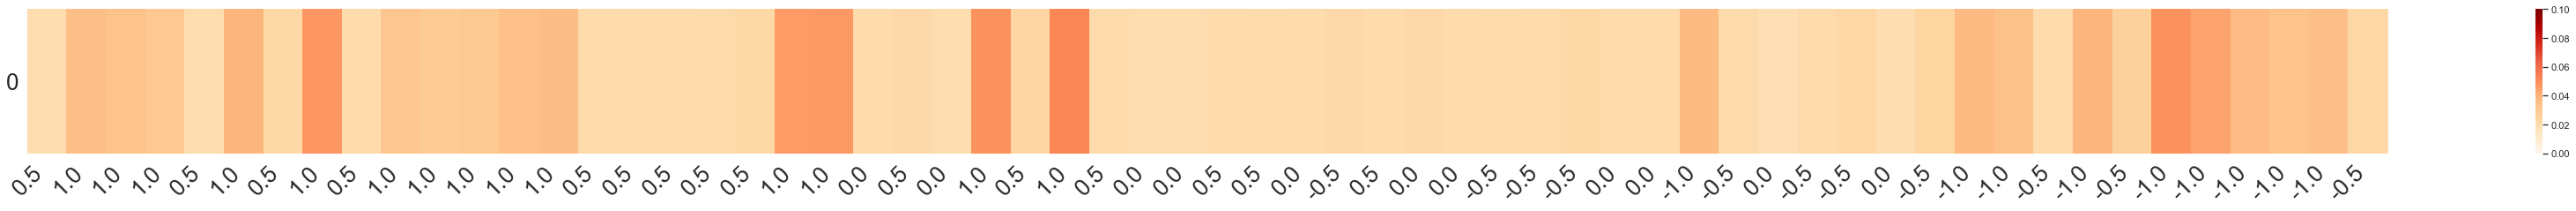

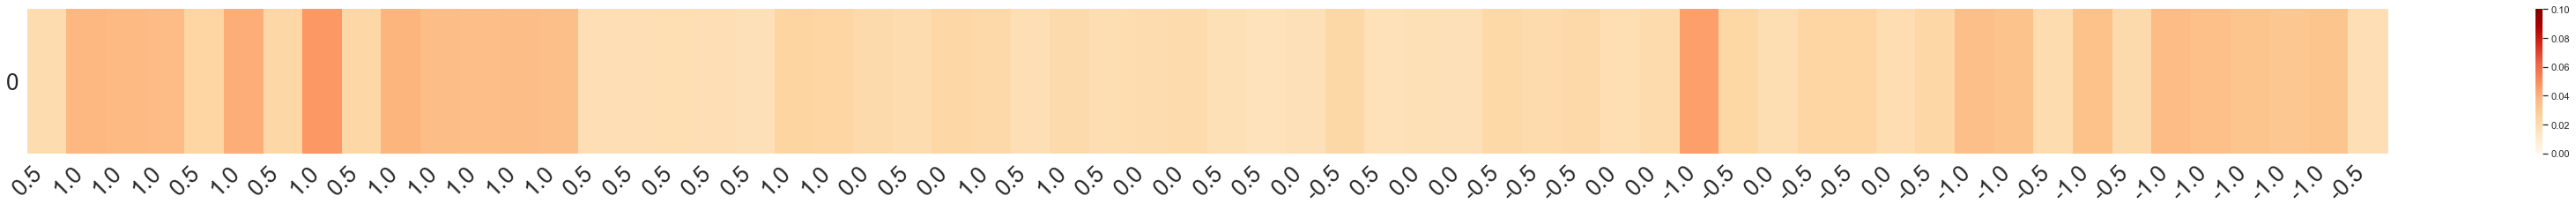

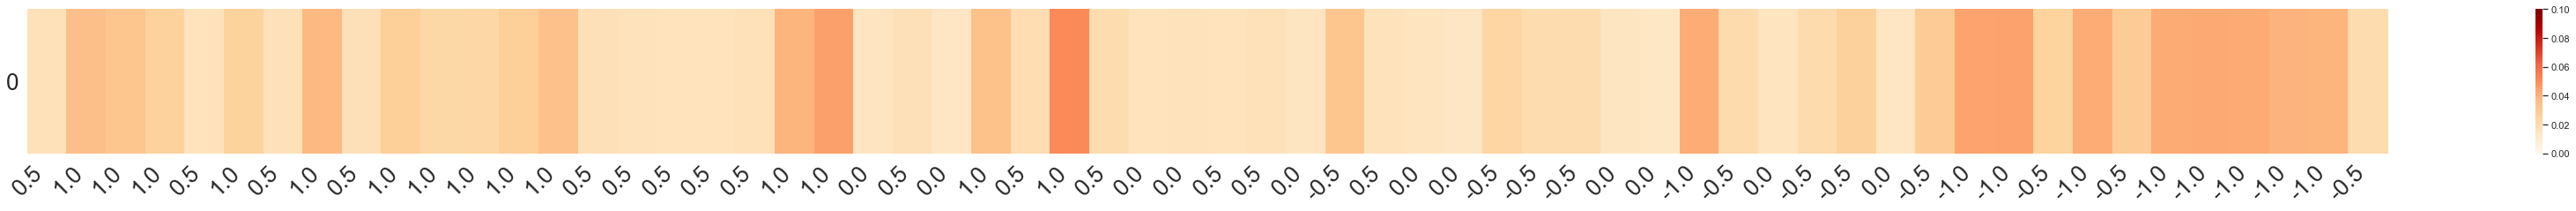

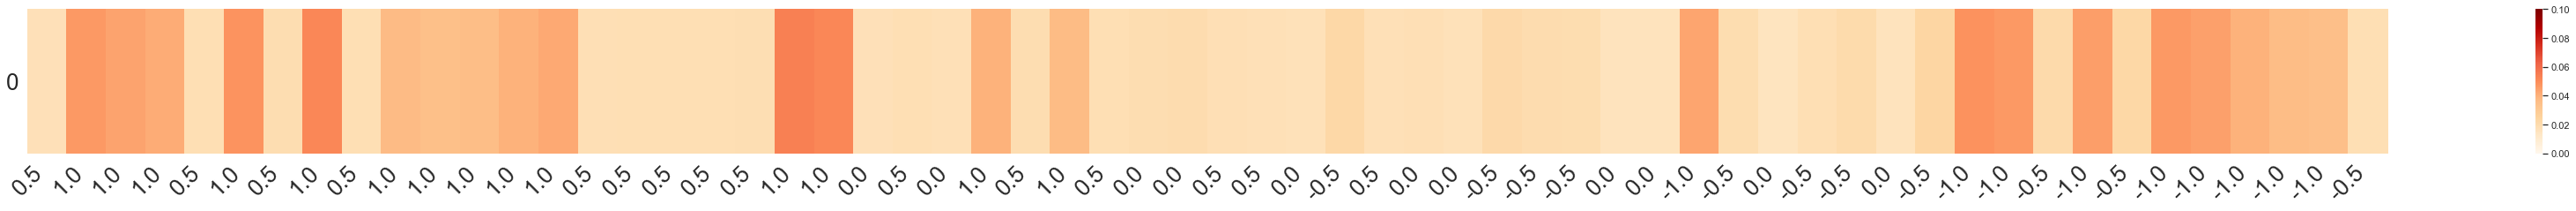

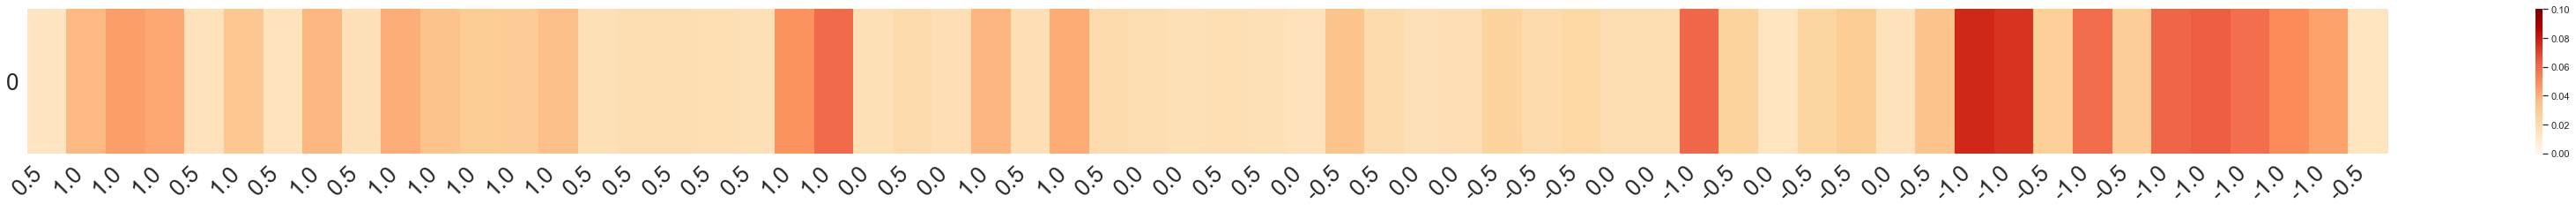

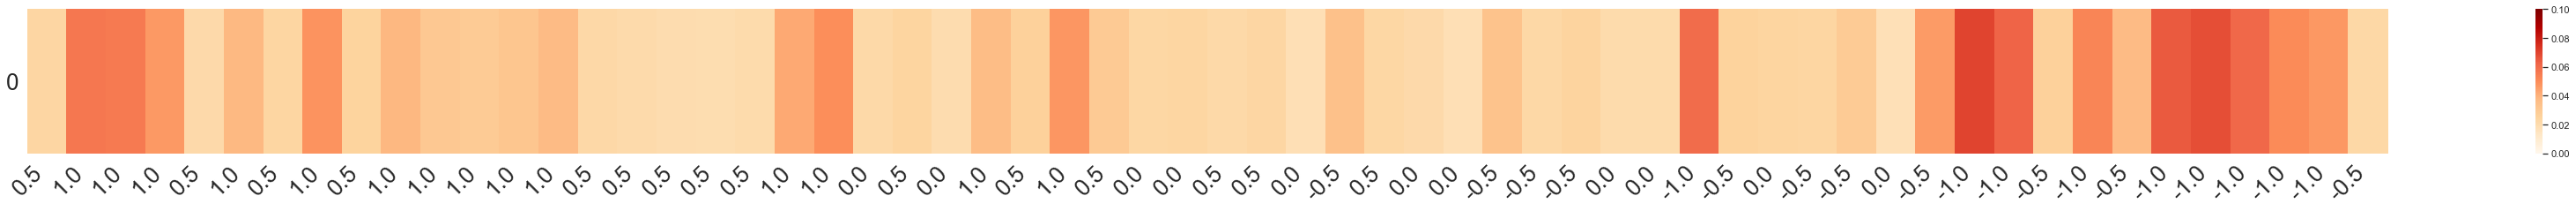

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

index = 3
heads = 6

sns.set()
predictions = outSax[2]
attentionQ = outSax[9]
print('###')
print(y_val[index])
print(predictions[index] + 1)
for head in range(heads):
    data_word = np.array(x_val).squeeze()[index]
    data_att = np.max(attentionQ[1][index][head], axis = 0)
    d = pd.DataFrame(data = data_att,index = data_word, columns=range(1))
    f, ax = plt.subplots(figsize=(60,3))
    d = d.transpose()
    sns.heatmap(d, vmin=0, vmax=0.1, ax=ax, cmap="OrRd")
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=360, horizontalalignment='right')
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=45, horizontalalignment='right')
    plt.tick_params(labelsize=26)
    plt.show()

Prepare attention abstraction data for visualisation

In [20]:
# Parameters
ran = 60

maxLen = 0
predictionsT = outAvgAverage[2]
attentionQT = outAvgAverage[9]
abstractedData = outAvgAverage[-4]

filteredTrain = []
filteredVal = []
for indi in range(len(abstractedData)):

    X_sax = np.array(abstractedData).squeeze()[indi]
    X_ori = X_sax

    heat = np.sum(np.max(attentionQT[1][indi], axis = 1), axis = 0)
    maxHeat = np.average(heat)
    borderHeat = maxHeat


    fitleredSet = []
    for h in range(len(heat)):
        if heat[h] > borderHeat:
            fitleredSet.append([X_ori[h]])
    filteredTrain.append(fitleredSet)
    if len(fitleredSet) > maxLen:
        maxLen = len(fitleredSet)
        
print("++++")
x_vals = x_val
for indi in range(len(x_vals[0])):

    X_sax = np.array(x_vals).squeeze()[indi]
    X_ori = X_sax

    heat = np.sum(np.max(attentionQ[1][indi], axis = 1), axis = 0)
    maxHeat = np.average(heat)
    borderHeat = maxHeat / 2


    fitleredSet = []
    for h in range(len(heat)):
        if heat[h] > borderHeat:
            fitleredSet.append([X_ori[h]])
    filteredVal.append(fitleredSet)
    if len(fitleredSet) > maxLen:
        maxLen = len(fitleredSet)
        
print("####")
print(maxLen)
print(np.array(filteredVal).shape)

++++
####
36
(60,)


Show attention abstraction for each head for a single input

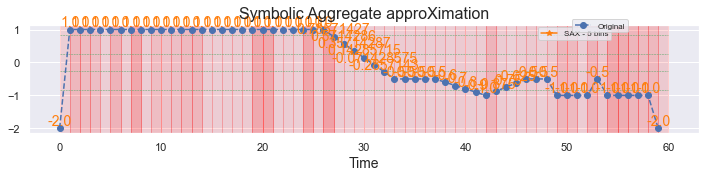

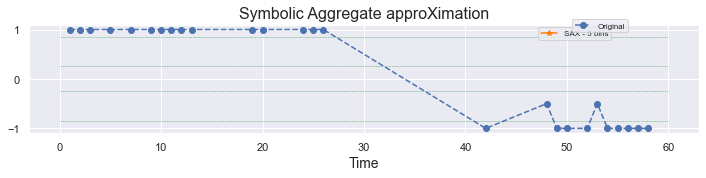

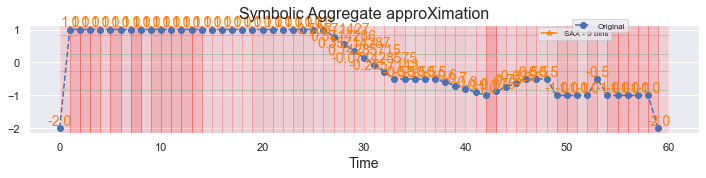

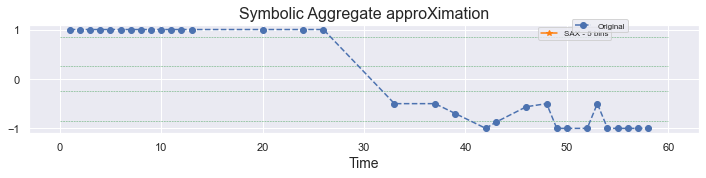

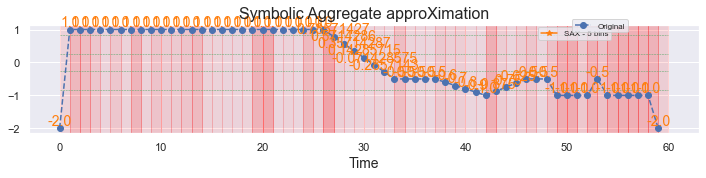

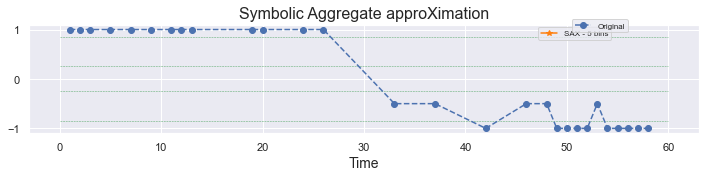

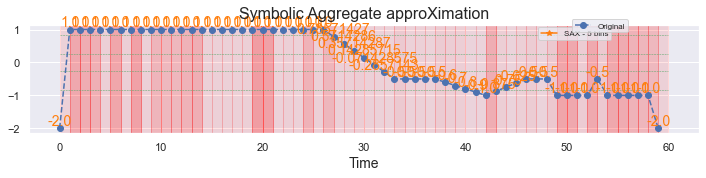

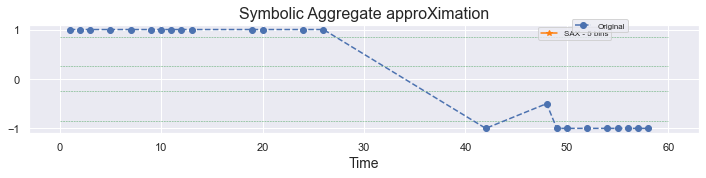

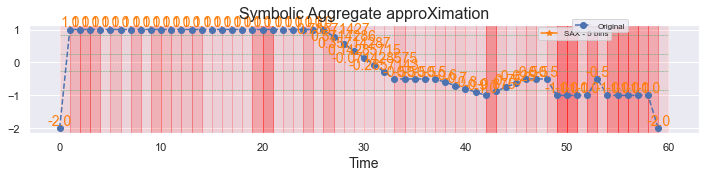

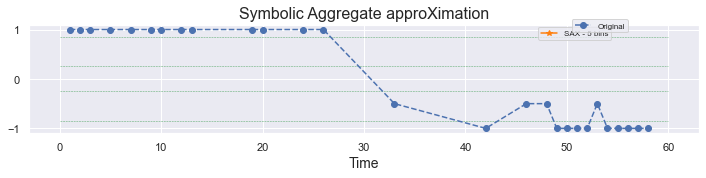

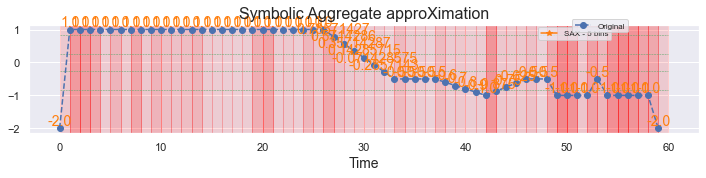

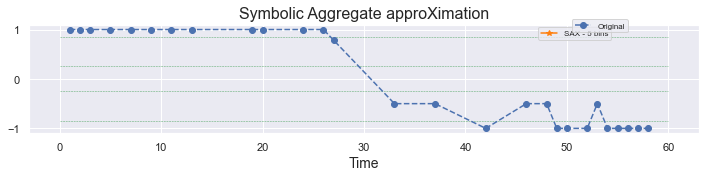

#################################################
[0.11271727 0.25108862 0.24876751 0.22521639 0.11646426 0.22396614
 0.12115225 0.27095202 0.12141959 0.21526442 0.18760125 0.18333709
 0.19971962 0.2212152  0.11455649 0.11376645 0.11305669 0.11198182
 0.11408599 0.25527588 0.27828324 0.11461871 0.12312639 0.11299805
 0.21994786 0.12532128 0.25054544 0.12846957 0.11766255 0.11898103
 0.1132223  0.11391379 0.10453232 0.1663674  0.1158928  0.11217756
 0.10594042 0.14746979 0.12473308 0.13135424 0.10970543 0.11063872
 0.2905802  0.1363237  0.10818688 0.1321304  0.15154913 0.10263914
 0.18068685 0.31287354 0.2962518  0.14097461 0.27310407 0.16540979
 0.3016919  0.29822743 0.27270943 0.24299762 0.23410258 0.11819319]
0.17210232


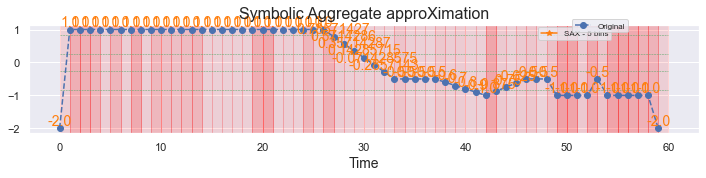

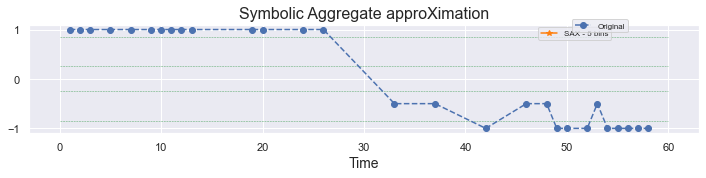

In [21]:


ran = 60
# Parameters
X_sax = np.array(abstractedData).squeeze()[index]
X_ori = X_sax 

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = X_sax
#heads = 6
for head in range(heads):

    plt.figure(figsize=(12, 2))
    plt.plot(X_ori, 'o--', label='Original')
    for x, y, s, bottom in zip(range(ran), X_ori, X_sax, bottom_bool):
        va = 'bottom' if bottom else 'top'
        plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
    plt.hlines(bins, 0, ran, color='g', linestyles='--', linewidth=0.5)
    sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                               label='SAX - {0} bins'.format(n_bins))
    first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
    ax = plt.gca().add_artist(first_legend)
    plt.legend(loc=(0.81, 0.93), fontsize=8)
    plt.xlabel('Time', fontsize=14)
    plt.title('Symbolic Aggregate approXimation', fontsize=16)
    heat = np.max(attentionQ[1][index][head], axis = 0)

    for i in range(len(heat)):
        plt.axvspan(i, i+1, color='red', alpha=heat[i]*6)
    plt.show()
    
    maxHeat = np.average(heat)
    borderHeat = maxHeat
    borderHeat2 = maxHeat/1.2

    fitleredSet = []
    timeSet = []
    avgSet = []
    for h in range(len(heat)):
        if heat[h] > borderHeat:
            if len(avgSet) != 0:
                fitleredSet.append(np.median(avgSet))
                timeSet.append(h - math.ceil(len(avgSet)/2))
                avgSet = []
            fitleredSet.append(X_ori[h])
            timeSet.append(h)
        elif heat[h] > borderHeat2:
            avgSet.append(X_ori[h])
            #avgSet = []
        elif len(avgSet) != 0:
            fitleredSet.append(np.median(avgSet))
            timeSet.append(h - math.ceil(len(avgSet)/2))
            avgSet = []
    
    plt.figure(figsize=(12, 2))
    plt.plot(timeSet, fitleredSet, 'o--', label='Original')
    for x, y, s, bottom in zip(range(len(heat)), fitleredSet, fitleredSet, bottom_bool):
        va = 'bottom' if bottom else 'top'
    plt.hlines(bins, 0, len(heat), color='g', linestyles='--', linewidth=0.5)
    sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                               label='SAX - {0} bins'.format(n_bins))
    first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
    ax = plt.gca().add_artist(first_legend)
    plt.legend(loc=(0.81, 0.93), fontsize=8)
    plt.xlabel('Time', fontsize=14)
    plt.title('Symbolic Aggregate approXimation', fontsize=16)
    plt.show()
    
print('#################################################')
plt.figure(figsize=(12, 2))
plt.plot(X_ori, 'o--', label='Original')
for x, y, s, bottom in zip(range(ran), X_ori, X_sax, bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, ran, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
#heat = np.max(attentionQ[1][index][head], axis = 0)

heat = np.sum(np.max(attentionQ[1][index], axis = 1), axis = 0)
#heat = np.sum(np.max(attentionQ[2][1][index], axis = 1), axis = 0)
maxHeat = np.average(heat)
borderHeat = maxHeat
borderHeat2 = maxHeat/1.2
print(heat)
print(maxHeat)

#remove?
for i in range(len(heat)):
    plt.axvspan(i, i+1, color='red', alpha=heat[i]*1)
plt.show()

fitleredSet = []
timeSet = []
avgSet = []
for h in range(len(heat)):
    if heat[h] > borderHeat:
        if len(avgSet) != 0:
            fitleredSet.append(np.median(avgSet))
            timeSet.append(h - math.ceil(len(avgSet)/2))
            avgSet = []
        fitleredSet.append(X_ori[h])
        timeSet.append(h)
    elif heat[h] > borderHeat2:
        avgSet.append(X_ori[h])
        #avgSet = []
    elif len(avgSet) != 0:
        fitleredSet.append(np.median(avgSet))
        timeSet.append(h - math.ceil(len(avgSet)/2))
        avgSet = []

plt.figure(figsize=(12, 2))
plt.plot(timeSet, fitleredSet, 'o--', label='Original')
for x, y, s, bottom in zip(range(len(heat)), fitleredSet, fitleredSet, bottom_bool):
    va = 'bottom' if bottom else 'top'
plt.hlines(bins, 0, len(heat), color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

Plots original data, sax data and abstracted data for each lable in goal

6


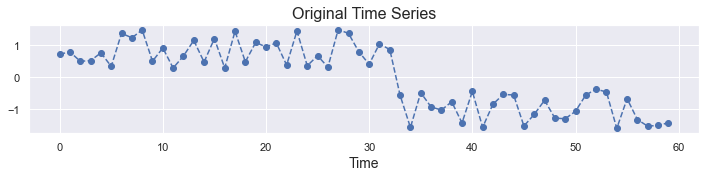

#################################################
5


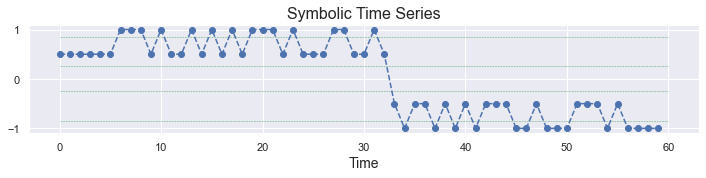

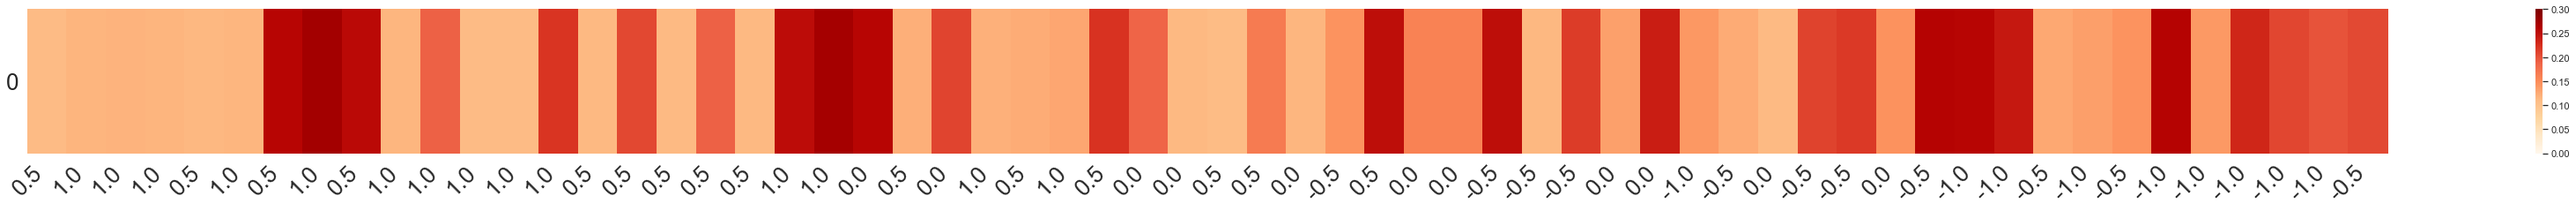

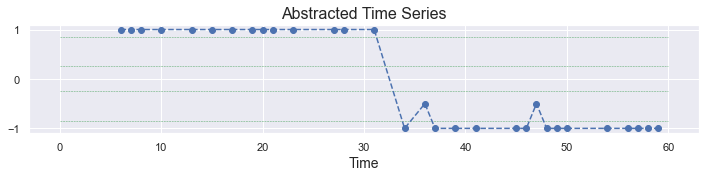

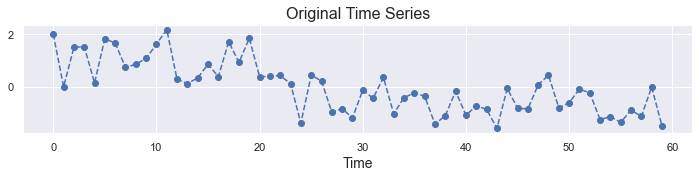

#################################################
5


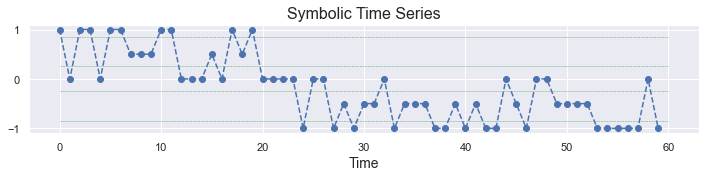

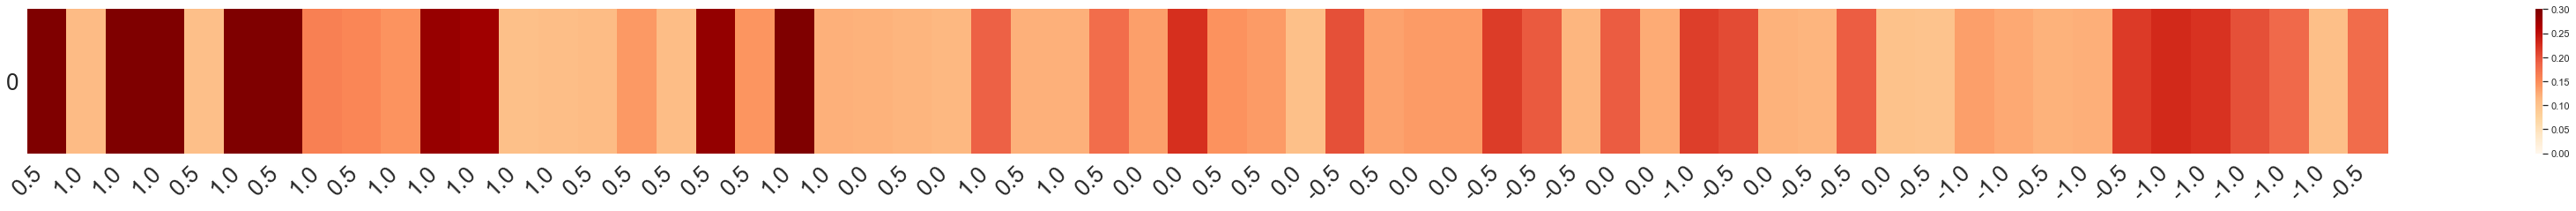

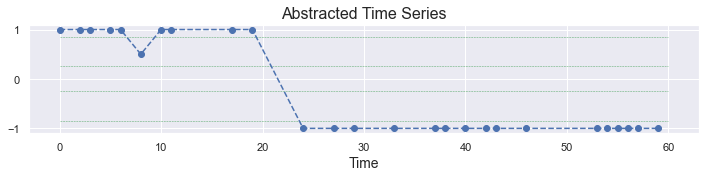

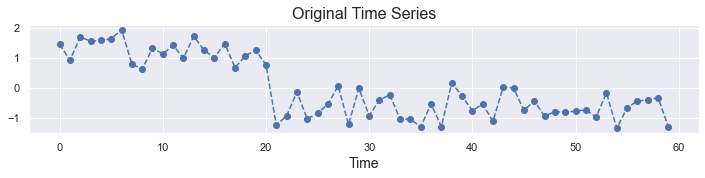

#################################################
5


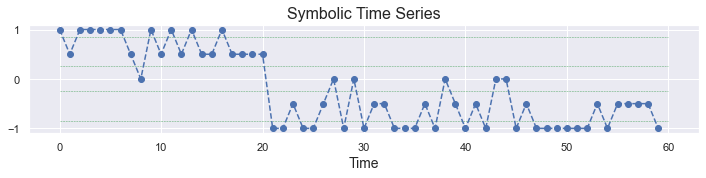

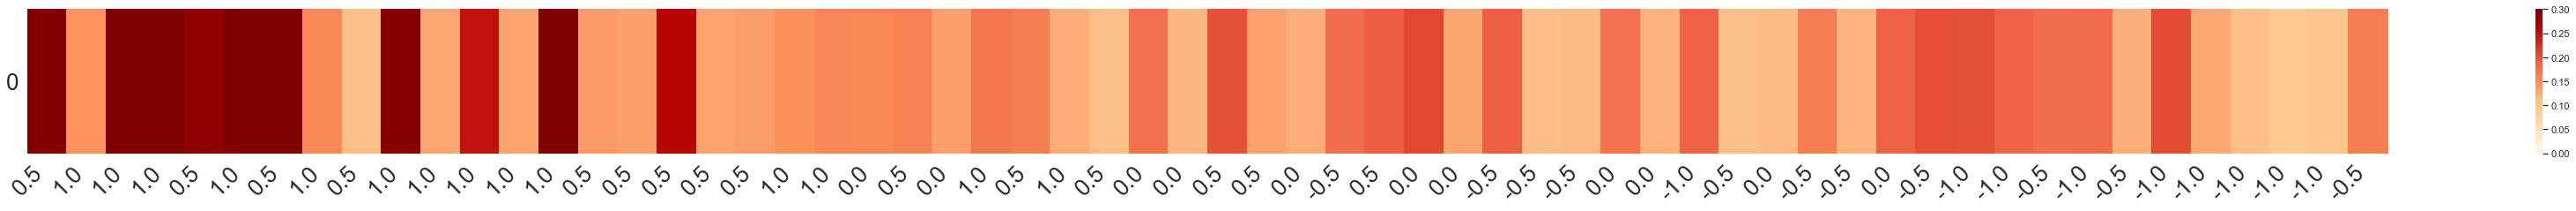

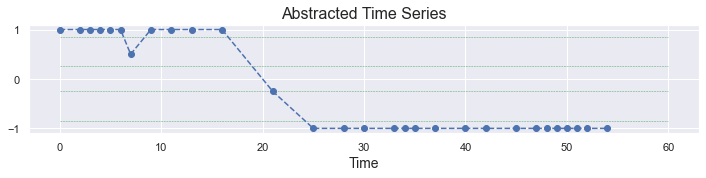

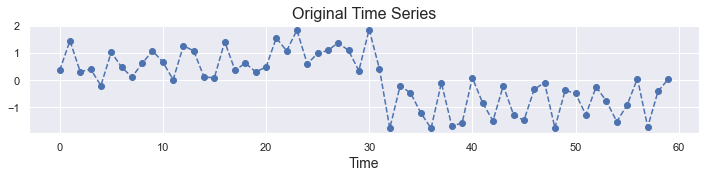

#################################################
5


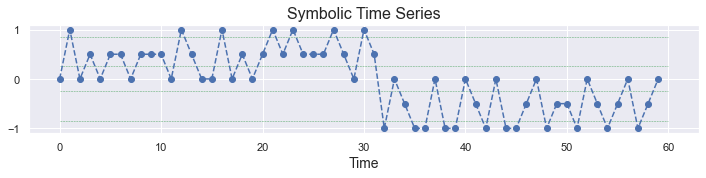

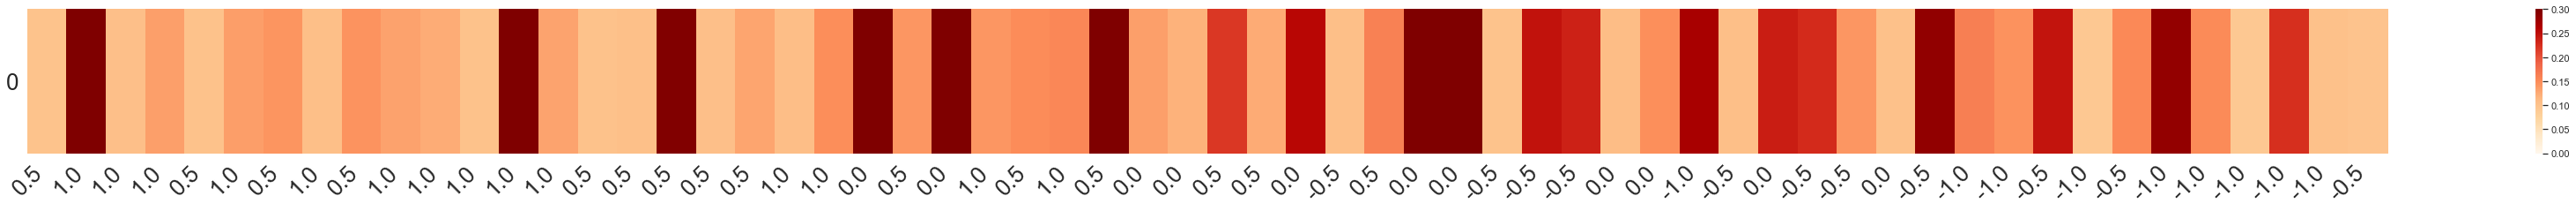

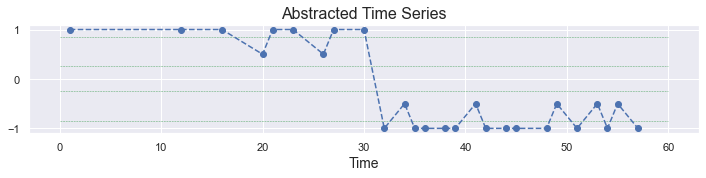

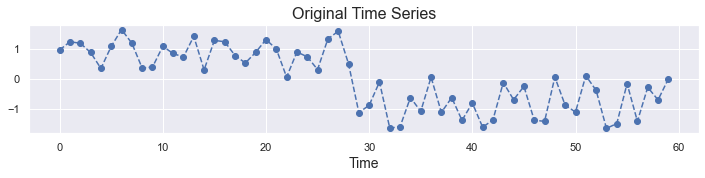

#################################################
5


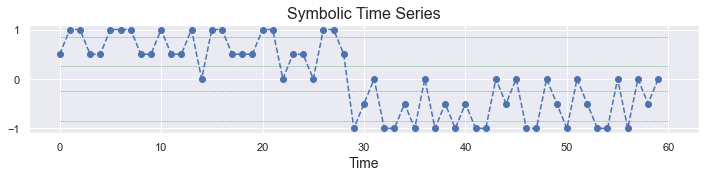

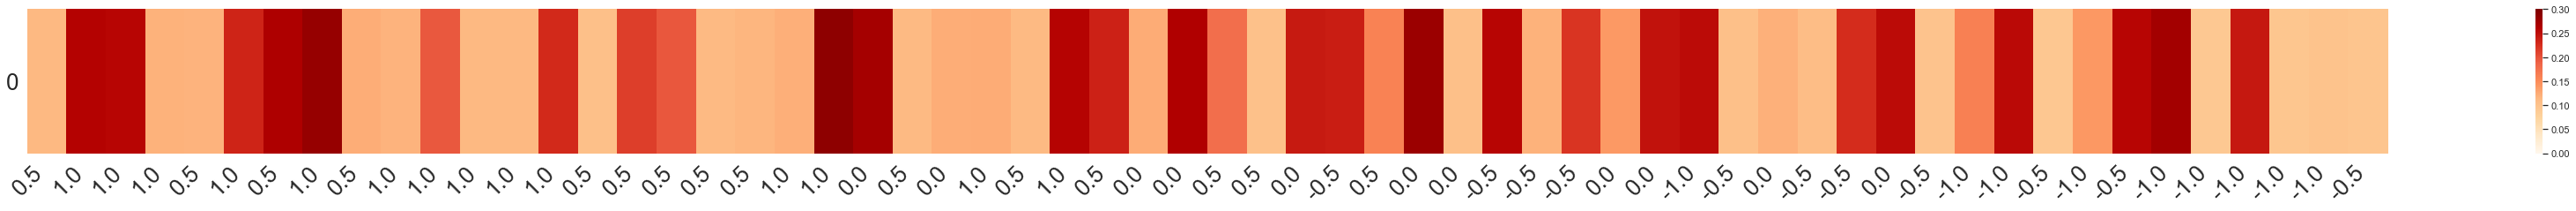

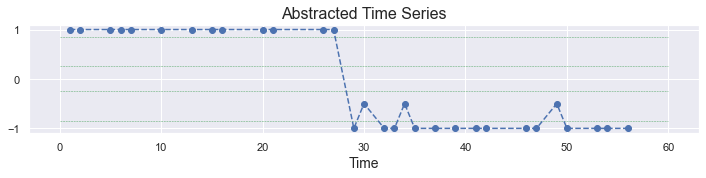

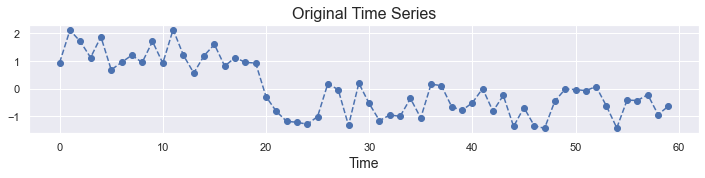

#################################################
5


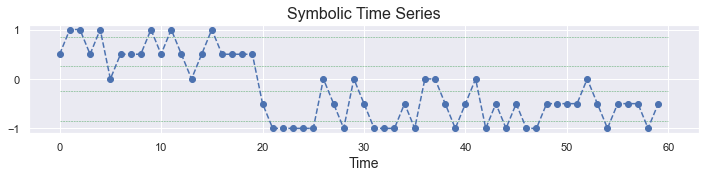

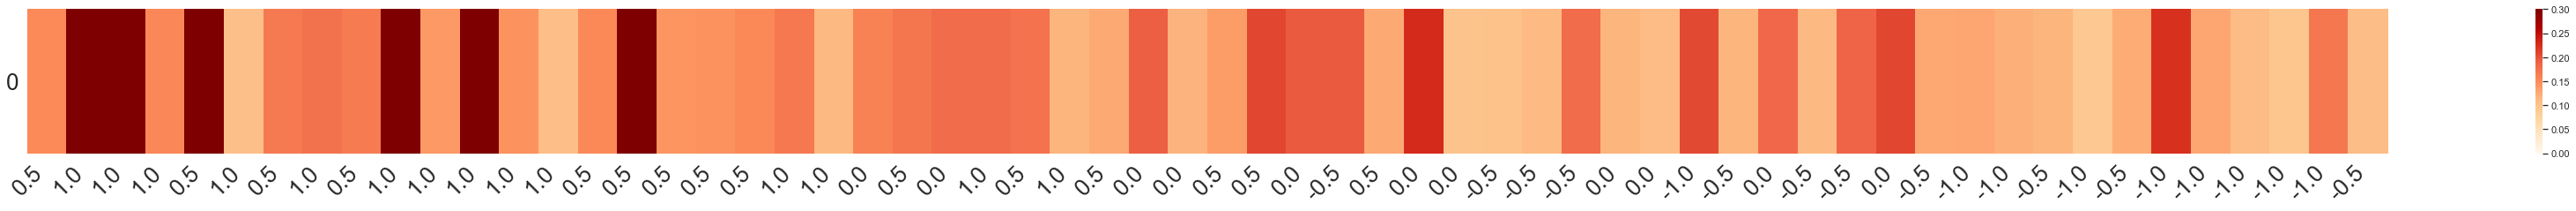

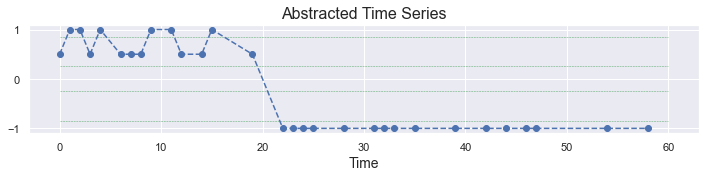

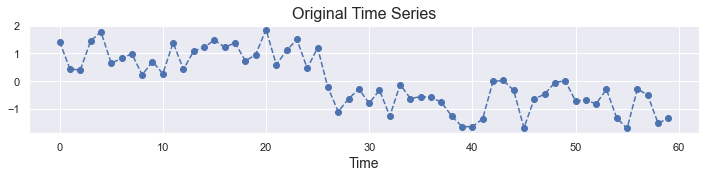

#################################################
5


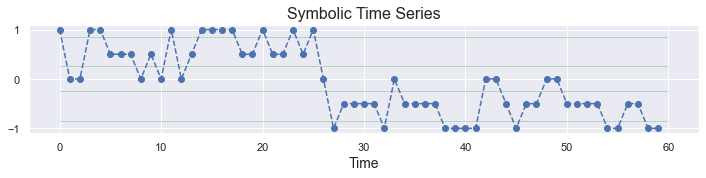

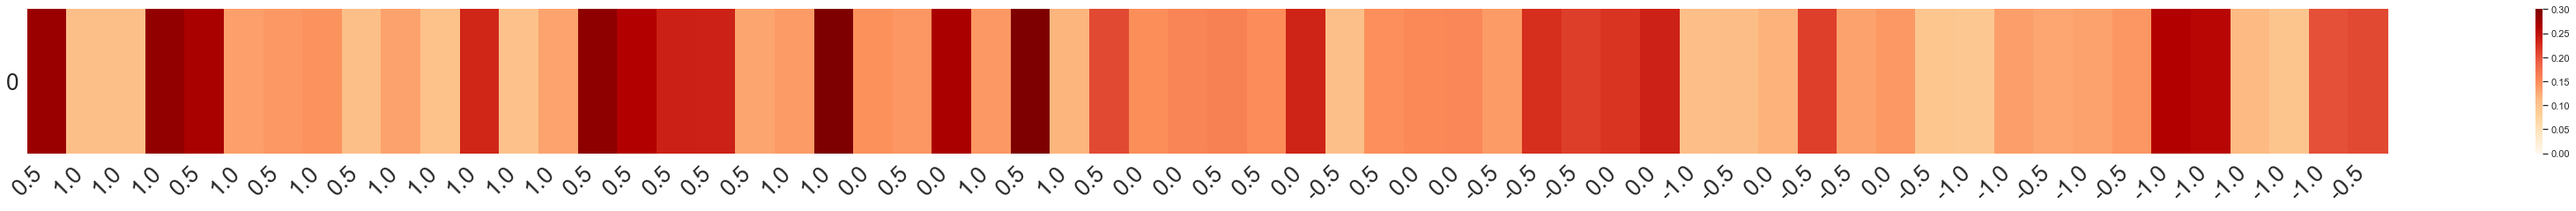

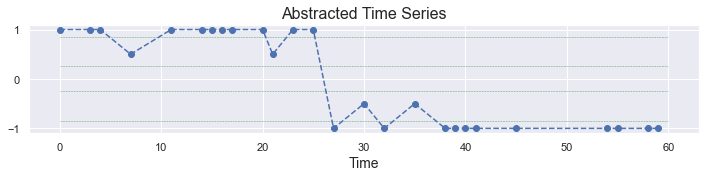

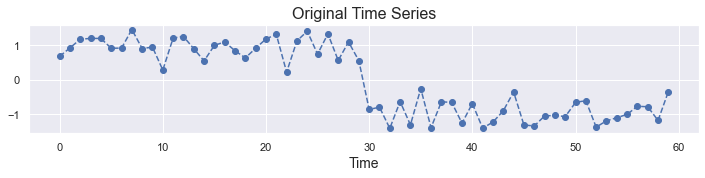

#################################################
5


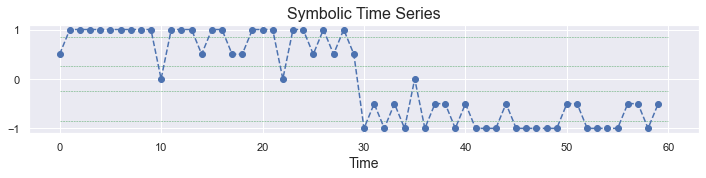

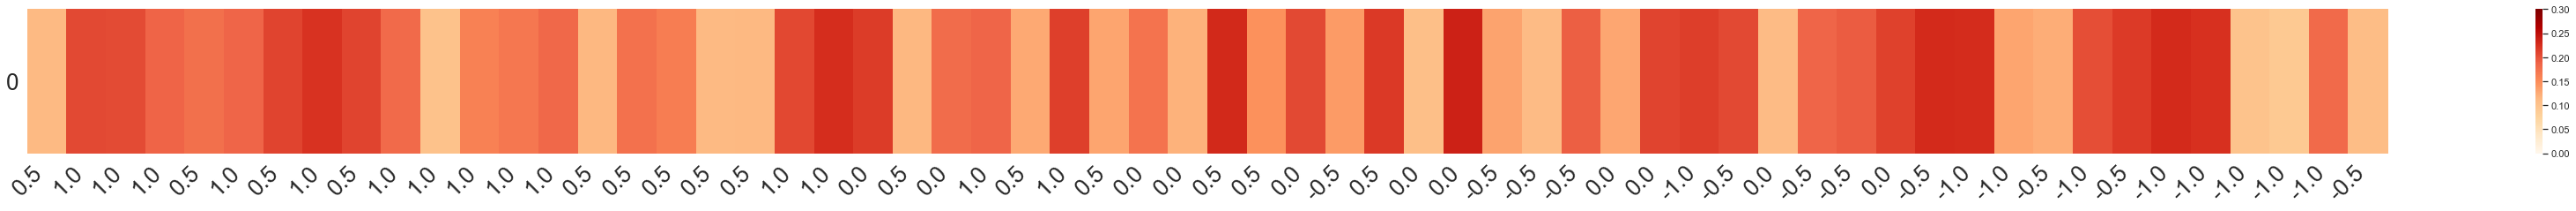

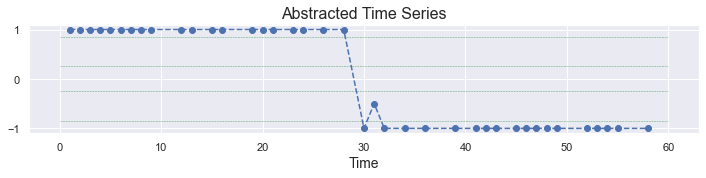

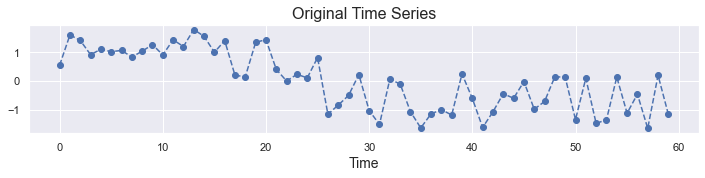

#################################################
5


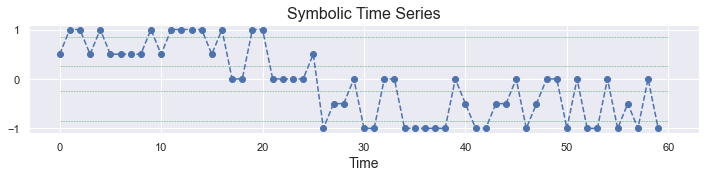

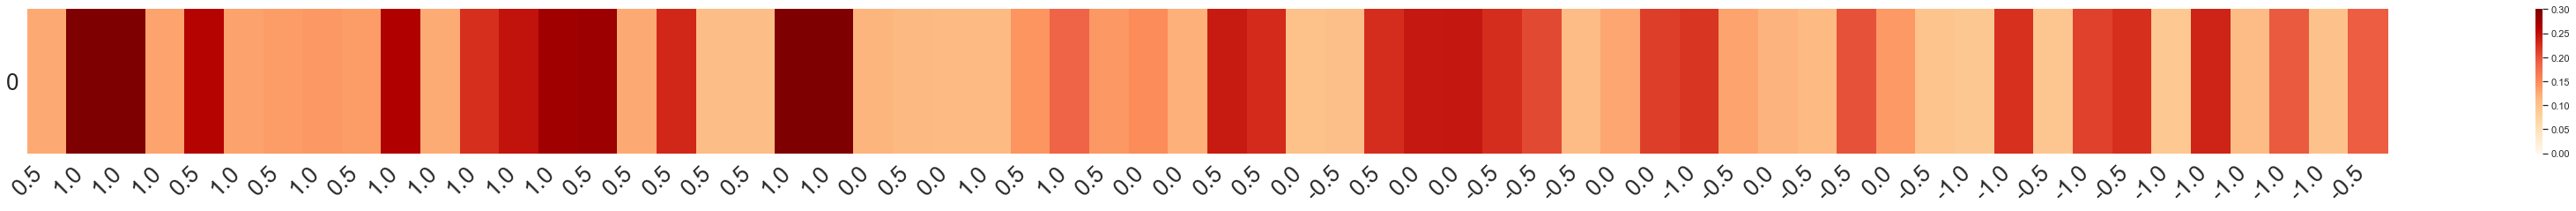

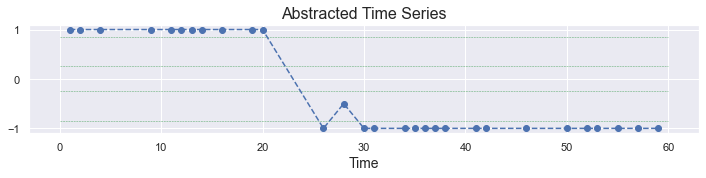

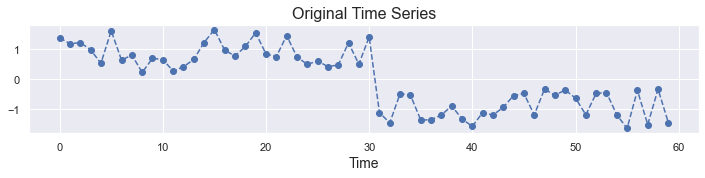

#################################################
5


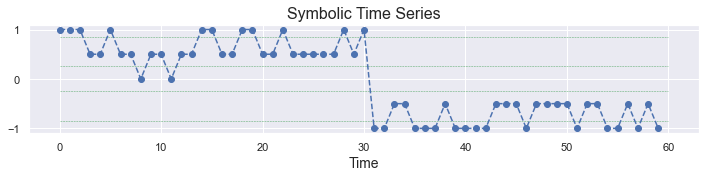

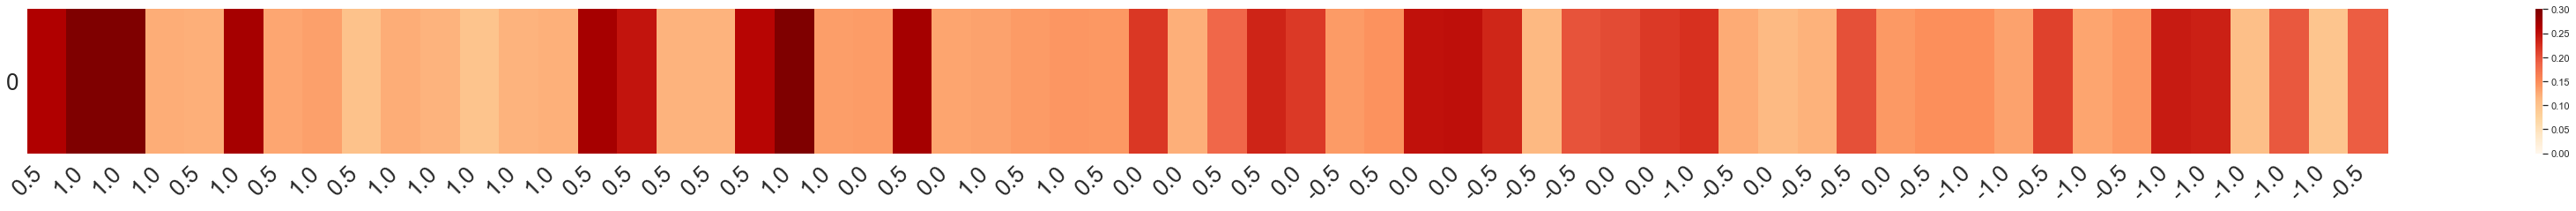

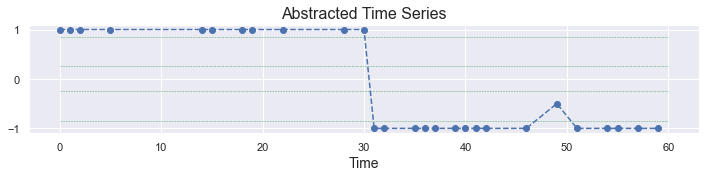

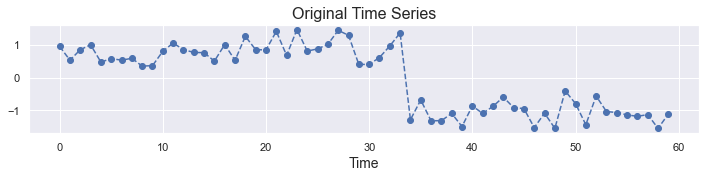

#################################################
5


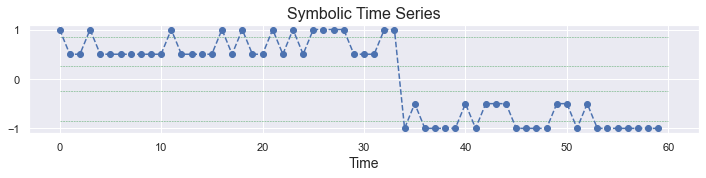

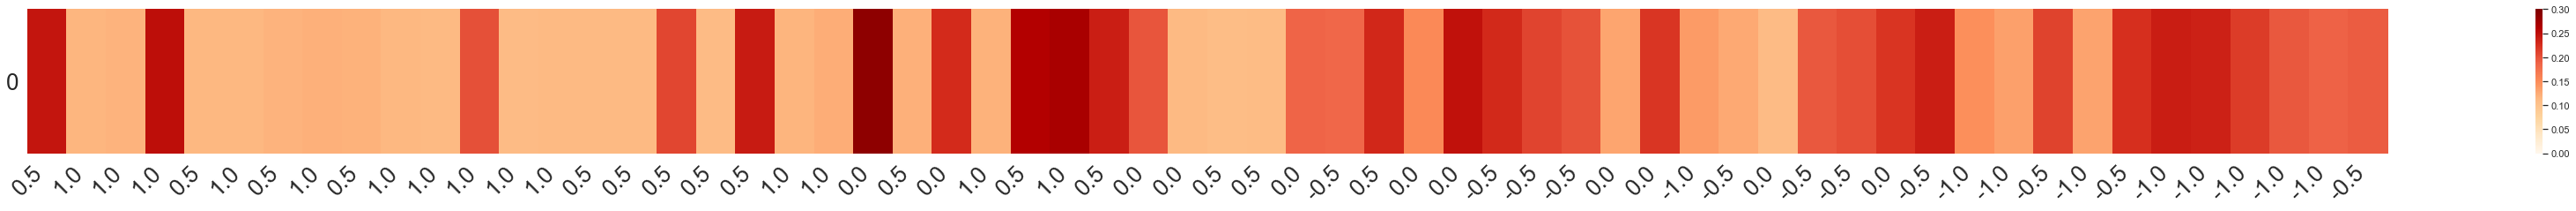

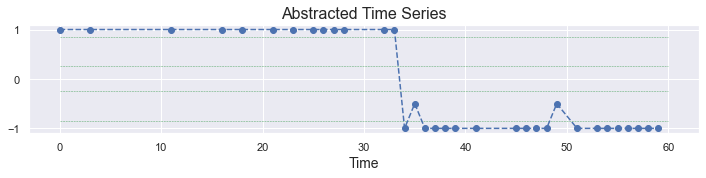

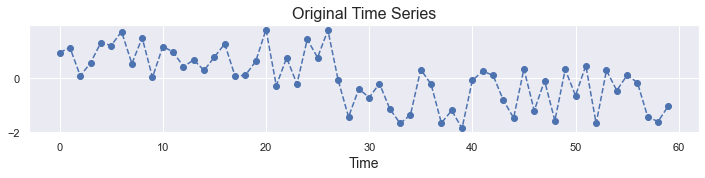

#################################################
5


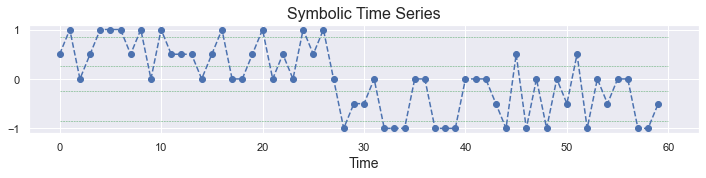

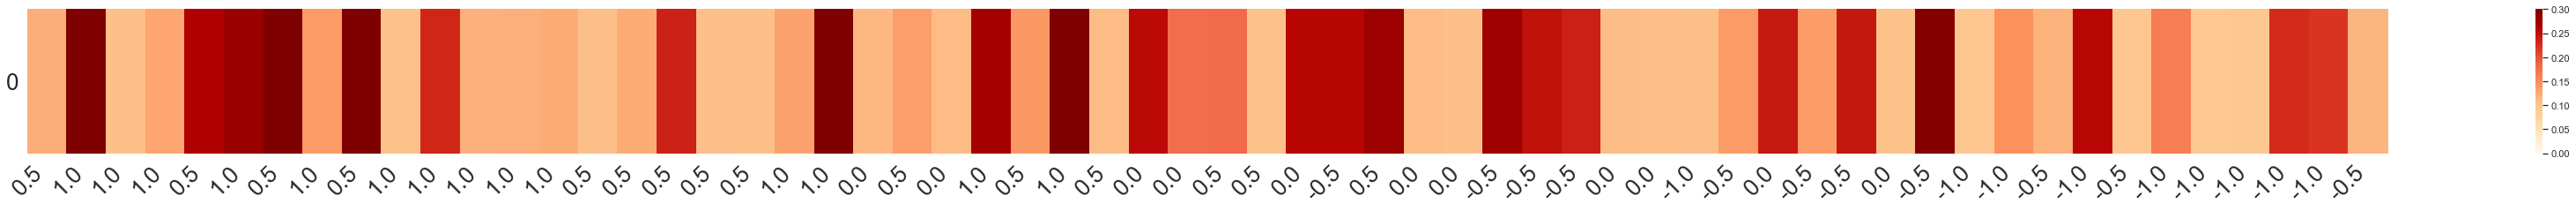

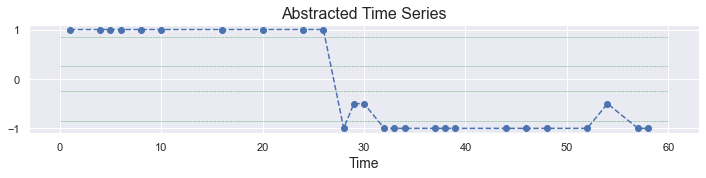

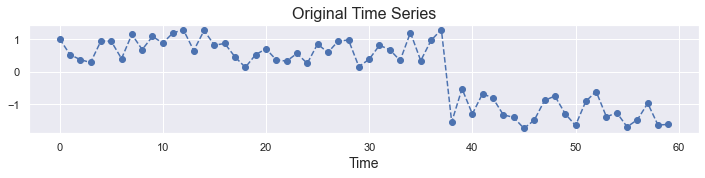

#################################################
5


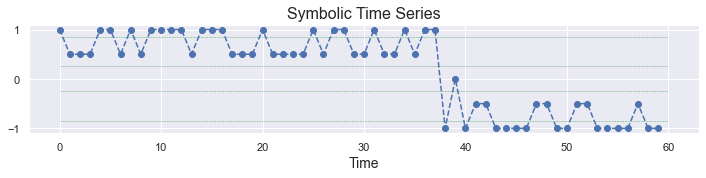

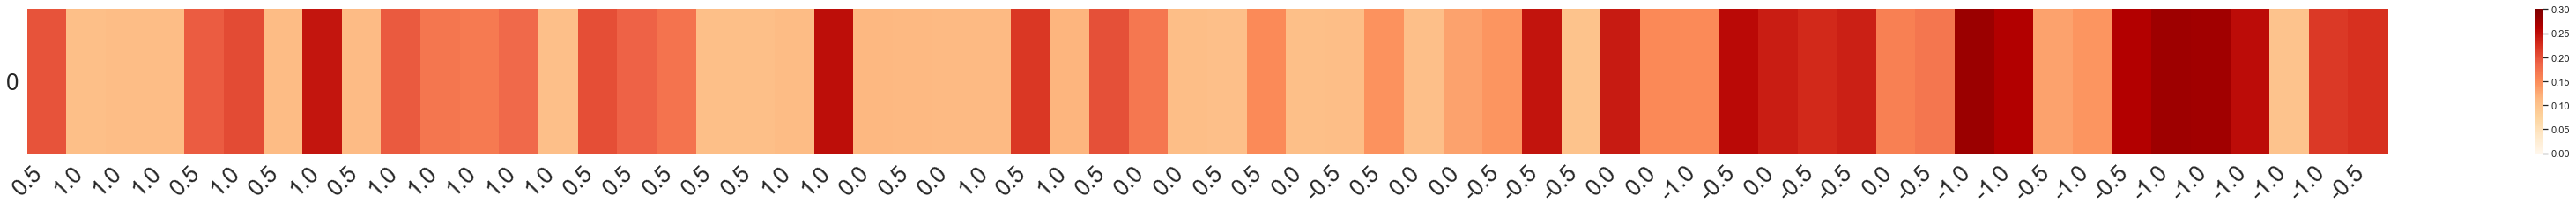

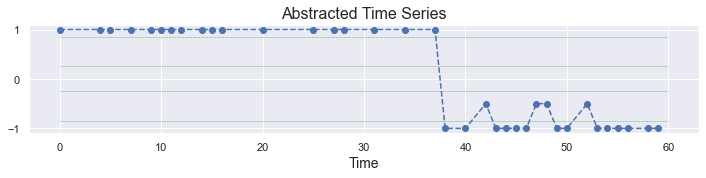

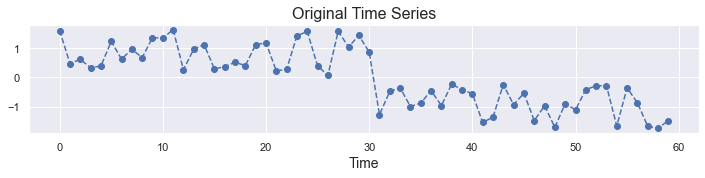

#################################################
5


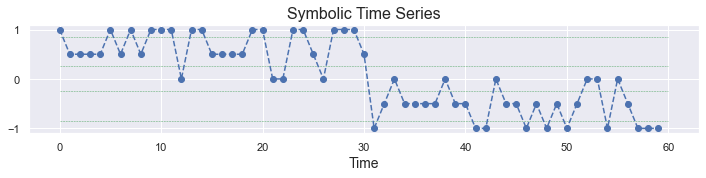

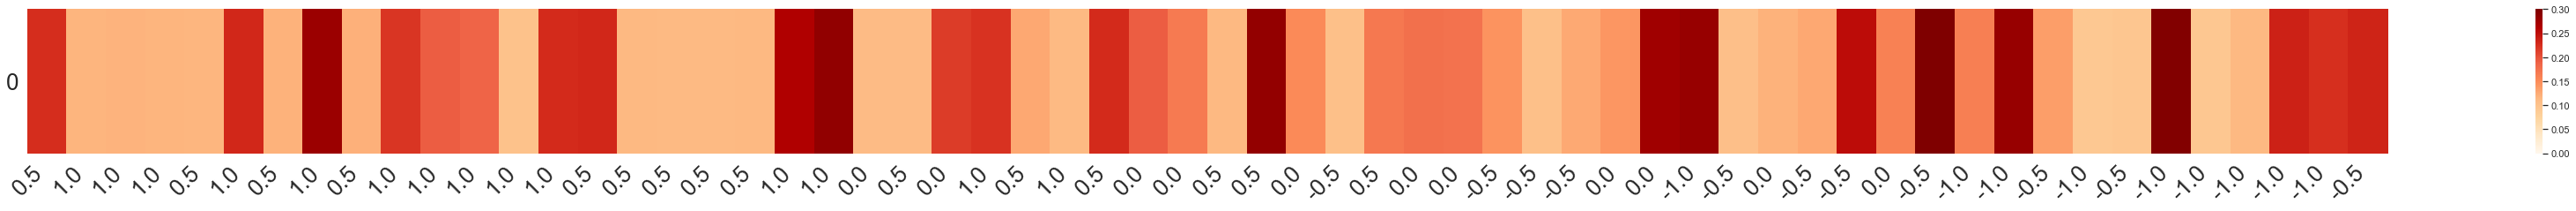

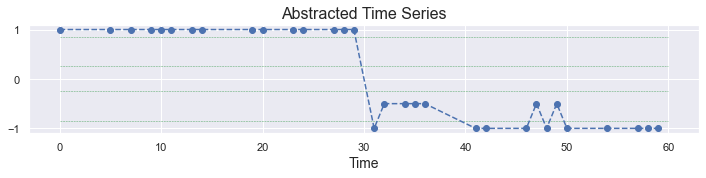

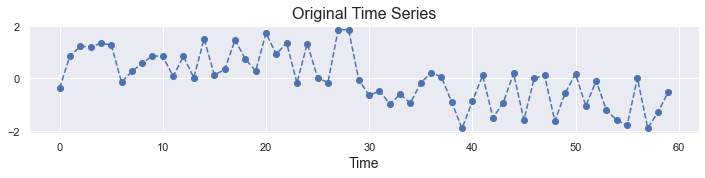

#################################################
5


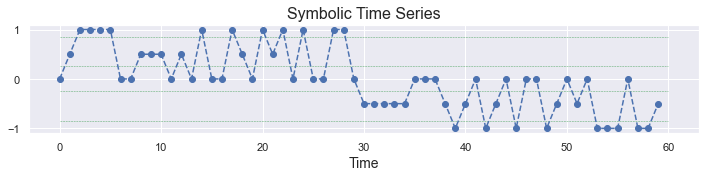

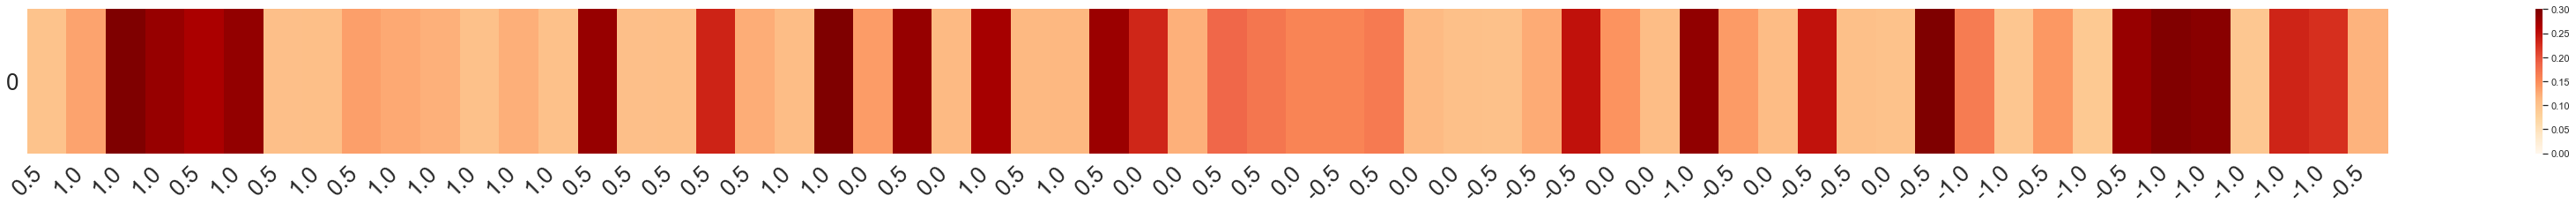

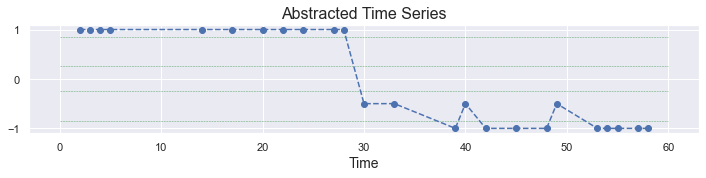

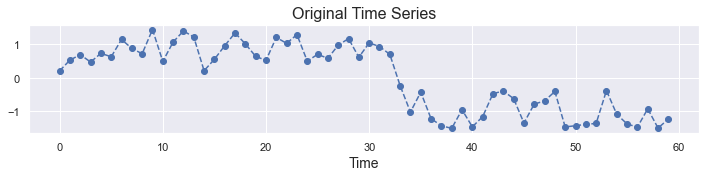

#################################################
5


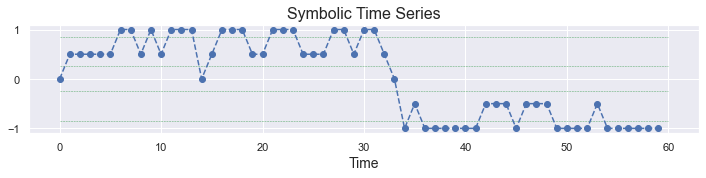

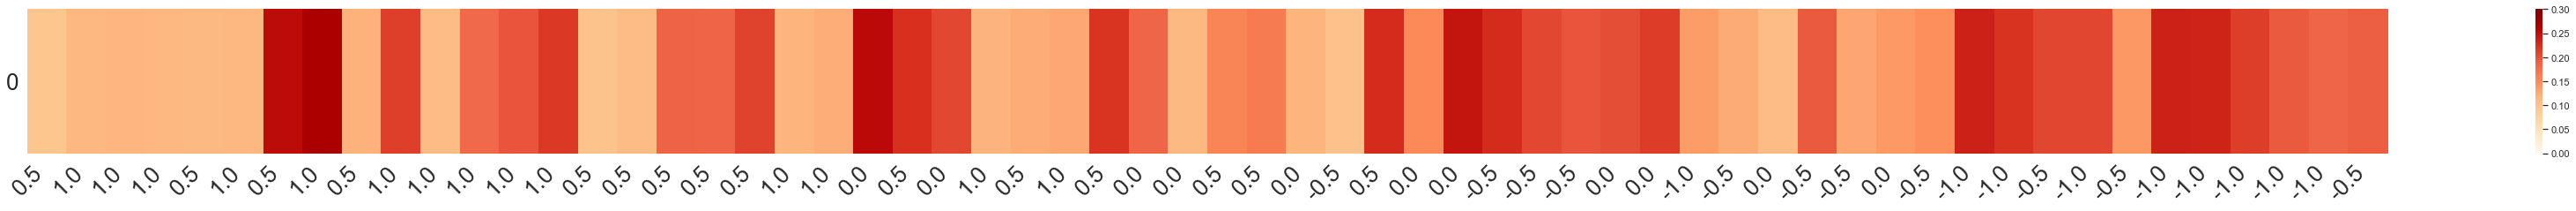

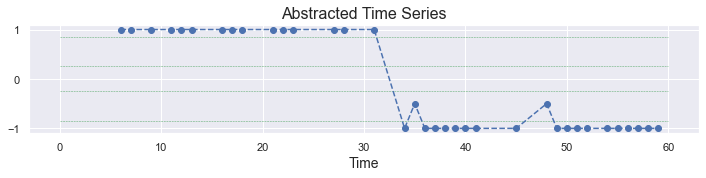

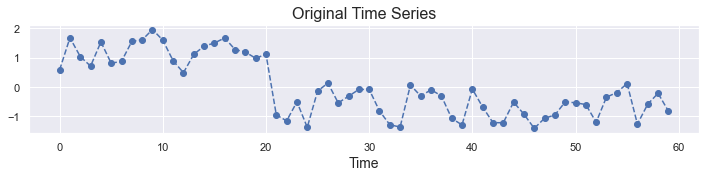

#################################################
5


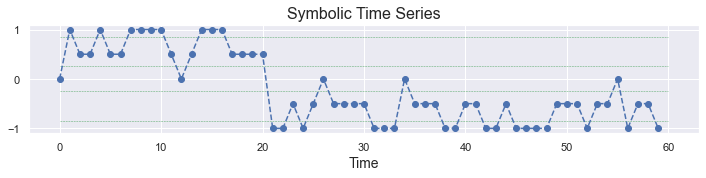

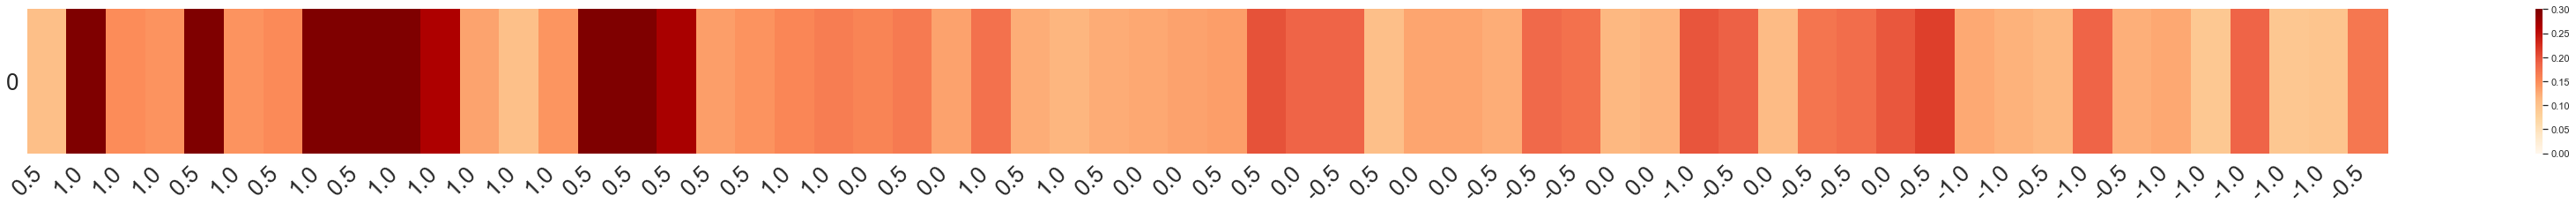

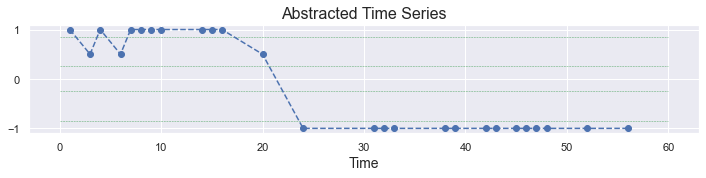

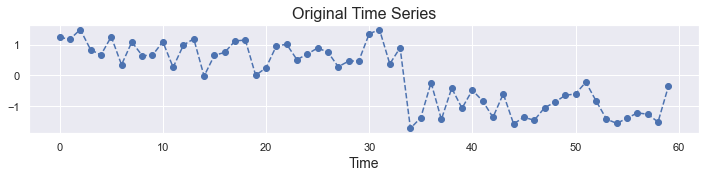

#################################################
5


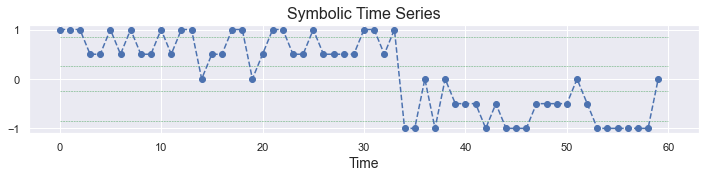

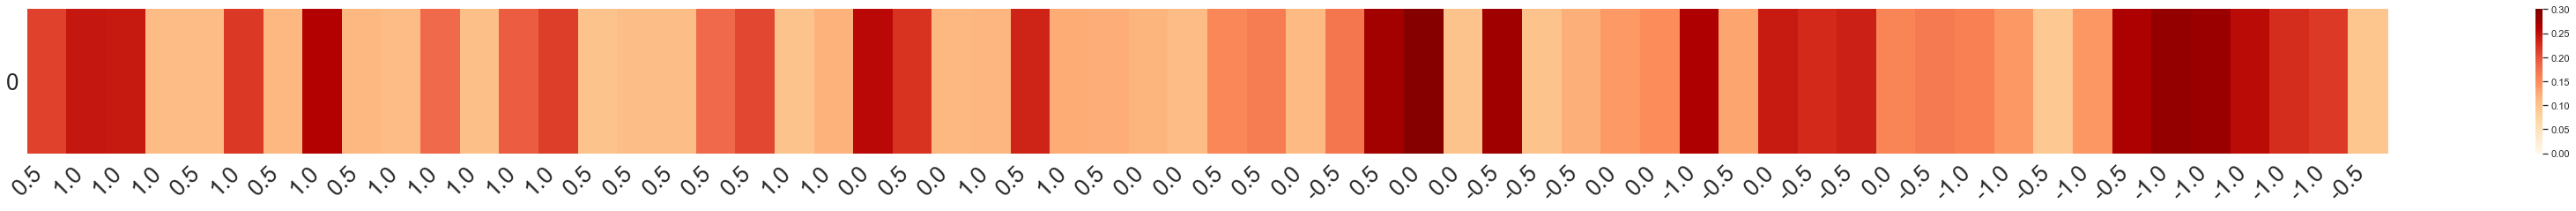

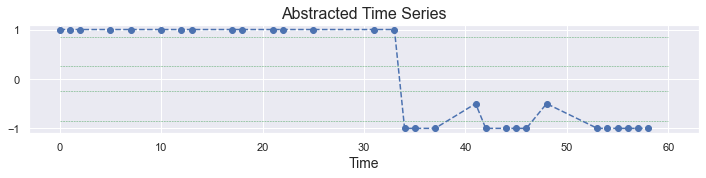

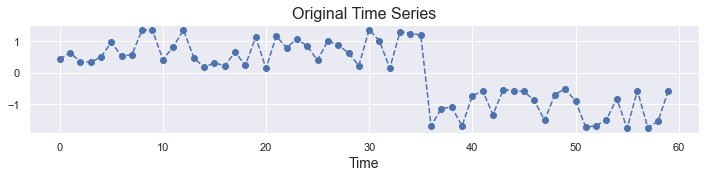

#################################################
5


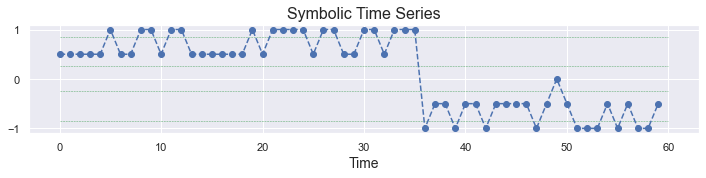

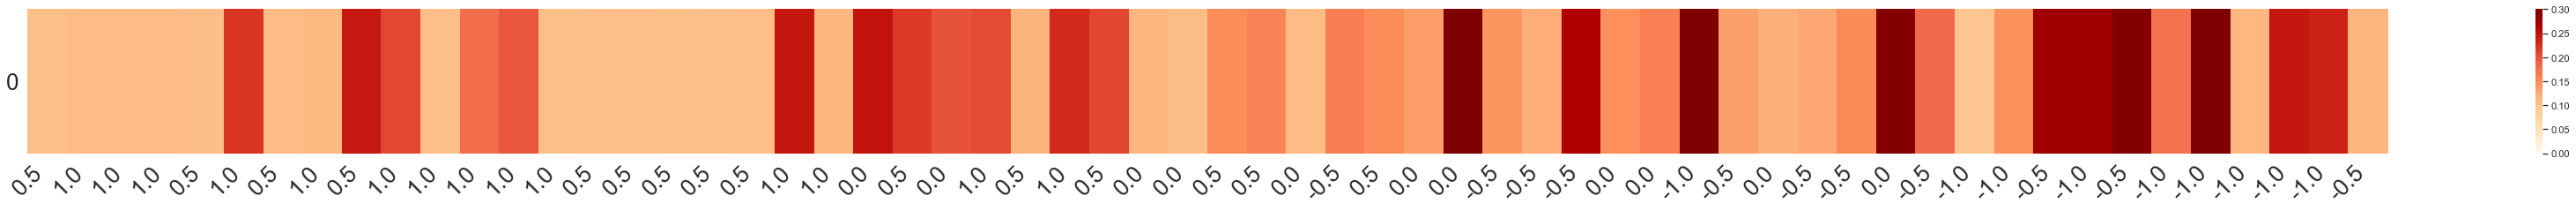

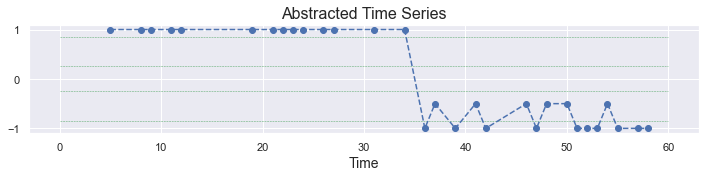

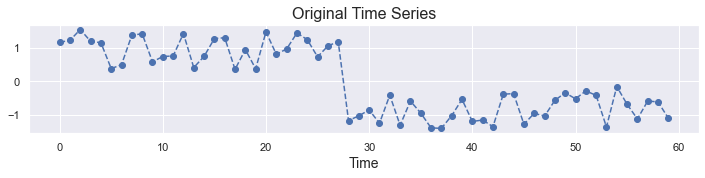

#################################################
5


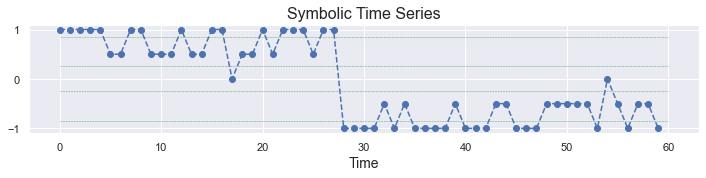

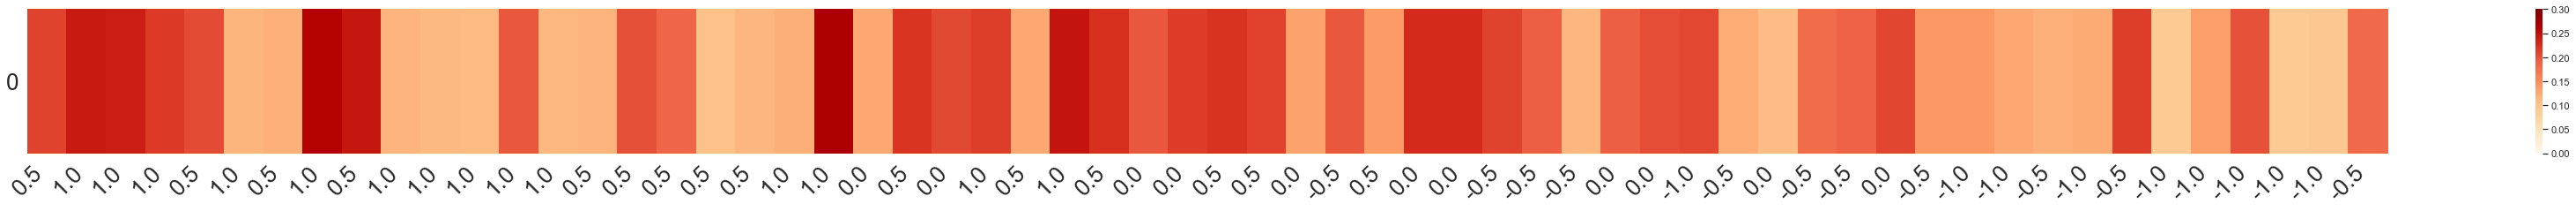

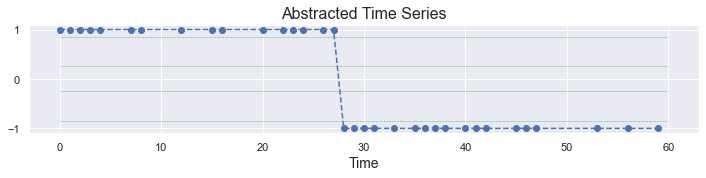

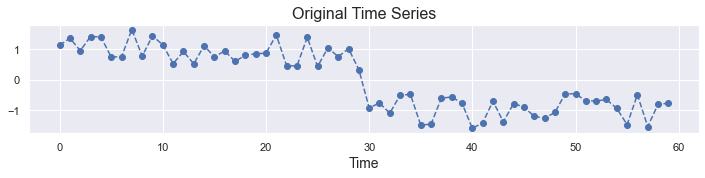

#################################################
5


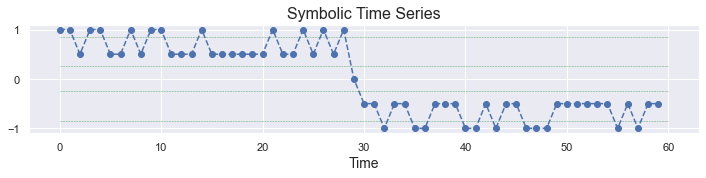

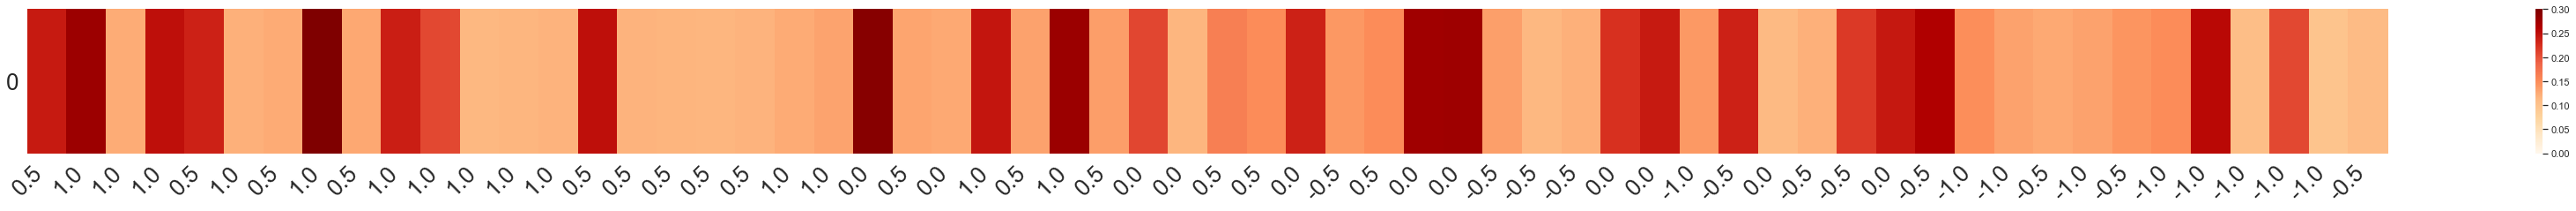

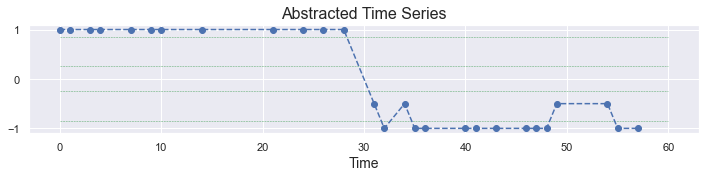

In [26]:
#for goal in [1,2,3,4,5]:
indexSafe = index

#theSet = outAvgAverage[-4]
theSet = outSax[7]
valSet = y_test #y_val
n_model = outSax[4]
earlyPredictor = outSax[-6]
doMax = False
maxString = 'average'
X_ori = outSax[7]

limit = 300
predictionsX = outSax[3]
attentionQX = []
for bor in range(int(math.ceil(len(theSet[0])/limit))):
    attentionQX.extend(earlyPredictor.predict([theSet[0][bor*limit:(bor+1)*limit]])[1])

counterLimit = 20
for goal in [6]:
    print(goal)

    counter = 0 
    for index in range(len(predictionsX)):
        if predictionsX[index] + 1 == goal and np.argmax(valSet[index]) + 1 == goal and counter <= counterLimit:
            counter += 1

            X_sax = np.array(theSet).squeeze()[index]
            X_ori = X_sax 

            plt.figure(figsize=(12, 2))
            plt.plot(X_test_ori[index], 'o--', label='Original')
            plt.title('Original Time Series', fontsize=16)
            plt.xlabel('Time', fontsize=14)
            #plt.savefig('./Bilder/' +  str(data_path_train.split('/')[-1].split('.')[0]) + '/interpolate/' + maxString + '/abstractions/' + str(valSet[index]) + '-p' + str(goal) + '-' + str(index) + 'oriForm.png', dpi = 300)
            plt.show()
            
            print('#################################################')
            print(np.argmax(valSet[index], axis=0))
            plt.figure(figsize=(12, 2))
            plt.plot(X_ori, 'o--', label='Original')
            for x, y, s, bottom in zip(range(len(X_ori)), X_ori, X_sax, bottom_bool):
                va = 'bottom' if bottom else 'top'
            plt.hlines(bins, 0, ran, color='g', linestyles='--', linewidth=0.5)

            plt.xlabel('Time', fontsize=14)
            plt.title('Symbolic Time Series', fontsize=16)


            heat = np.sum(np.max(attentionQX[index], axis = 1), axis = 0)
            if doMax:
                maxHeat = np.max(heat)
                borderHeat = maxHeat/2
                borderHeat2 = maxHeat/3
            else:
                maxHeat = np.average(heat)
                borderHeat = maxHeat
                borderHeat2 = maxHeat/1.2

            #plt.savefig('./Bilder/' +  str(data_path_train.split('/')[-1].split('.')[0]) + '/interpolate/' + maxString + '/abstractions/' + str(valSet[index]) + '-p' + str(goal) + '-' + str(index) + 'saxForm.png', dpi = 300)
            plt.show()
            
            data_att = heat
            #d = pd.DataFrame(data = data_att,index = data_word, columns=data_word)
            d = pd.DataFrame(data = data_att,index = data_word, columns=range(1))
            f, ax = plt.subplots(figsize=(60,3))
            d = d.transpose()
            sns.heatmap(d, vmin=0, vmax=0.3, ax=ax, cmap="OrRd")
            label_y = ax.get_yticklabels()
            plt.setp(label_y, rotation=360, horizontalalignment='right')
            label_x = ax.get_xticklabels()
            plt.setp(label_x, rotation=45, horizontalalignment='right')
            plt.tick_params(labelsize=26)
            #plt.savefig('./Bilder/' +  str(data_path_train.split('/')[-1].split('.')[0]) + '/interpolate/' + maxString + '/abstractions/' + str(valSet[index]) + '-p' + str(goal) + '-' + str(index) + 'heatForm.png', dpi = 300)
            plt.show()

            fitleredSet = []
            timeSet = []
            avgSet = []
            for h in range(len(heat)):
                if heat[h] > borderHeat:
                    if len(avgSet) != 0:
                        fitleredSet.append(np.median(avgSet))
                        timeSet.append(h - math.ceil(len(avgSet)/2))
                        avgSet = []
                    fitleredSet.append(X_ori[h])
                    timeSet.append(h)
                elif heat[h] > borderHeat2:
                    avgSet.append(X_ori[h])
                    #avgSet = []
                elif len(avgSet) != 0:
                    fitleredSet.append(np.median(avgSet))
                    timeSet.append(h - math.ceil(len(avgSet)/2))
                    avgSet = []

            #print(fitleredSet)

            plt.figure(figsize=(12, 2))
            plt.plot(timeSet, fitleredSet, 'o--', label='Original')
            for x, y, s, bottom in zip(range(len(heat)), fitleredSet, fitleredSet, bottom_bool):
                va = 'bottom' if bottom else 'top'
            plt.hlines(bins, 0, len(heat), color='g', linestyles='--', linewidth=0.5)
            plt.xlabel('Time', fontsize=14)
            plt.title('Abstracted Time Series', fontsize=16)
            
            #plt.savefig('./Bilder/' + str(data_path_train.split('/')[-1].split('.')[0]) + '/interpolate/' + maxString + '/abstractions/' + str(valSet[index]) + '-p' + str(goal) + '-' + str(index) + 'abstractForm.png', dpi = 300)
            plt.show()

index = indexSafe